In [556]:
!pip install category_encoders
!pip install xgboost
!pip install catboost



python(34761) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


python(34764) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


python(34765) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


In [557]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import category_encoders as ce

from sklearn import svm
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, roc_curve
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import CategoricalNB, BernoulliNB, MultinomialNB, GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.preprocessing import label_binarize
from sklearn.impute import SimpleImputer

import plotly.graph_objects as go
from nltk.corpus import stopwords

In [558]:
#Loading the dataset
data = pd.read_csv('US_Accidents_March23_sampled_500k.csv')
# data.head()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 46 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   ID                     500000 non-null  object 
 1   Source                 500000 non-null  object 
 2   Severity               500000 non-null  int64  
 3   Start_Time             500000 non-null  object 
 4   End_Time               500000 non-null  object 
 5   Start_Lat              500000 non-null  float64
 6   Start_Lng              500000 non-null  float64
 7   End_Lat                279623 non-null  float64
 8   End_Lng                279623 non-null  float64
 9   Distance(mi)           500000 non-null  float64
 10  Description            499999 non-null  object 
 11  Street                 499309 non-null  object 
 12  City                   499981 non-null  object 
 13  County                 500000 non-null  object 
 14  State                  500000 non-nu

In [559]:
#Descriptive statistics of data
data.describe()

,Severity,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph),Precipitation(in)
count,500000.000000,500000.000000,500000.000000,279623.000000,279623.000000,500000.000000,489534.000000,370983.000000,488870.000000,491072.000000,488709.000000,463013.000000,357384.000000
mean,2.212748,36.206421,-94.736583,36.273192,-95.776553,0.564317,61.646254,58.229028,64.834921,29.536621,9.091540,7.681347,0.008289
std,0.486661,5.071411,17.405761,5.265333,18.120211,1.774872,19.000133,22.352246,22.826158,1.008666,2.708083,5.431361,0.101865
min,1.000000,24.562117,-124.497420,24.570110,-124.497419,0.000000,-77.800000,-53.200000,1.000000,0.120000,0.000000,0.000000,0.000000
25%,2.000000,33.416823,-117.233047,33.474773,-117.778324,0.000000,49.000000,43.000000,48.000000,29.370000,10.000000,4.600000,0.000000
50%,2.000000,35.832147,-87.794365,36.192669,-88.039013,0.029000,64.000000,62.000000,67.000000,29.860000,10.000000,7.000000,0.000000
75%,2.000000,40.082443,-80.359601,40.181341,-80.252449,0.465000,76.000000,75.000000,84.000000,30.030000,10.000000,10.400000,0.000000
max,4.000000,48.999569,-67.484130,48.998901,-67.484130,193.479996,207.000000,207.000000,100.000000,38.440000,130.000000,822.800000,10.130000


## EDA

You can add all the analysis done on the data provided


# Most frequent road features where accidents occur

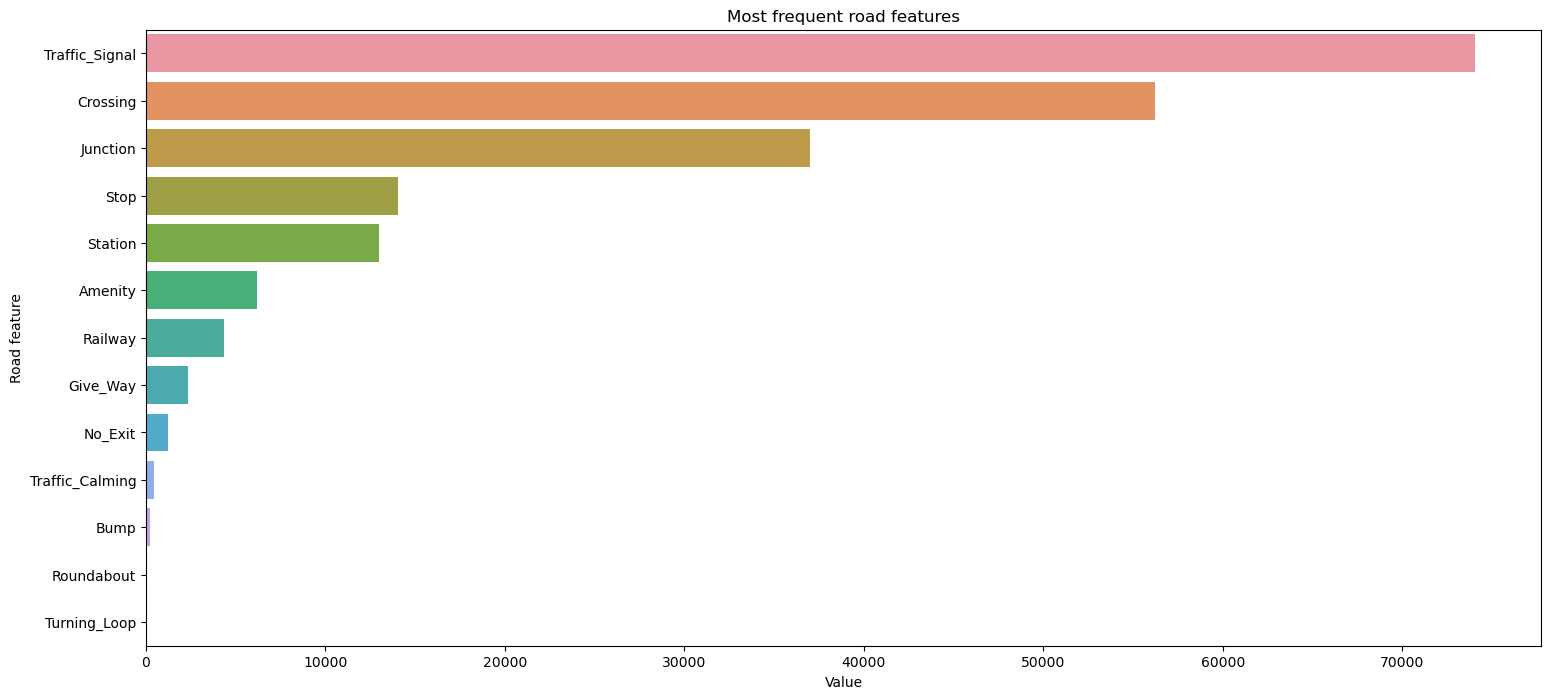

In [560]:
road_features = ["Amenity", "Bump", "Crossing", "Give_Way", "Junction", "No_Exit", "Railway", "Roundabout", "Station", "Stop", "Traffic_Calming", "Traffic_Signal", "Turning_Loop"]
road_data = data[road_features].sum().sort_values(ascending=False)

plt.figure(figsize=(18, 8))
plt.title("Most frequent road features")
sns.barplot(x=road_data.values, y=road_data.index, orient="h")
plt.xlabel("Value")
plt.ylabel("Road feature")
plt.show()

# Number of accidents happened on every weekday

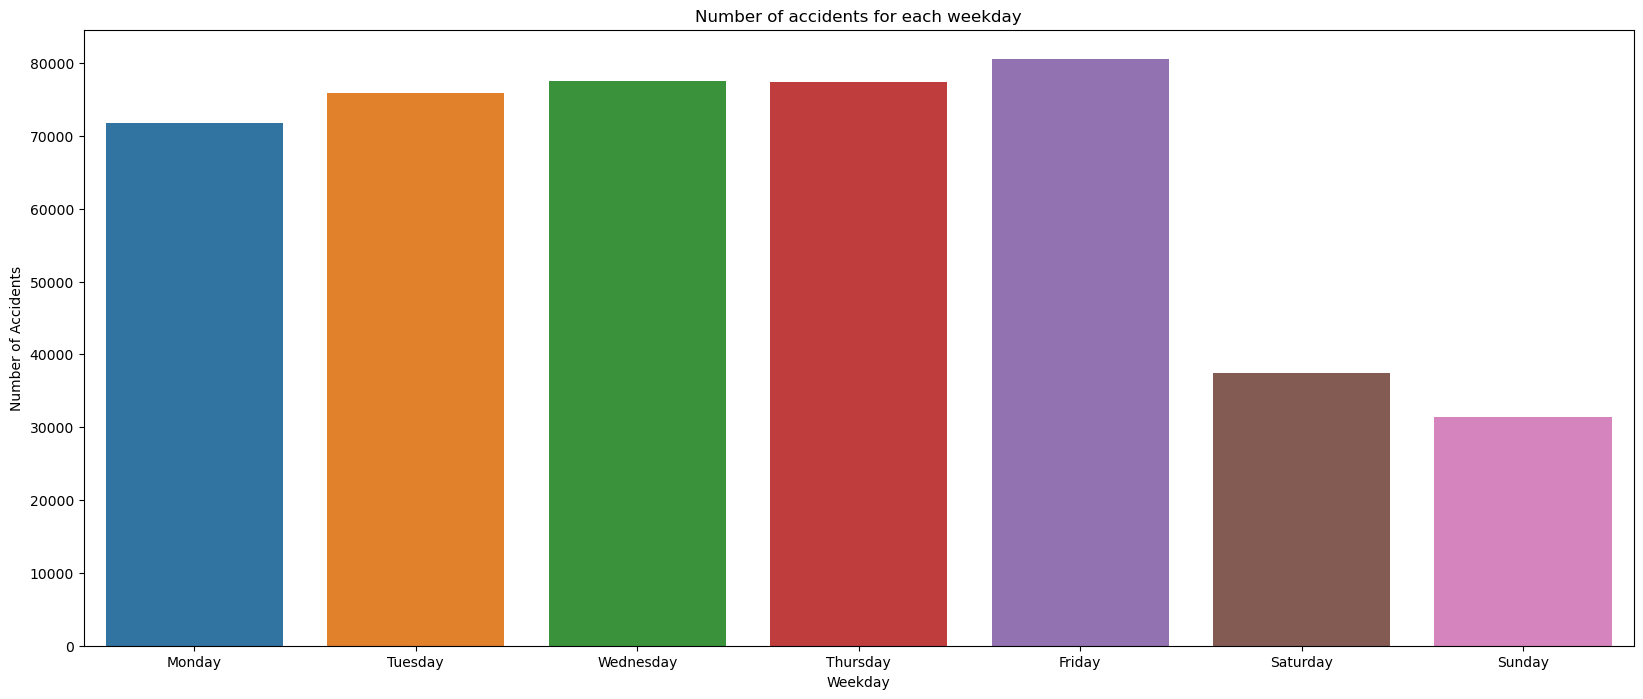

In [561]:
counts = pd.to_datetime(data['Start_Time'], errors='coerce').dt.day_name().value_counts()
weekdays = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

plt.figure(figsize=(20, 8))
plt.title("Number of accidents for each weekday")
sns.barplot(x=counts.index, y=counts.values, order=weekdays)
plt.xlabel("Weekday")
plt.ylabel("Number of Accidents")
plt.show()


As we can see the days with most accidents are on working days, this may be due to the fact that during the weekend there are fewer cars on the road.

## Data Preprocessing

In [562]:
df = data
df.head()

,ID,Source,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),...,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-2047758,Source2,2,2019-06-12 10:10:56,2019-06-12 10:55:58,30.641211,-91.153481,NaN,NaN,0.000,...,False,False,False,False,True,False,Day,Day,Day,Day
1,A-4694324,Source1,2,2022-12-03 23:37:14.000000000,2022-12-04 01:56:53.000000000,38.990562,-77.399070,38.990037,-77.398282,0.056,...,False,False,False,False,False,False,Night,Night,Night,Night
2,A-5006183,Source1,2,2022-08-20 13:13:00.000000000,2022-08-20 15:22:45.000000000,34.661189,-120.492822,34.661189,-120.492442,0.022,...,False,False,False,False,True,False,Day,Day,Day,Day
3,A-4237356,Source1,2,2022-02-21 17:43:04,2022-02-21 19:43:23,43.680592,-92.993317,43.680574,-92.972223,1.054,...,False,False,False,False,False,False,Day,Day,Day,Day
4,A-6690583,Source1,2,2020-12-04 01:46:00,2020-12-04 04:13:09,35.395484,-118.985176,35.395476,-118.985995,0.046,...,False,False,False,False,False,False,Night,Night,Night,Night


Feature Addition

Decompose the Start_Time feature in year, month, day, weekday, hour and minute

In [563]:
# Cast Start_Time to datetime
df["Start_Time"] = pd.to_datetime(df["Start_Time"], errors='coerce')

# Extract year, month, weekday and day
df["Year"] = df["Start_Time"].dt.year
df["Month"] = df["Start_Time"].dt.month
df["Weekday"] = df["Start_Time"].dt.weekday
df["Day"] = df["Start_Time"].dt.day

# Extract hour and minute
df["Hour"] = df["Start_Time"].dt.hour
df["Minute"] = df["Start_Time"].dt.minute

df.head()

,ID,Source,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),...,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight,Year,Month,Weekday,Day,Hour,Minute
0,A-2047758,Source2,2,2019-06-12 10:10:56,2019-06-12 10:55:58,30.641211,-91.153481,NaN,NaN,0.000,...,Day,Day,Day,Day,2019.0,6.0,2.0,12.0,10.0,10.0
1,A-4694324,Source1,2,NaT,2022-12-04 01:56:53.000000000,38.990562,-77.399070,38.990037,-77.398282,0.056,...,Night,Night,Night,Night,NaN,NaN,NaN,NaN,NaN,NaN
2,A-5006183,Source1,2,NaT,2022-08-20 15:22:45.000000000,34.661189,-120.492822,34.661189,-120.492442,0.022,...,Day,Day,Day,Day,NaN,NaN,NaN,NaN,NaN,NaN
3,A-4237356,Source1,2,2022-02-21 17:43:04,2022-02-21 19:43:23,43.680592,-92.993317,43.680574,-92.972223,1.054,...,Day,Day,Day,Day,2022.0,2.0,0.0,21.0,17.0,43.0
4,A-6690583,Source1,2,2020-12-04 01:46:00,2020-12-04 04:13:09,35.395484,-118.985176,35.395476,-118.985995,0.046,...,Night,Night,Night,Night,2020.0,12.0,4.0,4.0,1.0,46.0


Splitting the huge data into numerical and object data types for proper data exploration

In [564]:
df_obj = df.select_dtypes(include = ['object'])
df_num = df.select_dtypes(exclude = ['object'])

print(len(df_obj.columns), len(df_num.columns))

19 33


In [565]:
df_obj_nunique = df_obj.nunique().reset_index()
df_obj_nunique.columns = ['columns_name','unique_value_count']
df_obj_nunique['unique_ratio'] = df_obj_nunique['unique_value_count']/df.shape[0]
df_obj_nunique.sort_values(by='unique_ratio', ascending =False)

,columns_name,unique_value_count,unique_ratio
0,ID,500000,1.000000
2,End_Time,493821,0.987642
3,Description,408146,0.816292
12,Weather_Timestamp,255623,0.511246
8,Zipcode,127804,0.255608
4,Street,88272,0.176544
5,City,9488,0.018976
11,Airport_Code,1878,0.003756
6,County,1606,0.003212
14,Weather_Condition,108,0.000216


In [566]:
df_num_nunique = df_num.nunique().reset_index()
df_num_nunique.columns = ['columns_name','unique_value_count']
df_num_nunique['unique_ratio'] = df_num_nunique['unique_value_count']/df.shape[0]
df_num_nunique.sort_values(by='unique_ratio', ascending =False)

,columns_name,unique_value_count,unique_ratio
1,Start_Time,439824,0.879648
3,Start_Lng,370195,0.740390
2,Start_Lat,368965,0.737930
5,End_Lng,221463,0.442926
4,End_Lat,220333,0.440666
6,Distance(mi),10627,0.021254
10,Pressure(in),980,0.001960
8,Wind_Chill(F),797,0.001594
7,Temperature(F),712,0.001424
13,Precipitation(in),175,0.000350


In [567]:
df_missing = df_num.isnull().sum(axis = 0).reset_index()
df_missing.columns = ['columns_name', 'missing_count']
df_missing['missing_ratio'] = df_missing['missing_count']/df.shape[0]
df_missing.query('missing_ratio > 0').sort_values(by = 'missing_ratio',ascending=False)

,columns_name,missing_count,missing_ratio
4,End_Lat,220377,0.440754
5,End_Lng,220377,0.440754
13,Precipitation(in),142616,0.285232
8,Wind_Chill(F),129017,0.258034
1,Start_Time,48163,0.096326
27,Year,48163,0.096326
28,Month,48163,0.096326
29,Weekday,48163,0.096326
30,Day,48163,0.096326
31,Hour,48163,0.096326


In [568]:
df_missing = df_obj.isnull().sum(axis = 0).reset_index()
df_missing.columns = ['columns_name', 'missing_count']
df_missing['missing_ratio'] = df_missing['missing_count']/df.shape[0]
df_missing.query('missing_ratio > 0').sort_values(by = 'missing_ratio',ascending=False)

,columns_name,missing_count,missing_ratio
13,Wind_Direction,11197,0.022394
14,Weather_Condition,11101,0.022202
12,Weather_Timestamp,7674,0.015348
15,Sunrise_Sunset,1483,0.002966
16,Civil_Twilight,1483,0.002966
17,Nautical_Twilight,1483,0.002966
18,Astronomical_Twilight,1483,0.002966
11,Airport_Code,1446,0.002892
4,Street,691,0.001382
10,Timezone,507,0.001014


From the object columns

->Remove Country: Every instance is of only America, so this column doesn't provide any useful information
->Remove Description: (Can't be used for regression task) # After visualizing it.
->Impute the missing entries via the most-frequent value in that column
->Encode sun-light related and timezones columns

From the numerical columns

->Remove the Turning Loop: All instances have same value, gives no variance to dataset
->Remove End_Lat, End_Lng, Precipitation, Wind Chill Columns as they have many missing values
->Remove all the cols that are very less correlated to the Severity Column

For simplicity we are considering columns to be independent from the Severity target so if there is less variance in a column we will remove it.

In [569]:
df_clean = data[[col for col in data.columns if col not in ['End_Lat','End_Lng', 'Precipitation(in)', 'Wind_Chill(F)', 'Turning_Loop', 'Country']]]
df_clean_obj = df_clean.select_dtypes(include = ['object'])
df_clean_num = df_clean.select_dtypes(exclude = ['object','datetime64'])

print(len(df_clean_obj.columns),len(df_clean_num.columns))

18 27


Drop duplicates


In this section we are going to check if there are some duplicates in the dataset.

In [570]:
print("Number of rows:", len(df.index))
df.drop_duplicates(inplace=True)
print("Number of rows after drop of duplicates:", len(df.index))

Number of rows: 500000
Number of rows after drop of duplicates: 500000


Perform simple imputation on the data

In [571]:
# # Using the vectorized version above to speed up the process instead of this.
# Performing simple imputation on numerical and object cols
obj_imputer = SimpleImputer(strategy = 'most_frequent')
df_cl_obj = pd.DataFrame(obj_imputer.fit_transform(df_clean_obj),columns=df_clean_obj.columns, index=df_clean_obj.index)
# df_cl_obj.head()

In [572]:
num_imputer = SimpleImputer(strategy = 'mean')
df_cl_num = pd.DataFrame(num_imputer.fit_transform(df_clean_num),columns=df_clean_num.columns, index=df_clean_num.index)
# df_cl_num.head()

In [573]:
df_clean_num = df_cl_num
df_clean_obj = df_cl_obj

In [574]:
df_clean_obj.columns

Index(['ID', 'Source', 'End_Time', 'Description', 'Street', 'City', 'County',
       'State', 'Zipcode', 'Timezone', 'Airport_Code', 'Weather_Timestamp',
       'Wind_Direction', 'Weather_Condition', 'Sunrise_Sunset',
       'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight'],
      dtype='object')

In [575]:
# Example column names to move
columns_to_move = ['Year', 'Day', 'Hour', 'Minute', 'Month', 'Weekday' ]

# Add these columns to df_clean_obj
df_clean_obj = pd.concat([df_clean_obj, df_clean_num[columns_to_move]], axis=1)

# Remove these columns from df_clean_num
df_clean_num = df_clean_num.drop(columns_to_move, axis=1)


Doing Encoding of few Categorical columns

In [576]:
## Convert Dtypes for faster processing of dataset
obj_dtypes = {'Source':'category',
        'Description':'string', 
        'Street':'category',
        'City':'category', 
        'County':'category',
        'State':'category', 
        'Zipcode':'category',
#         'Timezone':'uint8',
        'Airport_Code':'category',
        'Weather_Timestamp':'string',
        'Wind_Direction':'category',
        'Weather_Condition':'string',
        'Sunrise_Sunset':'bool',
        'Civil_Twilight':'bool',
        'Nautical_Twilight':'bool', 
        'Astronomical_Twilight':'bool',
#         'End_Time':'datetime64[ns]',
        'Year':'uint16',
        'Day':'uint8',
        'Hour':'uint8',
        'Minute': 'uint8',
        'Weekday': 'category',
        'Month':'category'}

num_dtypes = { 'Severity':'uint8',
            'Start_Lat': 'float32',
            'Start_Lng': 'float32',
            'Distance(mi)': 'float32',
            'Temperature(F)': 'float32',
            'Humidity(%)': 'float32',
            'Pressure(in)': 'float32',
            'Visibility(mi)': 'float32',
            'Wind_Speed(mph)': 'float32',
            'Amenity':'bool',
            'Bump':"bool",
            'Crossing':'bool',
            'Give_Way':'bool',
            'Junction':'bool',
            'No_Exit':'bool',
            'Railway':'bool',
            'Roundabout':'bool',
            'Station':'bool', 
            'Stop':'bool',
            'Traffic_Calming':'bool',
            'Traffic_Signal':'bool',
             }
df_clean_obj = df_clean_obj.astype(obj_dtypes)
df_clean_num = df_clean_num.astype(num_dtypes)

In [577]:
df_clean = pd.concat([df_clean_num,df_clean_obj],axis = 1)
df_clean.head()

,Severity,Start_Lat,Start_Lng,Distance(mi),Temperature(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph),Amenity,...,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight,Year,Day,Hour,Minute,Month,Weekday
0,2,30.641211,-91.153481,0.000,77.0,62.0,29.920000,10.0,5.0,False,...,True,True,True,True,2019,12,10,10,6.000000,2.000000
1,2,38.990562,-77.399071,0.056,45.0,48.0,29.910000,10.0,5.0,False,...,True,True,True,True,2019,15,12,29,6.743616,2.568955
2,2,34.661190,-120.492821,0.022,68.0,73.0,29.790001,10.0,13.0,False,...,True,True,True,True,2019,15,12,29,6.743616,2.568955
3,2,43.680592,-92.993317,1.054,27.0,86.0,28.490000,10.0,15.0,False,...,True,True,True,True,2022,21,17,43,2.000000,0.000000
4,2,35.395485,-118.985176,0.046,42.0,34.0,29.770000,10.0,0.0,False,...,True,True,True,True,2020,4,1,46,12.000000,4.000000


In [578]:
df_clean.shape

(500000, 45)

In [579]:
df_clean.describe()

,Severity,Start_Lat,Start_Lng,Distance(mi),Temperature(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph),Year,Day,Hour,Minute
count,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000
mean,2.212748,36.206429,-94.736595,0.564318,61.646244,64.834923,29.536621,9.091541,7.681345,2019.632126,15.682296,12.234494,29.752666
std,0.486661,5.071212,17.405088,1.776309,18.797266,22.569168,0.999407,2.673968,5.224856,1.806541,8.252556,5.189944,16.407944
min,1.000000,24.562117,-124.497421,0.000000,-77.800003,1.000000,0.120000,0.000000,0.000000,2016.000000,1.000000,0.000000,0.000000
25%,2.000000,33.416823,-117.233046,0.000000,50.000000,49.000000,29.379999,10.000000,5.000000,2018.000000,9.000000,8.000000,17.000000
50%,2.000000,35.832148,-87.794365,0.029000,63.000000,66.000000,29.850000,10.000000,7.681346,2020.000000,15.000000,12.000000,29.000000
75%,2.000000,40.082443,-80.359600,0.465000,76.000000,84.000000,30.030001,10.000000,10.000000,2021.000000,22.000000,16.000000,43.000000
max,4.000000,48.999569,-67.484131,193.479996,207.000000,100.000000,38.439999,130.000000,822.799988,2023.000000,31.000000,23.000000,59.000000


In [580]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 45 columns):
 #   Column                 Non-Null Count   Dtype   
---  ------                 --------------   -----   
 0   Severity               500000 non-null  uint8   
 1   Start_Lat              500000 non-null  float32 
 2   Start_Lng              500000 non-null  float32 
 3   Distance(mi)           500000 non-null  float32 
 4   Temperature(F)         500000 non-null  float32 
 5   Humidity(%)            500000 non-null  float32 
 6   Pressure(in)           500000 non-null  float32 
 7   Visibility(mi)         500000 non-null  float32 
 8   Wind_Speed(mph)        500000 non-null  float32 
 9   Amenity                500000 non-null  bool    
 10  Bump                   500000 non-null  bool    
 11  Crossing               500000 non-null  bool    
 12  Give_Way               500000 non-null  bool    
 13  Junction               500000 non-null  bool    
 14  No_Exit             

In [581]:
### Seeing the nullness of all the attributes
df_missing = df_clean.isnull().sum(axis = 0).reset_index()
df_missing.columns = ['columns_name', 'missing_count']
df_missing['missing_ratio'] = df_missing['missing_count']/df_clean.shape[0]
df_missing['data_type'] = [df_clean[col].dtypes for col in df_missing.columns_name[:]]
df_missing.query('missing_ratio > 0').sort_values(by = ['missing_ratio','data_type'], ascending = False)

,columns_name,missing_count,missing_ratio,data_type


In [582]:
df_clean.columns

Index(['Severity', 'Start_Lat', 'Start_Lng', 'Distance(mi)', 'Temperature(F)',
       'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Speed(mph)',
       'Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit',
       'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming',
       'Traffic_Signal', 'ID', 'Source', 'End_Time', 'Description', 'Street',
       'City', 'County', 'State', 'Zipcode', 'Timezone', 'Airport_Code',
       'Weather_Timestamp', 'Wind_Direction', 'Weather_Condition',
       'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight',
       'Astronomical_Twilight', 'Year', 'Day', 'Hour', 'Minute', 'Month',
       'Weekday'],
      dtype='object')

In [583]:
df_clean = df_clean.drop(['Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight'], axis=1)


# Check correlation between features

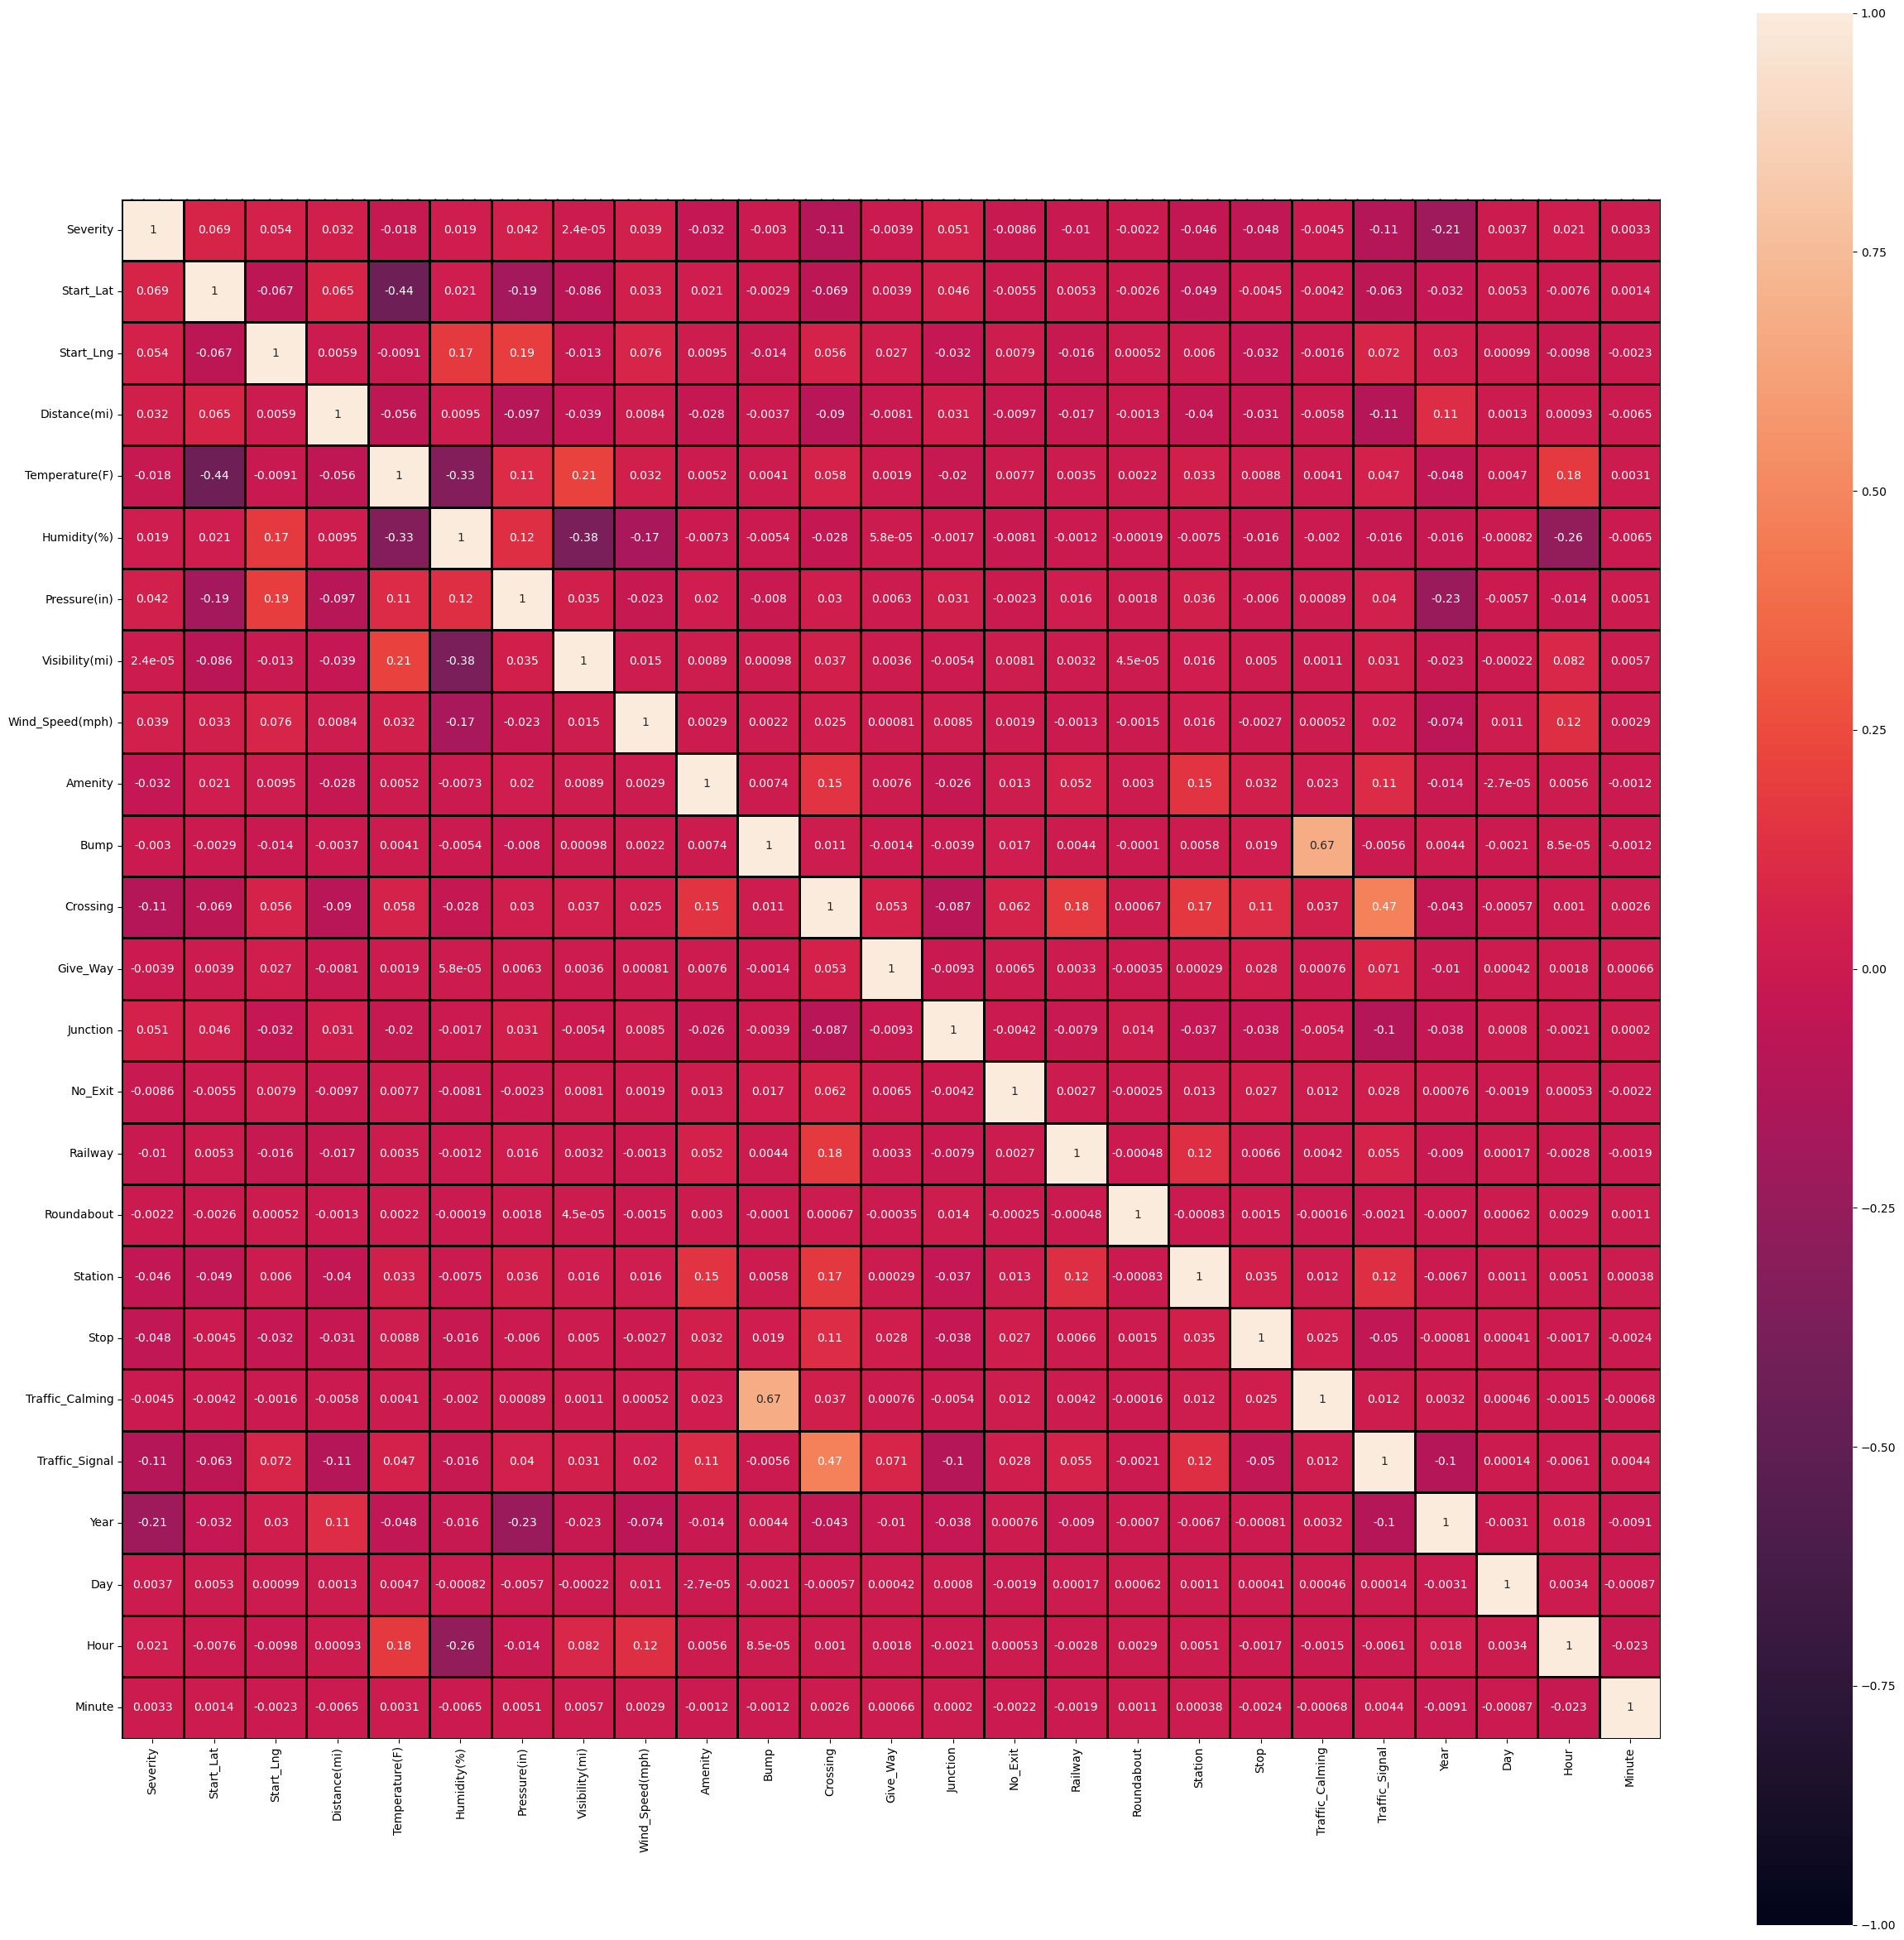

In [584]:
corr_matrix = df_clean.corr(numeric_only=True)
plt.figure(figsize=(30, 30))
sns.heatmap(corr_matrix,annot=True,linewidths=1,linecolor='k',square=True,mask=False, vmin=-1, vmax=1,cbar_kws={"orientation": "vertical"},cbar=True)
plt.gca().patch.set(hatch="X", edgecolor="#666")
plt.show()

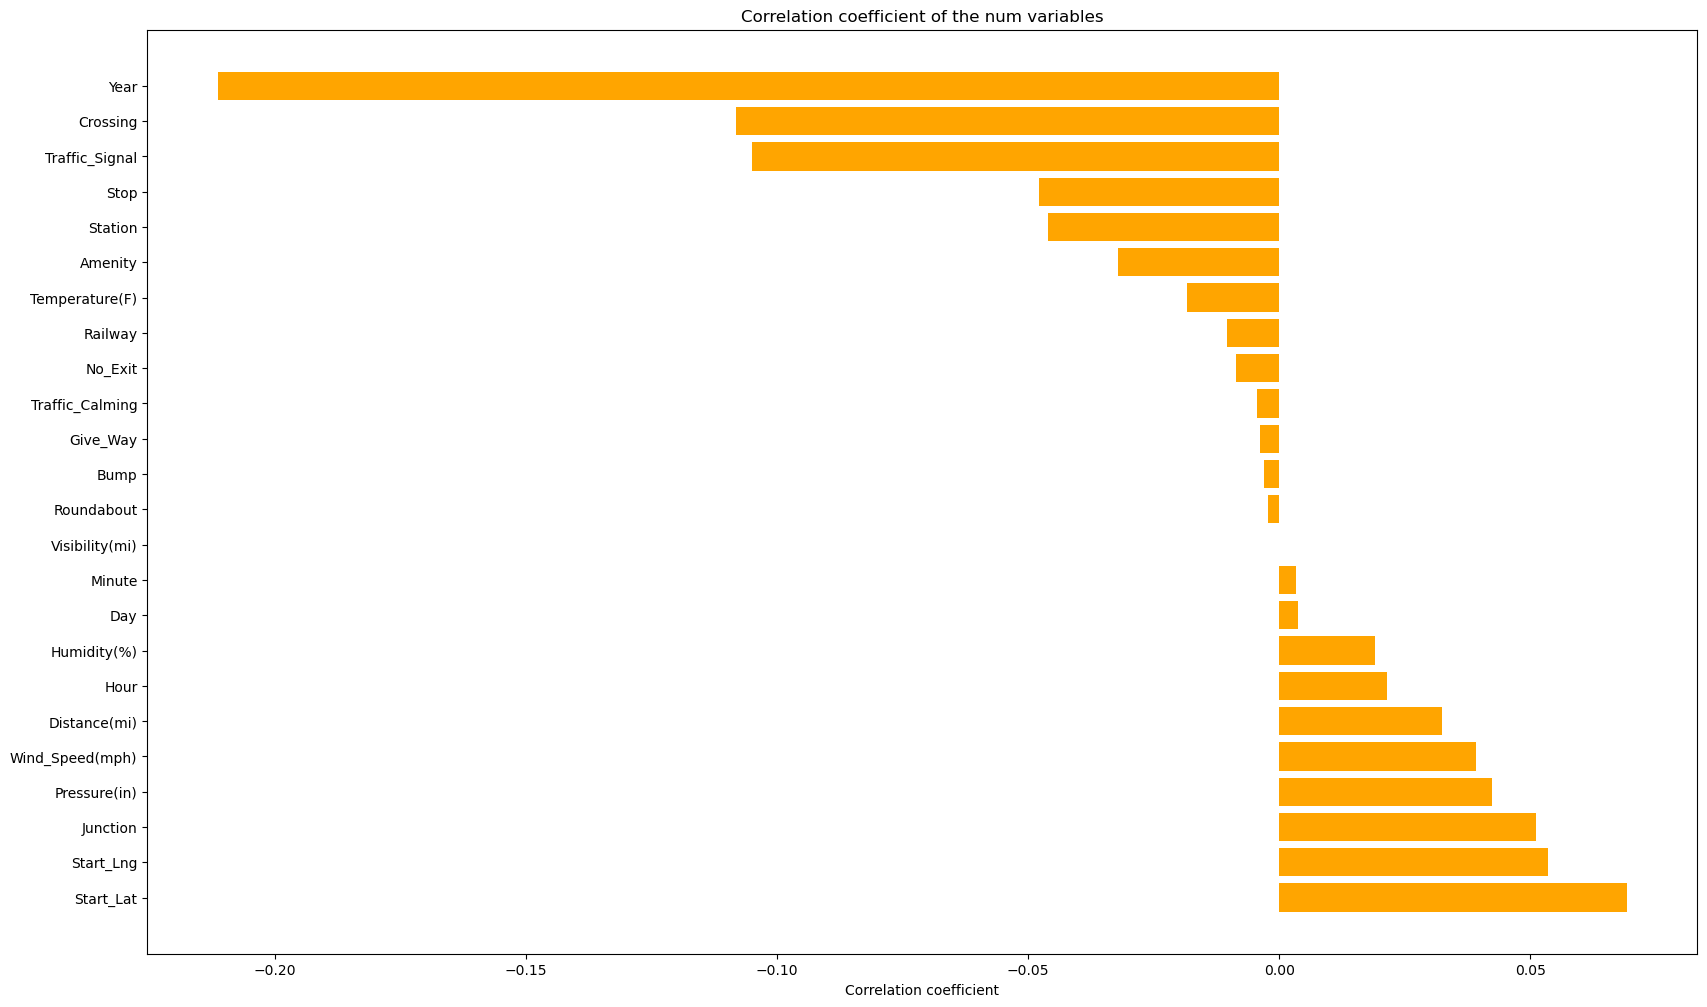

In [585]:
### Correlation between num features wrt the target attributes
x_cols = [col for col in df_clean.columns if col not in ['Severity'] if df_clean[col].dtype in ['float32','uint8','bool','uint16']]

labels = []
values = []
for col in x_cols:
    labels.append(col)
    values.append(np.corrcoef(df_clean[col].values, df_clean.Severity.values)[0,1])
corr_df = pd.DataFrame({'col_labels':labels, 'corr_values':values})
corr_df = (corr_df.sort_values(by='corr_values',ascending = False)).reset_index()
corr_df

ind = np.arange(len(labels))
width = 0.9
fig, ax = plt.subplots(figsize=(20,12))
rects = ax.barh(ind, np.array(corr_df.corr_values.values), color='orange')
ax.set_yticks(ind)
ax.set_yticklabels(corr_df.col_labels.values, rotation='horizontal')
ax.set_xlabel("Correlation coefficient")
ax.set_title("Correlation coefficient of the num variables")
plt.show()

Observations

We remove most of the features that have a less than or equal to +/- 0.01 coorelation to Severity

In [586]:
# All these less correlated features will be removed
less_corr_features = corr_df[(corr_df.corr_values>=-0.01) & (corr_df.corr_values<=0.01)].col_labels[:]
less_corr = less_corr_features.to_list()
less_corr

['Day',
 'Minute',
 'Visibility(mi)',
 'Roundabout',
 'Bump',
 'Give_Way',
 'Traffic_Calming',
 'No_Exit']

# Observing Year wise distribution of Accidents for every level of Severity

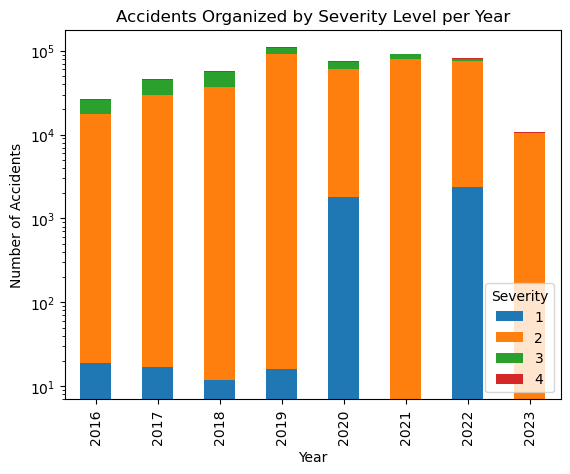

In [587]:
# Perform groupby operation
grouped = df_clean.groupby(['Year', 'Severity'])['Start_Lat'].count()

# Convert the result to a DataFrame
df_pivot = grouped.reset_index()

# Pivot the DataFrame
df_pivot = df_pivot.pivot(index='Year', columns='Severity', values='Start_Lat')

# Display the pivoted DataFrame
#print(df_pivot)

# Plot the stacked bar chart
ax = df_pivot.plot.bar(stacked=True)

# Set the y-axis scale to logarithmic
ax.set_yscale("log")
# Set the title and axis labels
plt.title("Accidents Organized by Severity Level per Year")
plt.xlabel("Year")
plt.ylabel("Number of Accidents")
plt.savefig("Accidents_Organized_by_Severity_Level_per_Year.png",bbox_inches = 'tight', dpi = 300)
# Show the plot
plt.show()

Observations

-> Over the years we have more number of accidents but with accidents are becoming less severe

-> Another observation we can make that accident's are increasing over the years

# Feature selection

We drop all the less correlated columns

We drop descriptions, as most descriptions only report the name of the road of the accident, so dropping it ensures simplicity

We drop street, county, zipcode, state and only keep city to focus as a mid data point from all the spatial features having just enough values to be numerically encoded

We drop Airport_Code, Weather_Timestamp because they are not useful much for our task

We drop Start and End Time, because we have the same information in Hr itself.


In [588]:
dropped_cols = less_corr + ["Description",'ID','Street','County','Zipcode','State','Airport_Code','Weather_Timestamp','End_Time']
dropped_cols

['Day',
 'Minute',
 'Visibility(mi)',
 'Roundabout',
 'Bump',
 'Give_Way',
 'Traffic_Calming',
 'No_Exit',
 'Description',
 'ID',
 'Street',
 'County',
 'Zipcode',
 'State',
 'Airport_Code',
 'Weather_Timestamp',
 'End_Time']

In [589]:
df_clean = df_clean.drop(dropped_cols,axis = 1)

In [590]:
df_clean.head()

,Severity,Start_Lat,Start_Lng,Distance(mi),Temperature(F),Humidity(%),Pressure(in),Wind_Speed(mph),Amenity,Crossing,...,Traffic_Signal,Source,City,Timezone,Wind_Direction,Weather_Condition,Year,Hour,Month,Weekday
0,2,30.641211,-91.153481,0.000,77.0,62.0,29.920000,5.0,False,False,...,True,Source2,Zachary,US/Central,NW,Fair,2019,10,6.000000,2.000000
1,2,38.990562,-77.399071,0.056,45.0,48.0,29.910000,5.0,False,False,...,False,Source1,Sterling,US/Eastern,W,Fair,2019,12,6.743616,2.568955
2,2,34.661190,-120.492821,0.022,68.0,73.0,29.790001,13.0,False,False,...,True,Source1,Lompoc,US/Pacific,W,Fair,2019,12,6.743616,2.568955
3,2,43.680592,-92.993317,1.054,27.0,86.0,28.490000,15.0,False,False,...,False,Source1,Austin,US/Central,ENE,Wintry Mix,2022,17,2.000000,0.000000
4,2,35.395485,-118.985176,0.046,42.0,34.0,29.770000,0.0,False,False,...,False,Source1,Bakersfield,US/Pacific,CALM,Fair,2020,1,12.000000,4.000000


In [591]:
df_clean.describe().round(3)

,Severity,Start_Lat,Start_Lng,Distance(mi),Temperature(F),Humidity(%),Pressure(in),Wind_Speed(mph),Year,Hour
count,500000.000,500000.000,500000.000,500000.000,500000.000,500000.000,500000.000,500000.000,500000.000,500000.000
mean,2.213,36.206,-94.737,0.564,61.646,64.835,29.537,7.681,2019.632,12.234
std,0.487,5.071,17.405,1.776,18.797,22.569,0.999,5.225,1.807,5.190
min,1.000,24.562,-124.497,0.000,-77.800,1.000,0.120,0.000,2016.000,0.000
25%,2.000,33.417,-117.233,0.000,50.000,49.000,29.380,5.000,2018.000,8.000
50%,2.000,35.832,-87.794,0.029,63.000,66.000,29.850,7.681,2020.000,12.000
75%,2.000,40.082,-80.360,0.465,76.000,84.000,30.030,10.000,2021.000,16.000
max,4.000,49.000,-67.484,193.480,207.000,100.000,38.440,822.800,2023.000,23.000


In [592]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 24 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   Severity           500000 non-null  uint8   
 1   Start_Lat          500000 non-null  float32 
 2   Start_Lng          500000 non-null  float32 
 3   Distance(mi)       500000 non-null  float32 
 4   Temperature(F)     500000 non-null  float32 
 5   Humidity(%)        500000 non-null  float32 
 6   Pressure(in)       500000 non-null  float32 
 7   Wind_Speed(mph)    500000 non-null  float32 
 8   Amenity            500000 non-null  bool    
 9   Crossing           500000 non-null  bool    
 10  Junction           500000 non-null  bool    
 11  Railway            500000 non-null  bool    
 12  Station            500000 non-null  bool    
 13  Stop               500000 non-null  bool    
 14  Traffic_Signal     500000 non-null  bool    
 15  Source             500000 non-null

# Categorizing the categorical columns

In [593]:
unique_weather = (df_clean["Weather_Condition"].unique())

print(len(unique_weather))
print(list((unique_weather)))

108
['Fair', 'Wintry Mix', 'Light Rain', 'Cloudy', 'Mostly Cloudy', 'Partly Cloudy', 'Clear', 'Scattered Clouds', 'Fog', 'Overcast', 'Light Snow', 'T-Storm', 'Thunderstorms and Rain', 'Thunder', 'Light Rain with Thunder', 'Rain', 'Showers in the Vicinity', 'Mostly Cloudy / Windy', 'Heavy Rain', 'Cloudy / Windy', 'Light Drizzle', 'Heavy T-Storm', 'Light Rain / Windy', 'Smoke', 'Haze', 'Blowing Dust / Windy', 'N/A Precipitation', 'Thunder in the Vicinity', 'Snow', 'Heavy Thunderstorms and Rain', 'Shallow Fog', 'Light Freezing Drizzle', 'Fair / Windy', 'Patches of Fog', 'Light Snow / Windy', 'Blowing Snow / Windy', 'Thunderstorm', 'Drizzle', 'T-Storm / Windy', 'Partly Cloudy / Windy', 'Heavy Rain / Windy', 'Heavy Snow / Windy', 'Mist', 'Light Thunderstorms and Rain', 'Rain / Windy', 'Light Freezing Rain', 'Heavy Snow', 'Light Ice Pellets', 'Heavy T-Storm / Windy', 'Heavy Drizzle', 'Sleet', 'Light Rain Shower', 'Haze / Windy', 'Snow and Sleet', 'Snow / Windy', 'Fog / Windy', 'Light Freezin

In [594]:
# Categorizing the weather conditions
#Assign categories based on weather conditions
df_clean.loc[df_clean["Weather_Condition"].str.contains("Rain|Drizzle|Shower|Precipitation", na=False), "Weather_Condition"] = "Rain"
df_clean.loc[df_clean["Weather_Condition"].str.contains("Cloudy|Overcast", na=False), "Weather_Condition"] = "Cloudy"
df_clean.loc[df_clean["Weather_Condition"].str.contains("Snow|Sleet|Wintry", na=False), "Weather_Condition"] = "Snow"
df_clean.loc[df_clean["Weather_Condition"].str.contains("Fog|Mist", na=False), "Weather_Condition"] = "Fog"
df_clean.loc[df_clean["Weather_Condition"].str.contains("Clear|Fair", na=False), "Weather_Condition"] = "Clear"
df_clean.loc[df_clean["Weather_Condition"].str.contains("Smoke|Volcanic Ash", na=False), "Weather_Condition"] = "Smoke"
df_clean.loc[df_clean["Weather_Condition"].str.contains("Thunder|T-Storm", na=False), "Weather_Condition"] = "Thunderstorm"
df_clean.loc[df_clean["Weather_Condition"].str.contains("Sand|Dust", na=False), "Weather_Condition"] = "Sand"
df_clean.loc[df_clean["Weather_Condition"].str.contains("Wind|Squalls", na=False), "Weather_Condition"] = "Windy"
df_clean.loc[df_clean["Weather_Condition"].str.contains("Hail|Pellets", na=False), "Weather_Condition"] = "Hail"

df_clean["Weather_Condition"] = df_clean["Weather_Condition"].astype('category')

In [595]:
df_clean.Weather_Condition.value_counts()

Weather_Condition
Clear               231894
Cloudy              191388
Rain                 35105
Scattered Clouds     13030
Snow                 11054
Fog                   7241
Haze                  4967
Thunderstorm          4284
Smoke                  813
Windy                  126
Sand                    53
Hail                    37
Funnel Cloud             6
Light Haze               1
Tornado                  1
Name: count, dtype: int64

In [596]:
# Categorizing the wind direction 
df_clean["Wind_Direction"].unique().to_list()

['NW',
 'W',
 'ENE',
 'CALM',
 'SW',
 'VAR',
 'S',
 'E',
 'WSW',
 'NNE',
 'Variable',
 'West',
 'N',
 'ESE',
 'NNW',
 'North',
 'SSW',
 'WNW',
 'NE',
 'Calm',
 'SE',
 'East',
 'SSE',
 'South']

In [597]:
conditions = [
    df_clean['Wind_Direction'].str.contains('N', case=False, na=False),
    df_clean['Wind_Direction'].str.contains('S', case=False, na=False),
    df_clean['Wind_Direction'].str.contains('E', case=False, na=False),
    df_clean['Wind_Direction'].str.contains('W', case=False, na=False),
    df_clean['Wind_Direction'].str.contains('V|C', case=False, na=False)
]

choices = ['North', 'South', 'East', 'West', 'Variable']
df_clean['Wind_Direction'] = np.select(conditions, choices, default=df_clean['Wind_Direction'])

df_clean['Wind_Direction'] = df_clean['Wind_Direction'].astype('category')

In [598]:
df_clean["Wind_Direction"].unique().to_list()

['North', 'West', 'Variable', 'South', 'East']

In [599]:
df_clean.isna().sum()

Severity             0
Start_Lat            0
Start_Lng            0
Distance(mi)         0
Temperature(F)       0
Humidity(%)          0
Pressure(in)         0
Wind_Speed(mph)      0
Amenity              0
Crossing             0
Junction             0
Railway              0
Station              0
Stop                 0
Traffic_Signal       0
Source               0
City                 0
Timezone             0
Wind_Direction       0
Weather_Condition    0
Year                 0
Hour                 0
Month                0
Weekday              0
dtype: int64

In [600]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 24 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   Severity           500000 non-null  uint8   
 1   Start_Lat          500000 non-null  float32 
 2   Start_Lng          500000 non-null  float32 
 3   Distance(mi)       500000 non-null  float32 
 4   Temperature(F)     500000 non-null  float32 
 5   Humidity(%)        500000 non-null  float32 
 6   Pressure(in)       500000 non-null  float32 
 7   Wind_Speed(mph)    500000 non-null  float32 
 8   Amenity            500000 non-null  bool    
 9   Crossing           500000 non-null  bool    
 10  Junction           500000 non-null  bool    
 11  Railway            500000 non-null  bool    
 12  Station            500000 non-null  bool    
 13  Stop               500000 non-null  bool    
 14  Traffic_Signal     500000 non-null  bool    
 15  Source             500000 non-null

# Handling Unbalanced Data before encoding the categorical columns

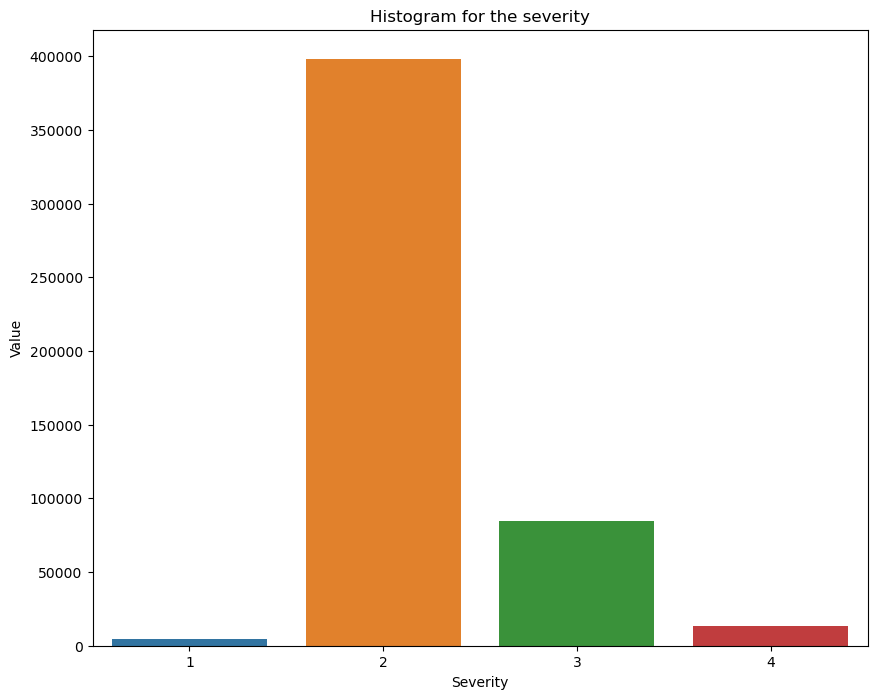

In [601]:
severity_counts = df_clean["Severity"].value_counts()

plt.figure(figsize=(10, 8))
plt.title("Histogram for the severity")
sns.barplot(x = severity_counts.index,y=severity_counts.values)
plt.xlabel("Severity")
plt.ylabel("Value")
plt.savefig("UnBalanced_Severity.png",bbox_inches = 'tight', dpi = 300)
plt.show()

We can see we have highly unbalanced data wrt 2nd Severity level

To balance it, we will undersample the records to match the number of records of Severity level 1 i.e. the minority category

So we undersample 2, 3, 4 Severity level instances randomly to the minority category

In [602]:
size = len(df_clean[df_clean["Severity"]==1].index)
size

4274

In [603]:
x = pd.DataFrame()
for i in range(1,5):
    S = df_clean[df_clean["Severity"]==i]
    x = pd.concat([x,S.sample(size, random_state=42)],axis = 0)
df_balanced = x

In [604]:
df_balanced.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17096 entries, 450445 to 125724
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   Severity           17096 non-null  uint8   
 1   Start_Lat          17096 non-null  float32 
 2   Start_Lng          17096 non-null  float32 
 3   Distance(mi)       17096 non-null  float32 
 4   Temperature(F)     17096 non-null  float32 
 5   Humidity(%)        17096 non-null  float32 
 6   Pressure(in)       17096 non-null  float32 
 7   Wind_Speed(mph)    17096 non-null  float32 
 8   Amenity            17096 non-null  bool    
 9   Crossing           17096 non-null  bool    
 10  Junction           17096 non-null  bool    
 11  Railway            17096 non-null  bool    
 12  Station            17096 non-null  bool    
 13  Stop               17096 non-null  bool    
 14  Traffic_Signal     17096 non-null  bool    
 15  Source             17096 non-null  category
 16  Cit

In [605]:
df_balanced.shape

(17096, 24)

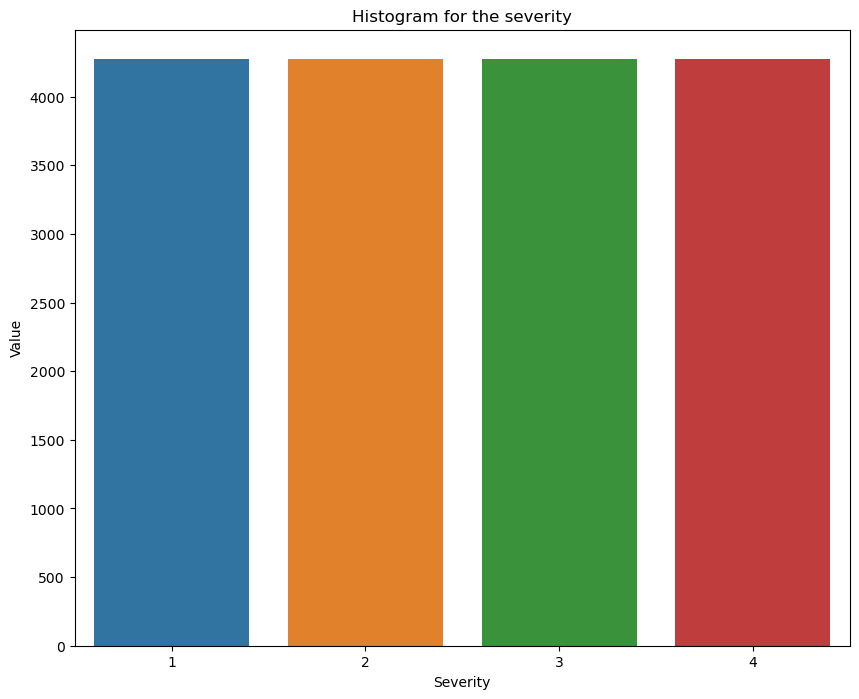

In [606]:
severity_counts = df_balanced["Severity"].value_counts()

plt.figure(figsize=(10, 8))
plt.title("Histogram for the severity")
sns.barplot(x = severity_counts.index,y=severity_counts.values)
plt.xlabel("Severity")
plt.ylabel("Value")
plt.savefig("Balanced_Severity.png",bbox_inches = 'tight', dpi = 300)
plt.show()

# Feature scaling

In [607]:
df_balanced = df_balanced.drop('Timezone', axis=1)

In [608]:
num_features = (df_balanced.select_dtypes(include = ['float32','uint8','uint16',],exclude = ['bool']).columns).to_list()
cat_features = (df_balanced.select_dtypes(exclude = ['float32','uint8','uint16','bool','int64']).columns).to_list()
bool_features = (df_balanced.select_dtypes(include= ['bool']).columns).to_list()

In [609]:
cat_features,num_features,bool_features

(['Source', 'City', 'Wind_Direction', 'Weather_Condition', 'Month', 'Weekday'],
 ['Severity',
  'Start_Lat',
  'Start_Lng',
  'Distance(mi)',
  'Temperature(F)',
  'Humidity(%)',
  'Pressure(in)',
  'Wind_Speed(mph)',
  'Year',
  'Hour'],
 ['Amenity',
  'Crossing',
  'Junction',
  'Railway',
  'Station',
  'Stop',
  'Traffic_Signal'])

In [610]:
num_features.remove("Severity")

In [611]:
scaler = MinMaxScaler()
#features = ['Temperature(F)','Distance(mi)','Humidity(%)','Pressure(in)','Visibility(mi)','Wind_Speed(,'Start_Lng','Start_Lat','Year', 'Month','Weekday','Day','Hour','Minute']
df_balanced[num_features] = scaler.fit_transform(df_balanced[num_features])
df_balanced

,Severity,Start_Lat,Start_Lng,Distance(mi),Temperature(F),Humidity(%),Pressure(in),Wind_Speed(mph),Amenity,Crossing,...,Stop,Traffic_Signal,Source,City,Wind_Direction,Weather_Condition,Year,Hour,Month,Weekday
450445,1,0.136360,0.748696,0.010445,0.765864,0.783505,0.931734,0.101695,False,False,...,False,False,Source1,Saint Petersburg,East,Clear,0.571442,0.434783,6.0,4.0
359205,1,0.059277,0.792555,0.000000,0.743982,0.762887,0.918819,0.101695,False,False,...,False,False,Source2,Hollywood,South,Clear,0.857147,0.217391,6.0,4.0
300014,1,0.776249,0.947045,0.000000,0.561634,0.412371,0.879151,0.152542,False,False,...,False,False,Source2,Tilton,West,Clear,0.857147,0.434783,5.0,3.0
487135,1,0.435799,0.782379,0.000000,0.707513,0.608247,0.862546,0.118644,False,False,...,False,False,Source2,Charlotte,North,Clear,0.857147,0.347826,9.0,3.0
341167,1,0.945320,0.037497,0.000000,0.561634,0.855670,0.914207,0.101695,False,True,...,False,True,Source1,Seattle,South,Rain,0.571442,0.304348,6.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
357959,4,0.581004,0.834235,0.006134,0.539752,0.886598,0.877306,0.084746,False,False,...,False,False,Source1,Warrenton,North,Rain,0.428589,0.217391,11.0,1.0
219019,4,0.626745,0.877593,0.028592,0.393873,0.350515,0.946494,0.389830,False,False,...,False,False,Source2,Claymont,North,Clear,0.714294,0.391304,3.0,1.0
381304,4,0.782490,0.229254,0.016562,0.656455,0.505155,0.477860,0.000000,False,False,...,False,False,Source1,Ririe,Variable,Clear,0.714294,0.391304,6.0,4.0
60915,4,0.862069,0.036076,0.012543,0.729395,0.432990,0.934502,0.130192,False,False,...,False,False,Source1,Fairview,Variable,Clear,0.142883,0.869565,5.0,6.0


# Encoding Categorical Cols

In [612]:
df_balanced = df_balanced.replace([True, False], [1, 0])
df_balanced[bool_features] = df_balanced[bool_features].astype('uint8')
df_balanced.head()

,Severity,Start_Lat,Start_Lng,Distance(mi),Temperature(F),Humidity(%),Pressure(in),Wind_Speed(mph),Amenity,Crossing,...,Stop,Traffic_Signal,Source,City,Wind_Direction,Weather_Condition,Year,Hour,Month,Weekday
450445,1,0.136360,0.748696,0.010445,0.765864,0.783505,0.931734,0.101695,0,0,...,0,0,Source1,Saint Petersburg,East,Clear,0.571442,0.434783,6.0,4.0
359205,1,0.059277,0.792555,0.000000,0.743982,0.762887,0.918819,0.101695,0,0,...,0,0,Source2,Hollywood,South,Clear,0.857147,0.217391,6.0,4.0
300014,1,0.776249,0.947045,0.000000,0.561634,0.412371,0.879151,0.152542,0,0,...,0,0,Source2,Tilton,West,Clear,0.857147,0.434783,5.0,3.0
487135,1,0.435799,0.782379,0.000000,0.707513,0.608247,0.862546,0.118644,0,0,...,0,0,Source2,Charlotte,North,Clear,0.857147,0.347826,9.0,3.0
341167,1,0.945320,0.037497,0.000000,0.561634,0.855670,0.914207,0.101695,0,1,...,0,1,Source1,Seattle,South,Rain,0.571442,0.304348,6.0,0.0


In [613]:
# Checkpoint creation of balanced dataset
name_p = "test.pickle"
df_balanced.to_pickle(name_p)

In [614]:
df_balanced = pd.read_pickle(name_p)

In [615]:
onehot_cols = list(set(cat_features) - set(["City"]))
onehot_cols

['Month', 'Weekday', 'Source', 'Weather_Condition', 'Wind_Direction']

In [616]:
df_balanced = pd.get_dummies(df_balanced, columns=onehot_cols, drop_first=True)
df_balanced.head()

,Severity,Start_Lat,Start_Lng,Distance(mi),Temperature(F),Humidity(%),Pressure(in),Wind_Speed(mph),Amenity,Crossing,...,Weather_Condition_Scattered Clouds,Weather_Condition_Smoke,Weather_Condition_Snow,Weather_Condition_Thunderstorm,Weather_Condition_Tornado,Weather_Condition_Windy,Wind_Direction_North,Wind_Direction_South,Wind_Direction_Variable,Wind_Direction_West
450445,1,0.136360,0.748696,0.010445,0.765864,0.783505,0.931734,0.101695,0,0,...,False,False,False,False,False,False,False,False,False,False
359205,1,0.059277,0.792555,0.000000,0.743982,0.762887,0.918819,0.101695,0,0,...,False,False,False,False,False,False,False,True,False,False
300014,1,0.776249,0.947045,0.000000,0.561634,0.412371,0.879151,0.152542,0,0,...,False,False,False,False,False,False,False,False,False,True
487135,1,0.435799,0.782379,0.000000,0.707513,0.608247,0.862546,0.118644,0,0,...,False,False,False,False,False,False,True,False,False,False
341167,1,0.945320,0.037497,0.000000,0.561634,0.855670,0.914207,0.101695,0,1,...,False,False,False,False,False,False,False,True,False,False


In [617]:
df_balanced.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17096 entries, 450445 to 125724
Data columns (total 57 columns):
 #   Column                              Non-Null Count  Dtype   
---  ------                              --------------  -----   
 0   Severity                            17096 non-null  uint8   
 1   Start_Lat                           17096 non-null  float32 
 2   Start_Lng                           17096 non-null  float32 
 3   Distance(mi)                        17096 non-null  float32 
 4   Temperature(F)                      17096 non-null  float32 
 5   Humidity(%)                         17096 non-null  float32 
 6   Pressure(in)                        17096 non-null  float32 
 7   Wind_Speed(mph)                     17096 non-null  float32 
 8   Amenity                             17096 non-null  uint8   
 9   Crossing                            17096 non-null  uint8   
 10  Junction                            17096 non-null  uint8   
 11  Railway                    

Now, remains only to encode the City feature. In order to, reduce the usage of memory and the number of features we used the BinaryEncoder included in the library category_encoders.

In [618]:
binary_encoder = ce.binary.BinaryEncoder()

city_binary_enc = binary_encoder.fit_transform(df_balanced["City"])
city_binary_enc

,City_0,City_1,City_2,City_3,City_4,City_5,City_6,City_7,City_8,City_9,City_10,City_11
450445,0,0,0,0,0,0,0,0,0,0,0,1
359205,0,0,0,0,0,0,0,0,0,0,1,0
300014,0,0,0,0,0,0,0,0,0,0,1,1
487135,0,0,0,0,0,0,0,0,0,1,0,0
341167,0,0,0,0,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
357959,0,1,0,1,0,1,1,0,1,0,0,1
219019,0,0,1,1,0,1,1,0,1,0,1,0
381304,1,1,1,0,0,1,0,0,0,1,1,0
60915,0,0,0,1,1,1,0,0,0,1,0,0


In [619]:
df_balanced = pd.concat([df_balanced, city_binary_enc], axis=1).drop("City", axis=1)

df_balanced.head()

,Severity,Start_Lat,Start_Lng,Distance(mi),Temperature(F),Humidity(%),Pressure(in),Wind_Speed(mph),Amenity,Crossing,...,City_2,City_3,City_4,City_5,City_6,City_7,City_8,City_9,City_10,City_11
450445,1,0.136360,0.748696,0.010445,0.765864,0.783505,0.931734,0.101695,0,0,...,0,0,0,0,0,0,0,0,0,1
359205,1,0.059277,0.792555,0.000000,0.743982,0.762887,0.918819,0.101695,0,0,...,0,0,0,0,0,0,0,0,1,0
300014,1,0.776249,0.947045,0.000000,0.561634,0.412371,0.879151,0.152542,0,0,...,0,0,0,0,0,0,0,0,1,1
487135,1,0.435799,0.782379,0.000000,0.707513,0.608247,0.862546,0.118644,0,0,...,0,0,0,0,0,0,0,1,0,0
341167,1,0.945320,0.037497,0.000000,0.561634,0.855670,0.914207,0.101695,0,1,...,0,0,0,0,0,0,0,1,0,1


In [620]:
df_balanced.to_pickle("final_df.pickle")

In [621]:
df_model = pd.read_pickle("final_df.pickle")

In [622]:
### Storing every models following metrics in dictionary
accuracy = dict()
precision = dict()
recall = dict()
f1 = dict()
fpr = dict() 
tpr = dict()
best_params = dict() #Storing the best parameters for models that use gridsearchCV
models = dict() # Storing the trained model in dictionary

In [623]:
# Train/Validation - Test split
X,X_test = train_test_split(df_model,test_size = .2, random_state = 42)
print(X.shape, X_test.shape)

(13676, 68) (3420, 68)


In [624]:
y = X["Severity"] # Separating the target variable from the dataset
y_test = X_test["Severity"]

In [625]:
X_model = X.drop(["Severity"],axis = 1) # Createing a df of only features

In [626]:
# Train/Validation Split
X_train, X_val, y_train, y_val = train_test_split(X_model,y,random_state = 42,test_size = 0.20)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(10940, 67) (2736, 67) (10940,) (2736,)


In [627]:
## We will run the grid search cv only on 24_000 samples, to use less compute but find the best params
## Doing this is necessary cause few model being complex like SVM take too much time to find best params 
X_sample = X.sample(10_000, random_state = 42)
y_sample_train = X_sample["Severity"]
X_sample_train = X_sample.drop(["Severity"],axis =1)
X_train_sample, X_val_sample, y_train_sample, y_val_sample = train_test_split(X_sample_train, y_sample_train, test_size = .2, random_state = 42)

In [628]:
X_train_sample.shape, X_val_sample.shape

((8000, 67), (2000, 67))

# K-Means Clustering:

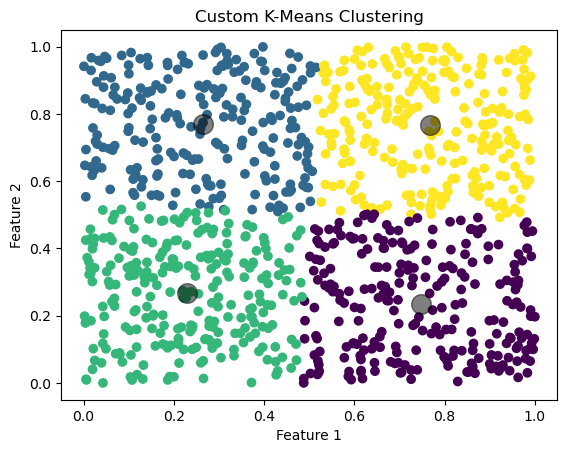

In [629]:
import numpy as np
import matplotlib.pyplot as plt

# Generating random data for illustration
np.random.seed(0)
n_samples = 1000
X = np.random.rand(n_samples, 2)

# Initialize centroids randomly
n_clusters = 4
initial_centroids = X[np.random.choice(X.shape[0], n_clusters, replace=False), :]

def compute_centroids(X, labels, n_clusters):
    centroids = np.zeros((n_clusters, X.shape[1]))
    for k in range(n_clusters):
        centroids[k, :] = np.mean(X[labels == k, :], axis=0)
    return centroids

def find_closest_centroids(X, centroids):
    labels = np.zeros(X.shape[0], dtype=int)
    for i in range(X.shape[0]):
        distances = np.linalg.norm(X[i, :] - centroids, axis=1)
        labels[i] = np.argmin(distances)
    return labels

# Run K-Means
centroids = initial_centroids
for i in range(10):  # number of iterations
    labels = find_closest_centroids(X, centroids)
    centroids = compute_centroids(X, labels, n_clusters)

# Plotting the clusters
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis')
plt.scatter(centroids[:, 0], centroids[:, 1], c='black', s=200, alpha=0.5)
plt.title('Custom K-Means Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()


# Severity vs Visibility:

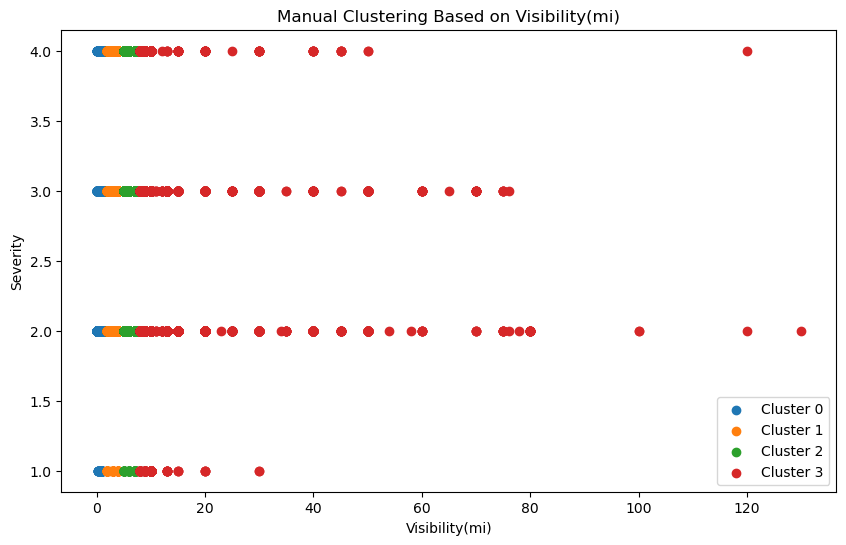

In [630]:
# Load your dataset
df = pd.read_csv('US_Accidents_March23_sampled_500k.csv')
# Define visibility thresholds for clustering
thresholds = [2, 5, 8]  # Example thresholds, adjust based on your data analysis

# Assign a cluster based on visibility
def assign_cluster(row):
    for i, threshold in enumerate(thresholds):
        if row['Visibility(mi)'] < threshold:
            return i
    return len(thresholds)

df['Cluster'] = df.apply(assign_cluster, axis=1)

# Plotting the clusters
plt.figure(figsize=(10, 6))
for cluster in range(len(thresholds) + 1):
    clustered_data = df[df['Cluster'] == cluster]
    plt.scatter(clustered_data['Visibility(mi)'], clustered_data['Severity'], label=f'Cluster {cluster}')

plt.title('Manual Clustering Based on Visibility(mi)')
plt.xlabel('Visibility(mi)')
plt.ylabel('Severity')
plt.legend()
plt.show()

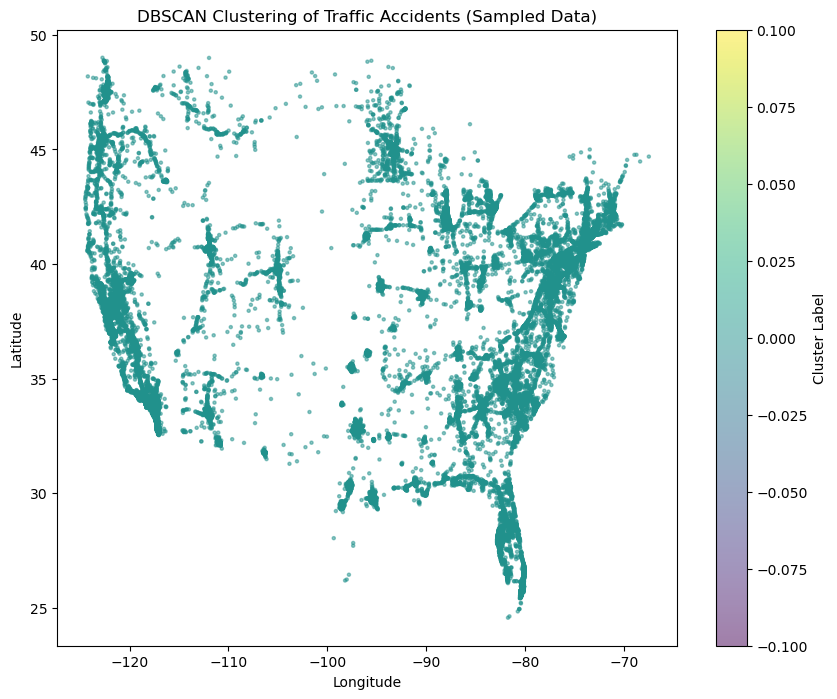

In [631]:
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np

# Load your dataset
df = pd.read_csv('US_Accidents_March23_sampled_500k.csv')

# Sample a fraction of the data, for example, 10%
df_sampled = df.sample(frac=0.1, random_state=42)

# Extract the coordinates for clustering from the sampled data
coords = df_sampled[['Start_Lat', 'Start_Lng']]

# Standardize the features
scaler = StandardScaler()
coords_scaled = scaler.fit_transform(coords)

# Apply DBSCAN clustering
db = DBSCAN(eps=0.5, min_samples=5).fit(coords_scaled)  # Adjusted parameters

# Add the cluster labels back to the original dataframe
df_sampled['cluster'] = db.labels_

# Plotting the clusters
plt.figure(figsize=(10, 8))
plt.scatter(df_sampled['Start_Lng'], df_sampled['Start_Lat'], c=df_sampled['cluster'], cmap='viridis', s=5, alpha=0.5)
plt.title('DBSCAN Clustering of Traffic Accidents (Sampled Data)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar(label='Cluster Label')
plt.show()


## Model Training

# Logistic Regression Model

In [632]:
# Defining the model and it's parameters
lr = LogisticRegression(random_state = 42, n_jobs =-1,max_iter = 100)
params = {"solver": ["sag","saga"]}

# Performing Grid Search to find best params
grid = GridSearchCV(lr, params, n_jobs =1,verbose = 0,)
grid.fit(X_train_sample, y_train_sample)

print("Best parameter scores:")
print(grid.best_params_)

# Storing the best Params to be used in training on whole dataset if it's a best model compared to others
best_params["lr"] = grid.best_params_
print(f"Train score: {grid.score(X_train_sample, y_train_sample)}")


python(34788) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(34789) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(34790) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(34791) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(34792) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(34793) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(34794) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(34795) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Best parameter scores:
{'solver': 'saga'}
Train score: 0.713125


In [633]:
# Observing the data frame on fitted models 
df = (pd.DataFrame(grid.cv_results_,index = ['sag','saga'])).drop(["param_solver"],axis = 1)
df = df.rename_axis('Solver', axis='index')
df


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
Solver,,,,,,,,,,,,,
sag,0.663085,0.315597,0.005555,0.004393,{'solver': 'sag'},0.694375,0.719375,0.704375,0.695625,0.691875,0.701125,0.010050,2
saga,0.679643,0.104290,0.008745,0.005125,{'solver': 'saga'},0.694375,0.720000,0.704375,0.695625,0.691875,0.701250,0.010277,1


Running the best params logistic regression model

In [634]:
print("Best Param scores for Logistic Regression:")
lr = LogisticRegression(**grid.best_params_, random_state = 42,)
lr.fit(X_train_sample, y_train_sample)

# Storing the model trained with best params later used for visualizations
models["Logistic Regression"] = lr


print("Train score:", lr.score(X_train_sample, y_train_sample))
print("Validation score:", lr.score(X_val_sample, y_val_sample))

Best Param scores for Logistic Regression:
Train score: 0.713125
Validation score: 0.6995


Logistic Regression Conf. Matrix on Validation set


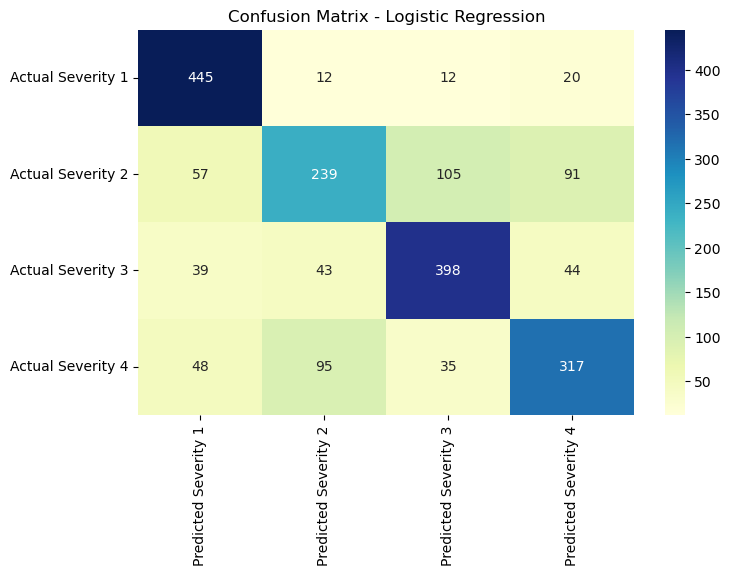

In [635]:
y_pred = lr.predict(X_val_sample)
confmat = confusion_matrix(y_true=y_val_sample, y_pred=y_pred)

index = ["Actual Severity 1", "Actual Severity 2", "Actual Severity 3", "Actual Severity 4"]
columns = ["Predicted Severity 1", "Predicted Severity 2", "Predicted Severity 3", "Predicted Severity 4"]

conf_matrix = pd.DataFrame(data=confmat, columns=columns, index=index)

plt.figure(figsize=(8, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="YlGnBu")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

In [636]:
# Observing the classification report for Logistic Regression
y_pred = lr.predict(X_val_sample)

# Store the respective scores
accuracy["Logistic Regression"] = accuracy_score(y_val_sample,y_pred)
f1["Logistic Regression"] = f1_score(y_val_sample,y_pred,average = 'macro')

# Classification report on train and Val data
print(classification_report(y_train_sample,lr.predict(X_train_sample)))
print(classification_report(y_val_sample,y_pred))

              precision    recall  f1-score   support

           1       0.75      0.90      0.82      1991
           2       0.62      0.50      0.55      1988
           3       0.73      0.75      0.74      1985
           4       0.73      0.70      0.72      2036

    accuracy                           0.71      8000
   macro avg       0.71      0.71      0.71      8000
weighted avg       0.71      0.71      0.71      8000

              precision    recall  f1-score   support

           1       0.76      0.91      0.83       489
           2       0.61      0.49      0.54       492
           3       0.72      0.76      0.74       524
           4       0.67      0.64      0.66       495

    accuracy                           0.70      2000
   macro avg       0.69      0.70      0.69      2000
weighted avg       0.69      0.70      0.69      2000



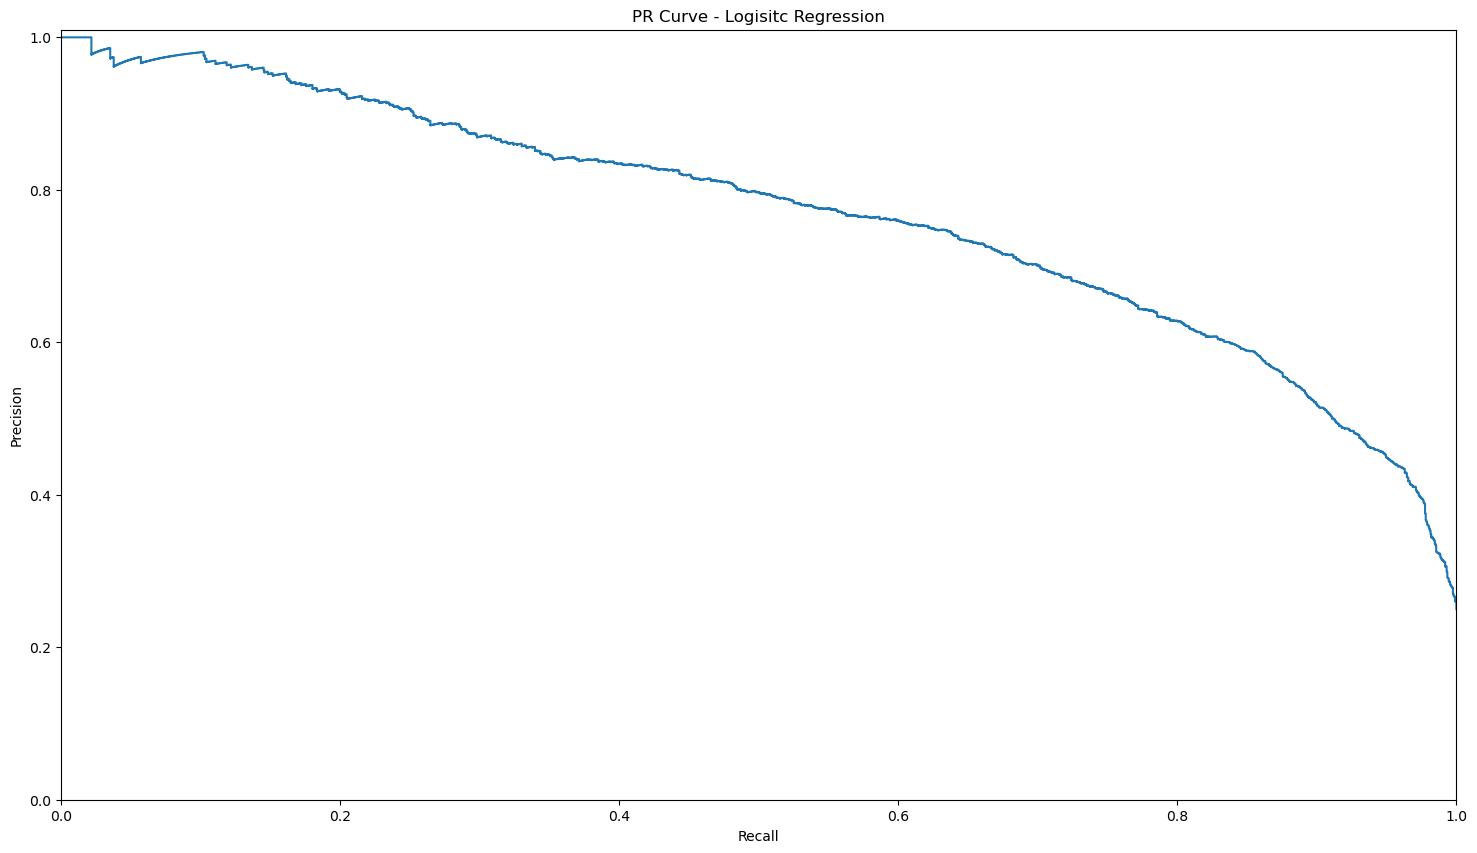

In [637]:
# Creates a 2d array from 1d array of y_val_sample, where each instance represents presence of one severity via 1 and rest are 0's.
# This is necessary since predictions are in 2d format 
# Creating a pr curve tests these arrays i.e. true_y_values and predictions on different 
# thresholds, so binarizing is helpful to make y_val and preds of same size to be compared

Y = label_binarize(y_val_sample, classes=[1, 2, 3, 4])

y_score = lr.predict_proba(X_val_sample)

#Storing the metrics for later viz's
precision["Logistic Regression"], recall["Logistic Regression"], thresholds = precision_recall_curve(Y.ravel(), y_score.ravel())
fpr["Logistic Regression"], tpr["Logistic Regression"], _ = roc_curve(Y.ravel(), y_score.ravel())

# Plotting the PR Curve
plt.figure(figsize=(18, 10))
plt.step(recall["Logistic Regression"], precision["Logistic Regression"], where="post")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.xlim([0, 1])
plt.ylim([0, 1.01])
plt.title("PR Curve - Logisitc Regression")
plt.show()
# The curve is better the one which is near to right hand corner [1,1]

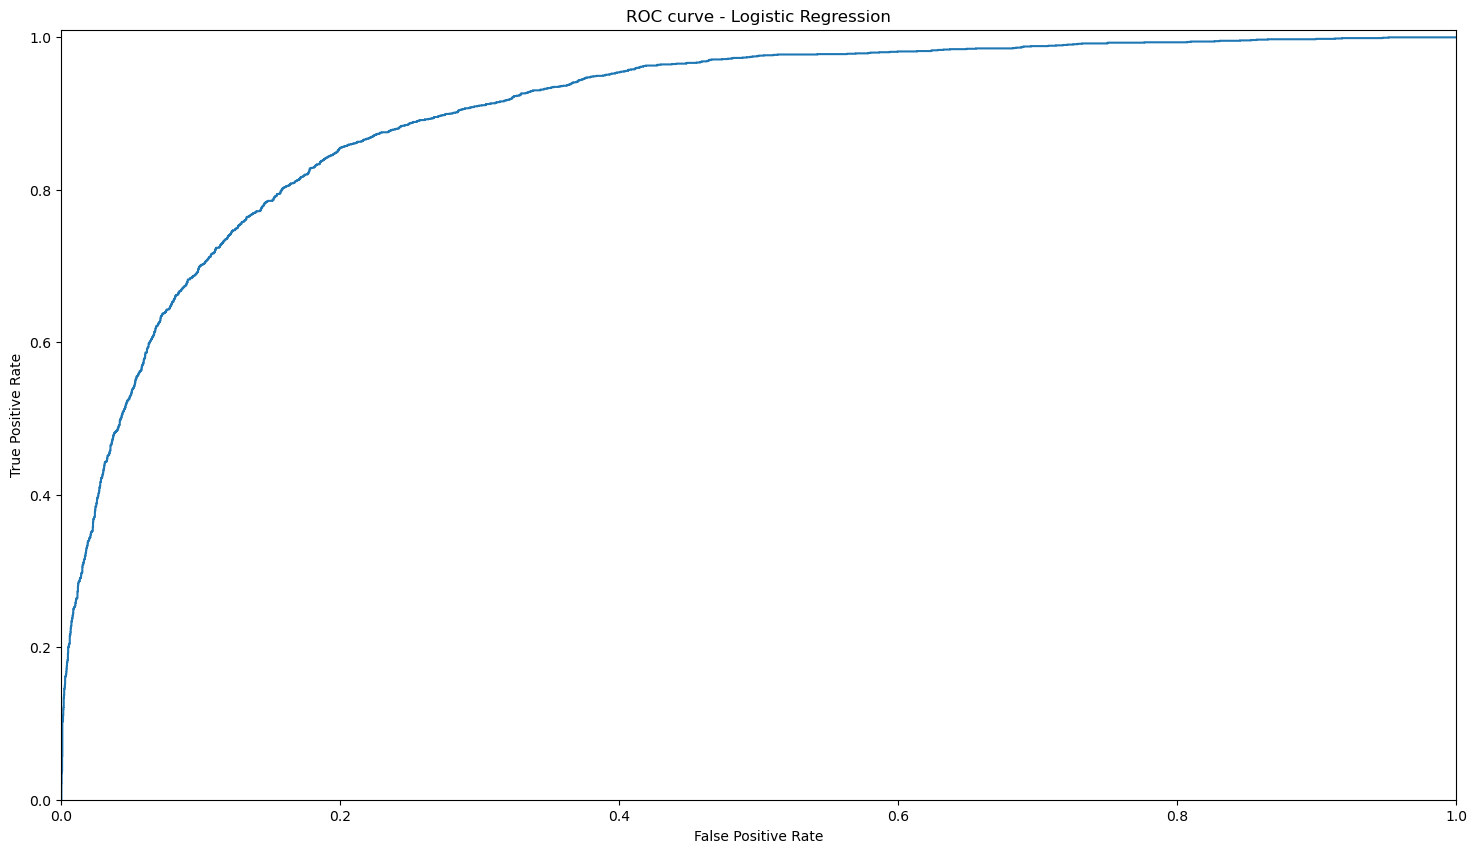

In [638]:
plt.figure(figsize=(18, 10))
plt.step(fpr["Logistic Regression"], tpr["Logistic Regression"], where="post")

plt.title("ROC curve - Logistic Regression")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.xlim([0, 1])
plt.ylim([0, 1.01])
plt.show()
# The curve is better the one which is near to left hand corner [0,1]


# Decision Tree Model

In [641]:
dtc = DecisionTreeClassifier(random_state=42)
parameters = [{"criterion": ["gini", "entropy"], "max_depth": [5, 10, 15, 30]}]

grid = GridSearchCV(dtc, parameters, verbose = 0, n_jobs=-1)
grid.fit(X_train_sample, y_train_sample)

print("Best param scores for Decision Tree Classifier:")
print(grid.best_params_)
best_params["dtc"] = grid.best_params_

print("Train score:", grid.score(X_train_sample, y_train_sample))
print("Validation score:", grid.score(X_val_sample, y_val_sample))

Best param scores for Decision Tree Classifier:
{'criterion': 'gini', 'max_depth': 10}
Train score: 0.8505
Validation score: 0.745


In [642]:
pd.DataFrame(grid.cv_results_).sort_values(by = 'rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
1,0.060572,0.005476,0.002284,0.000839,gini,10,"{'criterion': 'gini', 'max_depth': 10}",0.766875,0.753125,0.756250,0.745000,0.771250,0.758500,0.009475,1
5,0.103430,0.007820,0.008364,0.004825,entropy,10,"{'criterion': 'entropy', 'max_depth': 10}",0.754375,0.762500,0.746250,0.750000,0.768750,0.756375,0.008220,2
4,0.065399,0.031897,0.003893,0.003192,entropy,5,"{'criterion': 'entropy', 'max_depth': 5}",0.730000,0.749375,0.729375,0.730000,0.743125,0.736375,0.008305,3
0,0.035132,0.003792,0.003420,0.001500,gini,5,"{'criterion': 'gini', 'max_depth': 5}",0.731875,0.731875,0.735625,0.729375,0.742500,0.734250,0.004583,4
2,0.076593,0.008806,0.002543,0.000972,gini,15,"{'criterion': 'gini', 'max_depth': 15}",0.740000,0.716250,0.730625,0.737500,0.736875,0.732250,0.008575,5
6,0.136520,0.008854,0.005557,0.004764,entropy,15,"{'criterion': 'entropy', 'max_depth': 15}",0.716250,0.717500,0.728125,0.718125,0.717500,0.719500,0.004355,6
3,0.145797,0.046540,0.006400,0.005033,gini,30,"{'criterion': 'gini', 'max_depth': 30}",0.722500,0.718750,0.712500,0.711875,0.719375,0.717000,0.004134,7
7,0.120418,0.013751,0.001963,0.000461,entropy,30,"{'criterion': 'entropy', 'max_depth': 30}",0.706875,0.700625,0.705625,0.710000,0.711875,0.707000,0.003881,8


In [643]:
print("Best Param scores for Decision Tree Classifier:")
dtc = DecisionTreeClassifier(**grid.best_params_, random_state = 42)

dtc.fit(X_train_sample, y_train_sample)

# Storing the model trained with best params later used for visualizations
models["Decision Tree"] = dtc

print("Train score:", dtc.score(X_train_sample, y_train_sample))
print("Validation score:", dtc.score(X_val_sample, y_val_sample))

Best Param scores for Decision Tree Classifier:
Train score: 0.8505
Validation score: 0.745


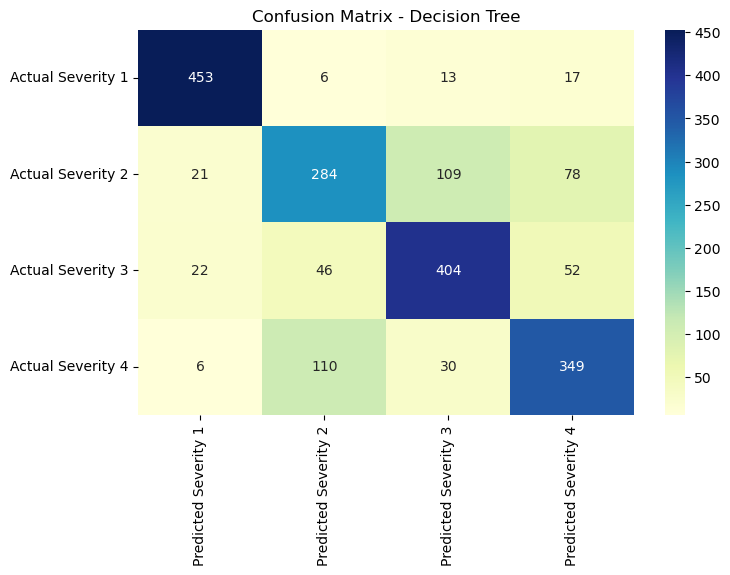

In [644]:
y_pred = dtc.predict(X_val_sample)
confmat = confusion_matrix(y_true=y_val_sample, y_pred=y_pred)

index = ["Actual Severity 1", "Actual Severity 2", "Actual Severity 3", "Actual Severity 4"]
columns = ["Predicted Severity 1", "Predicted Severity 2", "Predicted Severity 3", "Predicted Severity 4"]

conf_matrix = pd.DataFrame(data=confmat, columns=columns, index=index)

plt.figure(figsize=(8, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="YlGnBu")
plt.title("Confusion Matrix - Decision Tree")
plt.show()

In [645]:
y_pred = dtc.predict(X_val_sample)

accuracy["Decision Tree"] = accuracy_score(y_val_sample, y_pred)
f1["Decision Tree"] = f1_score(y_val_sample, y_pred, average="macro")

print(classification_report(y_train_sample, dtc.predict(X_train_sample)))
print(classification_report(y_val_sample, y_pred))

              precision    recall  f1-score   support

           1       0.93      0.94      0.94      1991
           2       0.82      0.73      0.77      1988
           3       0.81      0.87      0.84      1985
           4       0.85      0.86      0.85      2036

    accuracy                           0.85      8000
   macro avg       0.85      0.85      0.85      8000
weighted avg       0.85      0.85      0.85      8000

              precision    recall  f1-score   support

           1       0.90      0.93      0.91       489
           2       0.64      0.58      0.61       492
           3       0.73      0.77      0.75       524
           4       0.70      0.71      0.70       495

    accuracy                           0.74      2000
   macro avg       0.74      0.74      0.74      2000
weighted avg       0.74      0.74      0.74      2000



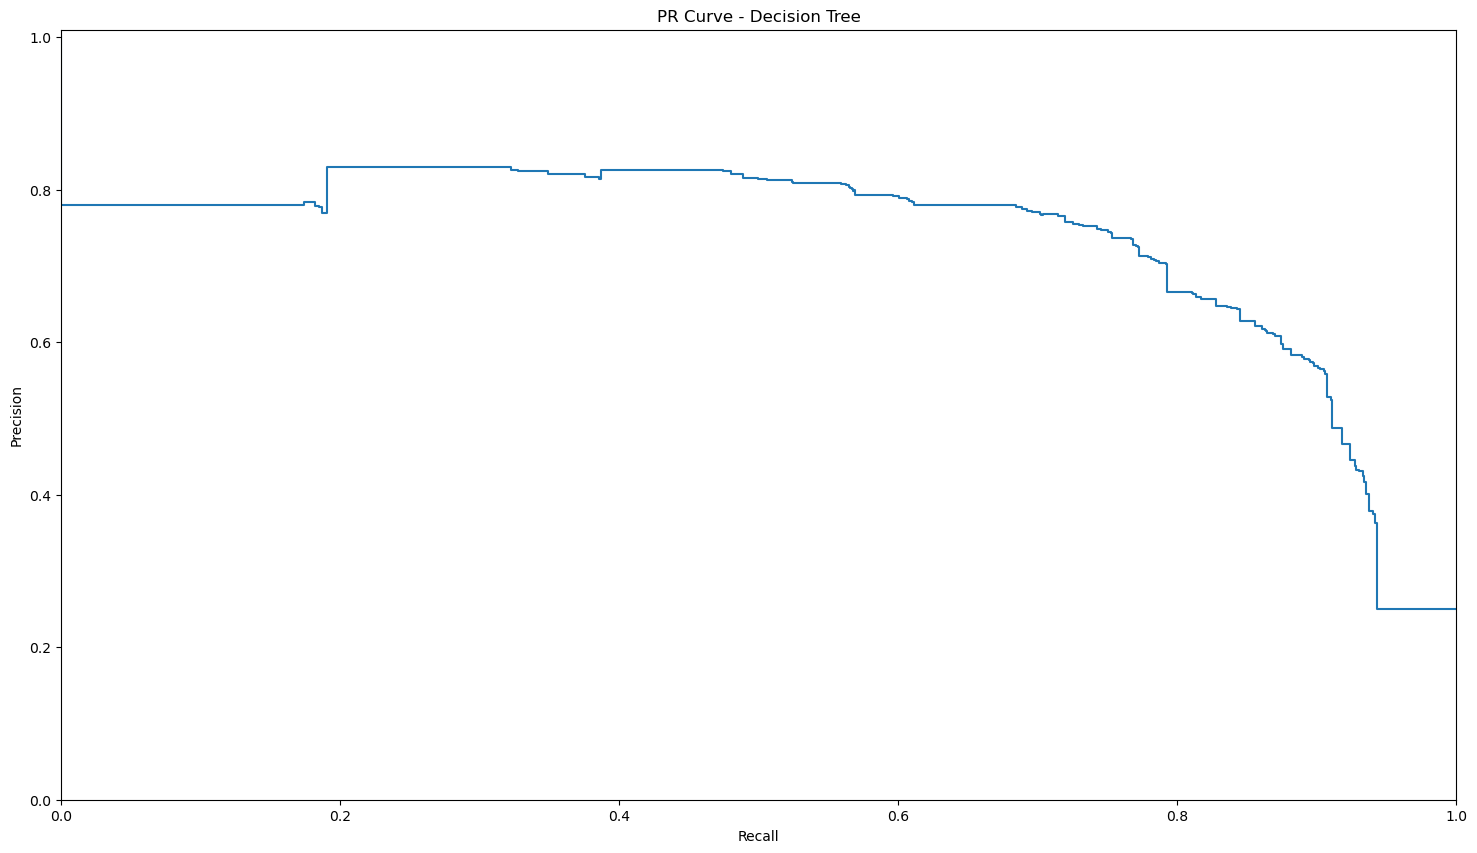

In [646]:
Y = label_binarize(y_val_sample, classes=[1, 2, 3, 4])

y_score = dtc.predict_proba(X_val_sample)

precision["Decision Tree"], recall["Decision Tree"], _ = precision_recall_curve(Y.ravel(), y_score.ravel())
fpr["Decision Tree"], tpr["Decision Tree"], _ = roc_curve(Y.ravel(), y_score.ravel())

plt.figure(figsize=(18, 10))
plt.step(recall["Decision Tree"], precision["Decision Tree"], where="post")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.xlim([0, 1])
plt.ylim([0, 1.01])
plt.title("PR Curve - Decision Tree")
plt.show()

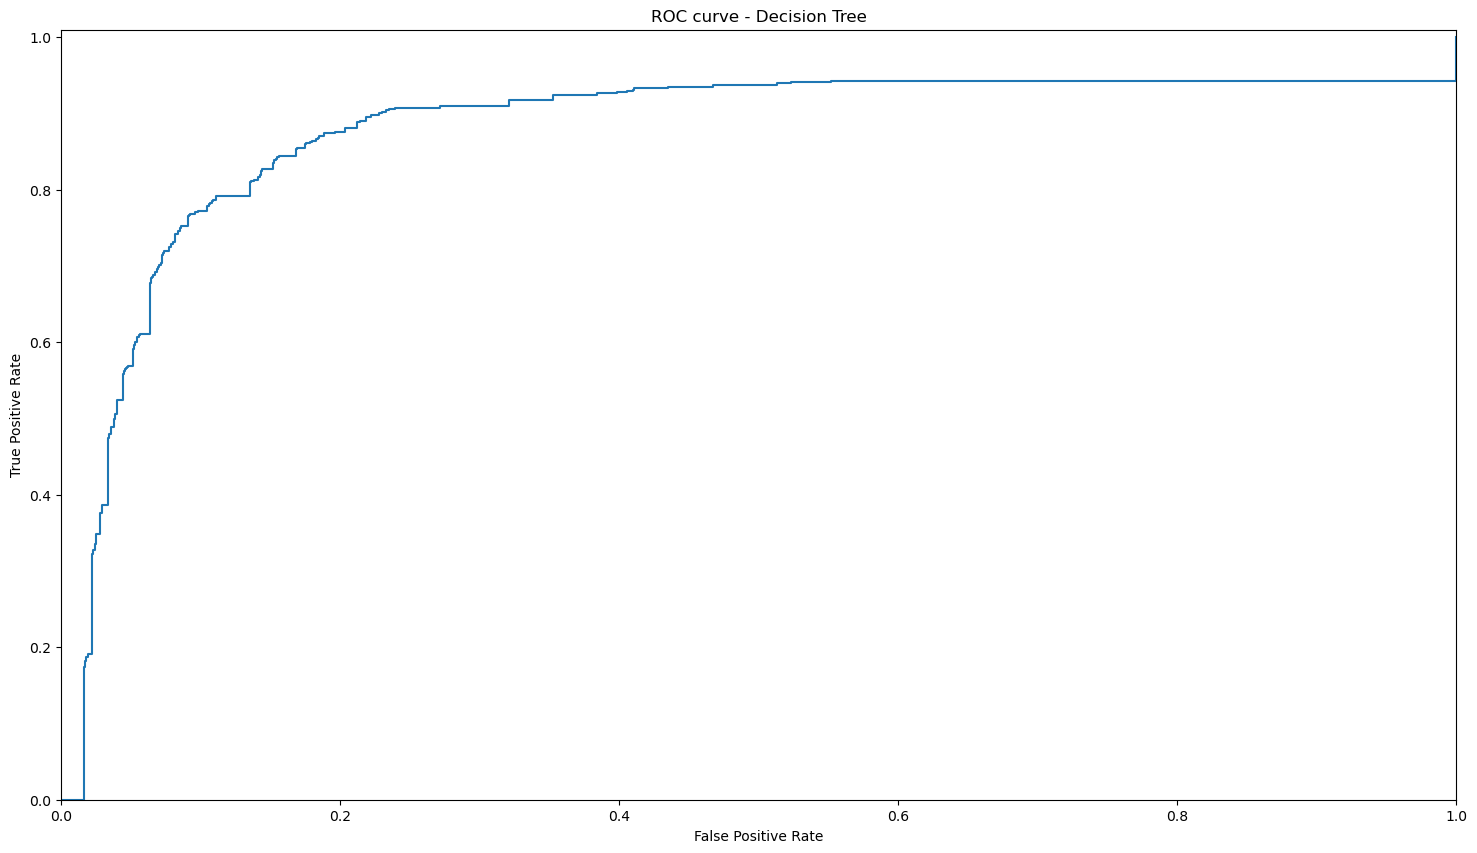

In [647]:
plt.figure(figsize=(18, 10))
plt.step(fpr["Decision Tree"], tpr["Decision Tree"], where="post")

plt.title("ROC curve - Decision Tree")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.xlim([0, 1])
plt.ylim([0, 1.01])
plt.show()

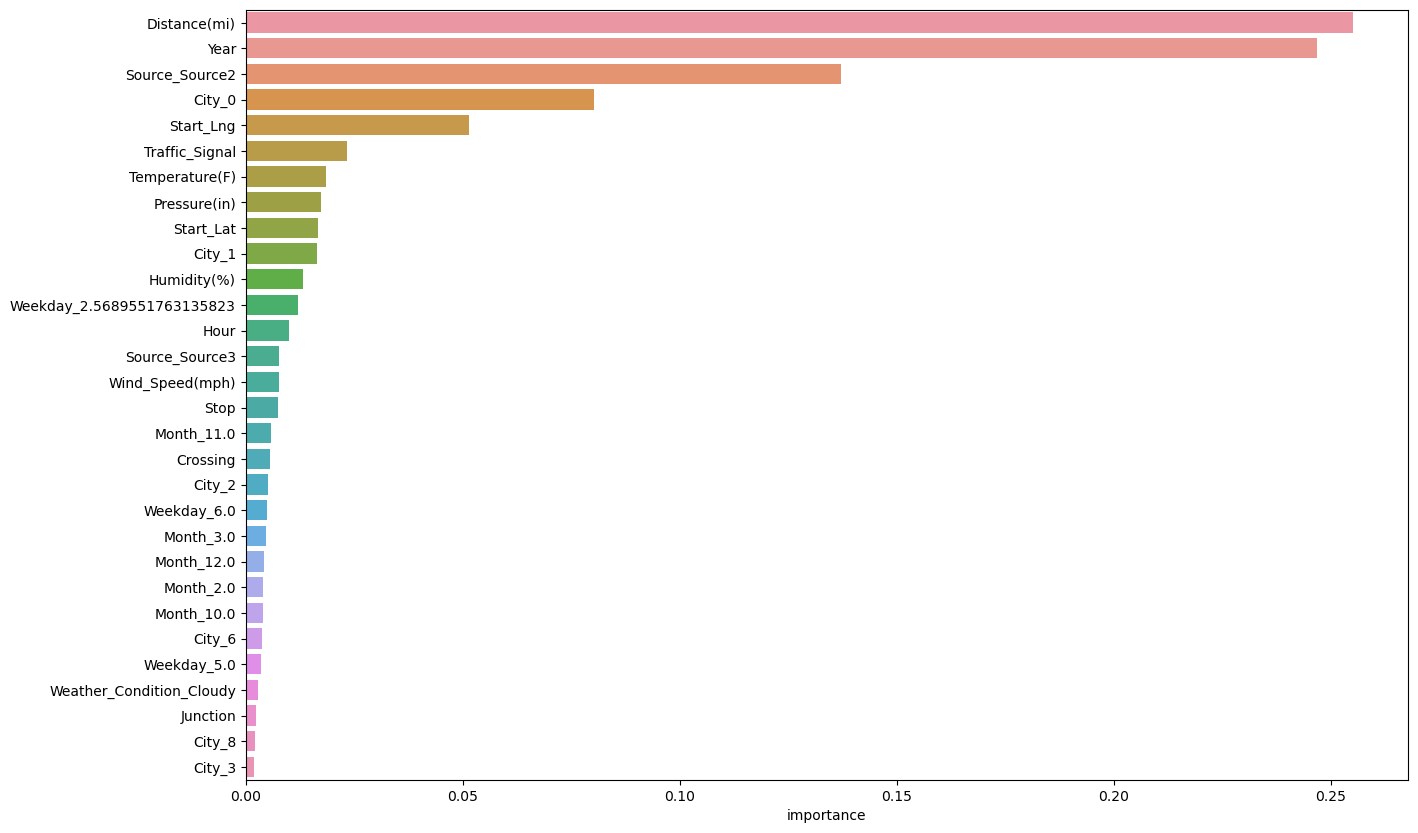

In [648]:
importances = pd.DataFrame(np.zeros((X_train_sample.shape[1], 1)), columns=["importance"], index=X_train_sample.columns)

importances.iloc[:,0] = dtc.feature_importances_

importances = importances.sort_values(by="importance", ascending=False)[:30]

plt.figure(figsize=(15, 10))
sns.barplot(x="importance", y=importances.index, data=importances)
plt.show()

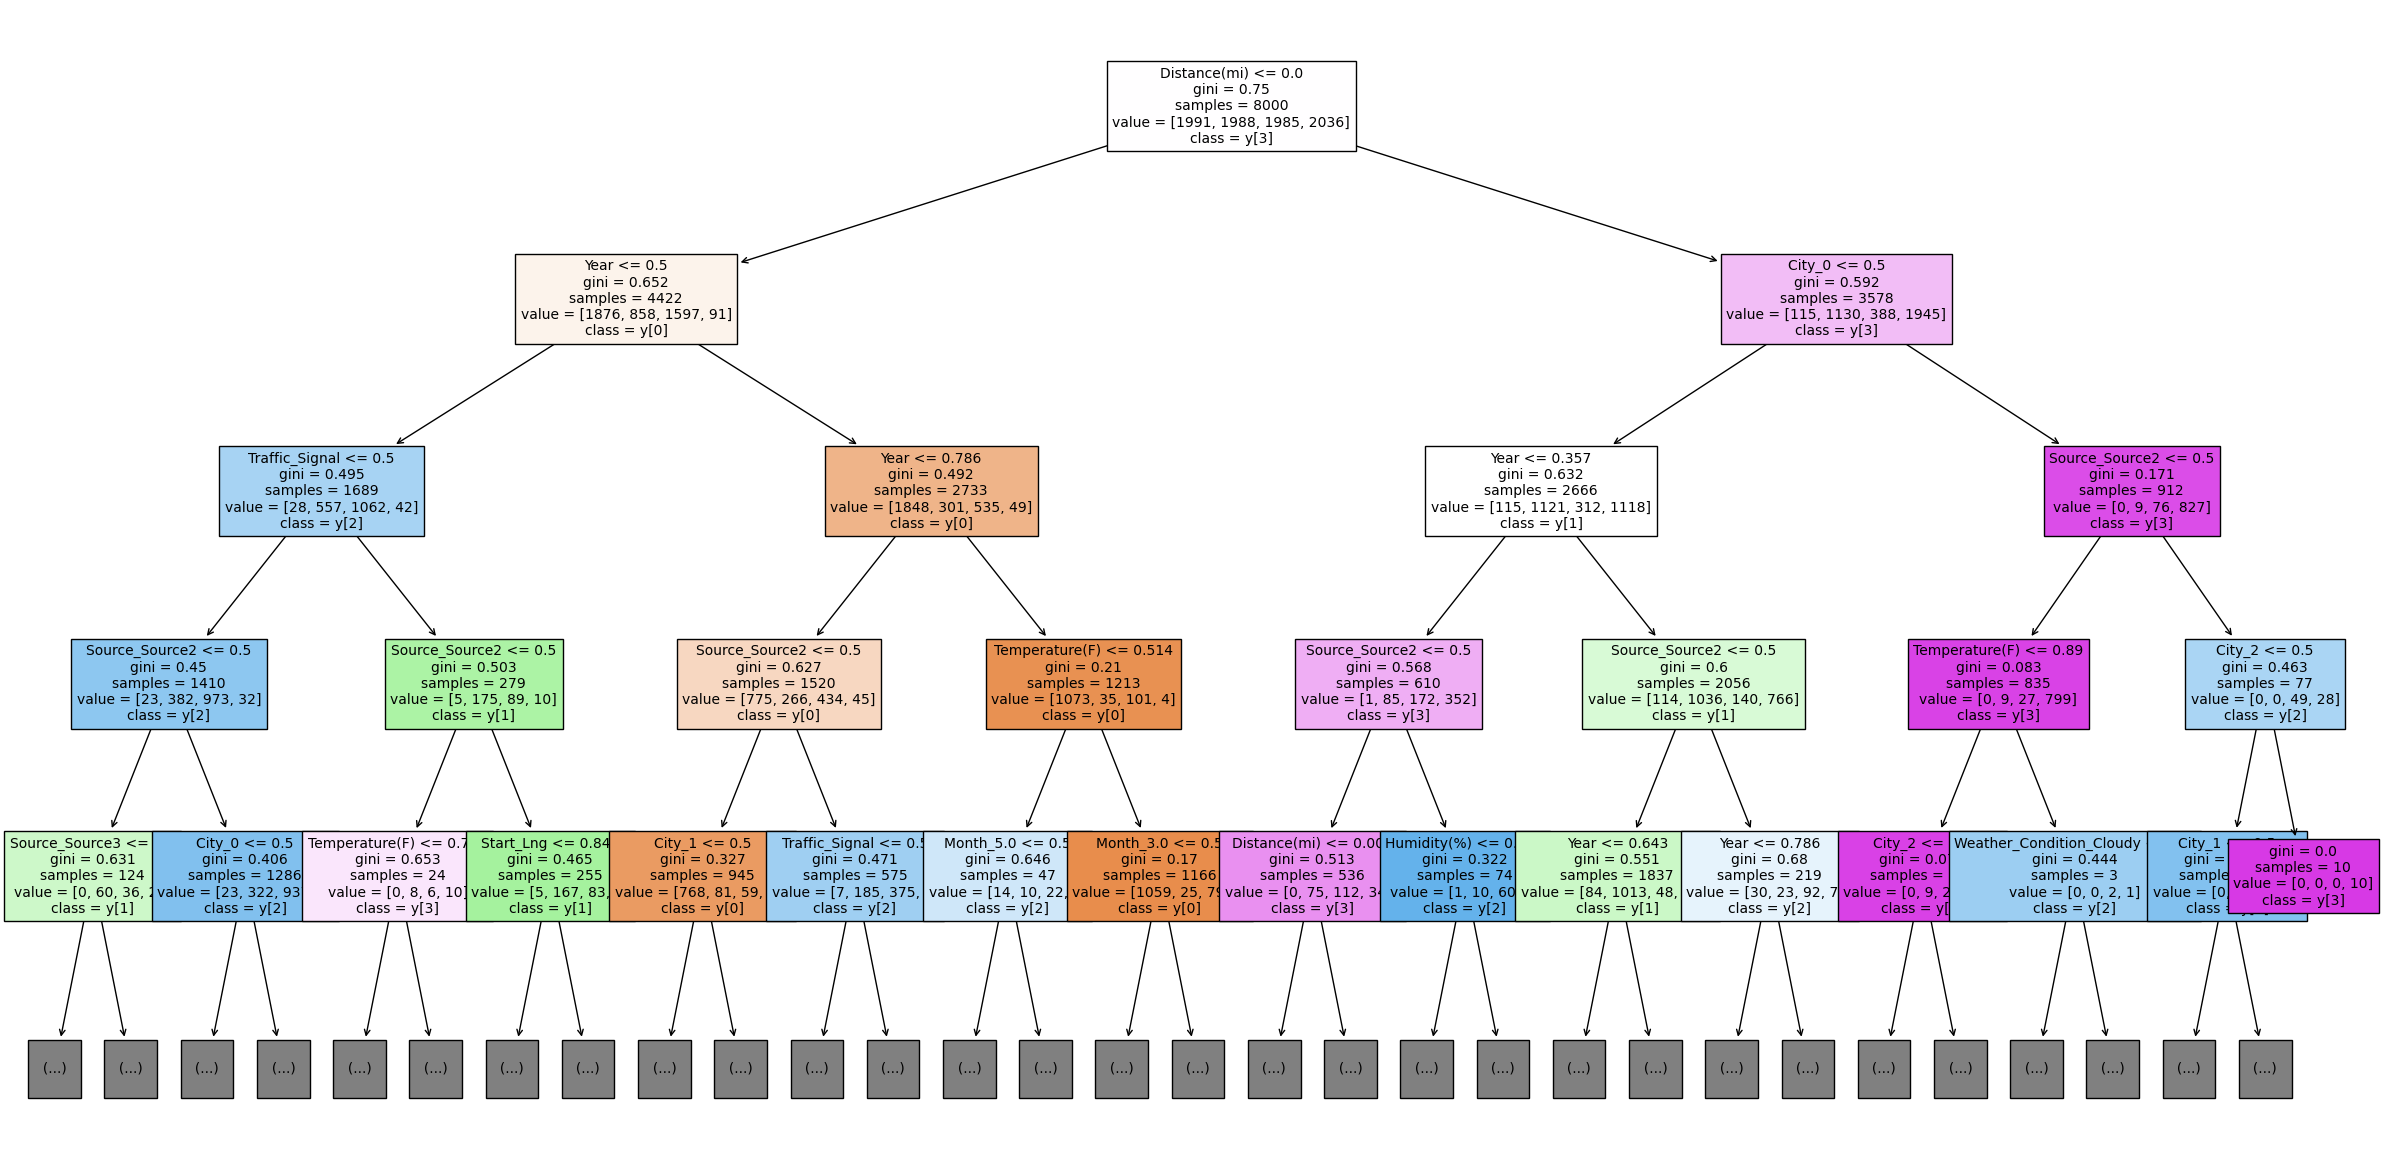

In [649]:
fig, ax = plt.subplots(figsize=(30, 15))
plot_tree(dtc, max_depth=4, fontsize=10, feature_names=X_train_sample.columns.to_list(), class_names = True, filled=True)
plt.show()

# Random Forest Classifier

In [650]:
rfc = RandomForestClassifier(n_jobs=-1, random_state=42)
parameters = [{"n_estimators": [50, 100, 200, 500], "max_depth": [5, 10, 15, 30]}]

grid = GridSearchCV(rfc, parameters, verbose = 0, n_jobs=-1)
grid.fit(X_train_sample, y_train_sample)

print("Best parameters scores:")
print(grid.best_params_)
best_params["rfc"] = grid.best_params_


print("Train score:", grid.score(X_train_sample, y_train_sample))
print("Validation score:", grid.score(X_val_sample, y_val_sample))

Best parameters scores:
{'max_depth': 30, 'n_estimators': 500}
Train score: 1.0
Validation score: 0.772


In [651]:
pd.DataFrame(grid.cv_results_).sort_values(by="rank_test_score")

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
15,3.360795,0.182363,0.107048,0.052651,30,500,"{'max_depth': 30, 'n_estimators': 500}",0.785625,0.792500,0.785625,0.766250,0.793750,0.784750,0.009847,1
14,1.875302,0.079733,0.072091,0.013025,30,200,"{'max_depth': 30, 'n_estimators': 200}",0.782500,0.796250,0.780625,0.765625,0.793750,0.783750,0.010919,2
13,0.877764,0.071808,0.024960,0.006747,30,100,"{'max_depth': 30, 'n_estimators': 100}",0.777500,0.795625,0.777500,0.758750,0.794375,0.780750,0.013506,3
11,4.427787,0.158217,0.157031,0.080198,15,500,"{'max_depth': 15, 'n_estimators': 500}",0.778750,0.790625,0.780000,0.757500,0.791875,0.779750,0.012340,4
10,1.659414,0.103643,0.050269,0.003463,15,200,"{'max_depth': 15, 'n_estimators': 200}",0.778125,0.789375,0.781875,0.757500,0.789375,0.779250,0.011715,5
9,0.849574,0.148403,0.026918,0.002016,15,100,"{'max_depth': 15, 'n_estimators': 100}",0.781875,0.788125,0.772500,0.755625,0.790000,0.777625,0.012583,6
12,0.400653,0.113986,0.048159,0.046239,30,50,"{'max_depth': 30, 'n_estimators': 50}",0.771250,0.783125,0.783750,0.752500,0.785625,0.775250,0.012454,7
8,0.224774,0.157816,0.060188,0.084953,15,50,"{'max_depth': 15, 'n_estimators': 50}",0.780000,0.787500,0.770625,0.751250,0.785625,0.775000,0.013246,8
7,3.858424,0.119886,0.146341,0.065399,10,500,"{'max_depth': 10, 'n_estimators': 500}",0.768750,0.783750,0.775625,0.751875,0.778125,0.771625,0.010987,9
6,1.435552,0.106942,0.024399,0.009945,10,200,"{'max_depth': 10, 'n_estimators': 200}",0.770000,0.781875,0.771875,0.750625,0.775000,0.769875,0.010439,10


In [652]:
print("Best Param scores for Random Forest Classifier:")
rfc = RandomForestClassifier(**grid.best_params_, random_state = 42)

rfc.fit(X_train_sample, y_train_sample)
# Storing the model trained with best params later used for visualizations
models["Random Forest"] = rfc

print("Train Score: ", rfc.score(X_train_sample, y_train_sample))
print("Validation Score: ", rfc.score(X_val_sample, y_val_sample))

Best Param scores for Random Forest Classifier:
Train Score:  1.0
Validation Score:  0.772


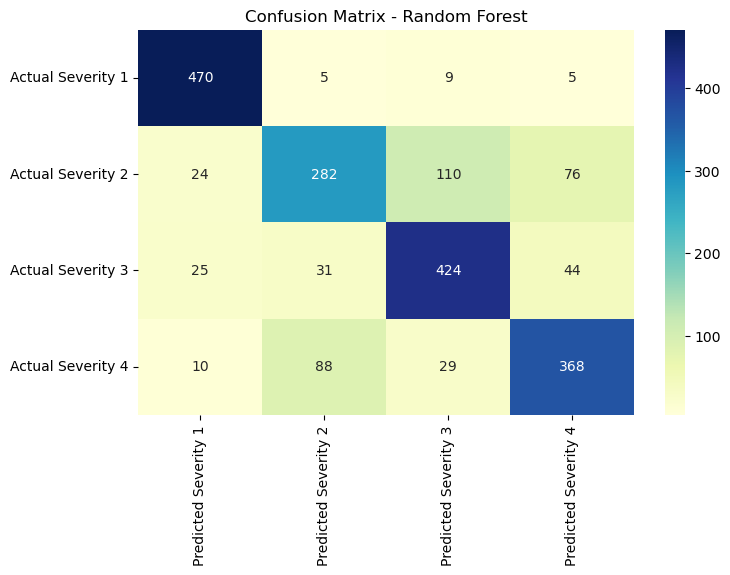

In [653]:
y_pred = rfc.predict(X_val_sample)
confmat = confusion_matrix(y_true=y_val_sample, y_pred=y_pred)

index = ["Actual Severity 1", "Actual Severity 2", "Actual Severity 3", "Actual Severity 4"]
columns = ["Predicted Severity 1", "Predicted Severity 2", "Predicted Severity 3", "Predicted Severity 4"]

conf_matrix = pd.DataFrame(data=confmat, columns=columns, index=index)

plt.figure(figsize=(8, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="YlGnBu")
plt.title("Confusion Matrix - Random Forest")
plt.show()

In [654]:
y_pred = rfc.predict(X_val_sample)

accuracy["Random Forest"] = accuracy_score(y_val_sample, y_pred)
f1["Random Forest"] = f1_score(y_val_sample, y_pred, average="macro")

print(classification_report(y_train_sample, rfc.predict(X_train_sample)))
print(classification_report(y_val_sample, y_pred))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00      1991
           2       1.00      1.00      1.00      1988
           3       1.00      1.00      1.00      1985
           4       1.00      1.00      1.00      2036

    accuracy                           1.00      8000
   macro avg       1.00      1.00      1.00      8000
weighted avg       1.00      1.00      1.00      8000

              precision    recall  f1-score   support

           1       0.89      0.96      0.92       489
           2       0.69      0.57      0.63       492
           3       0.74      0.81      0.77       524
           4       0.75      0.74      0.74       495

    accuracy                           0.77      2000
   macro avg       0.77      0.77      0.77      2000
weighted avg       0.77      0.77      0.77      2000



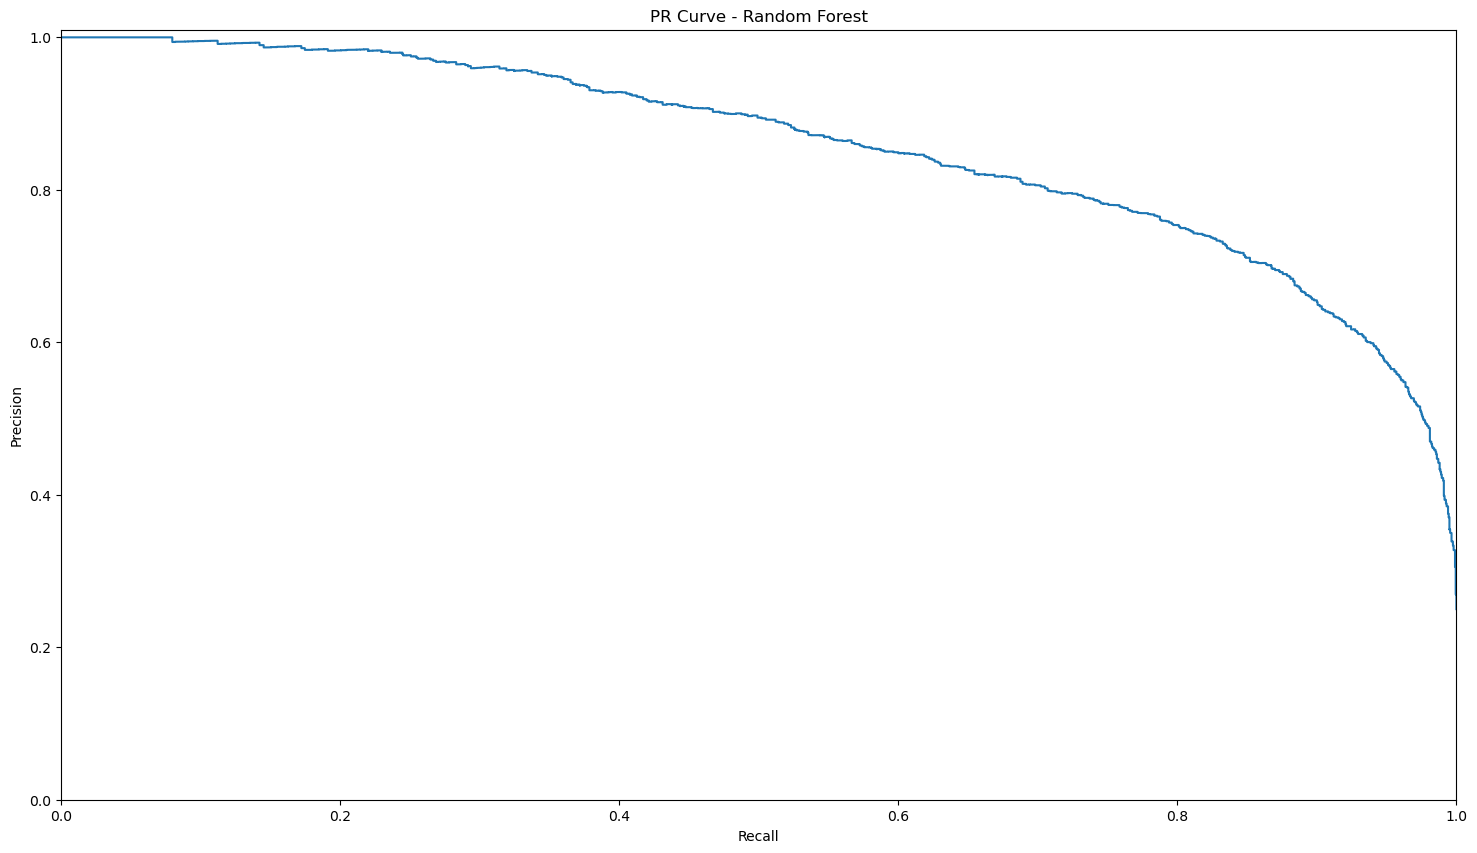

In [655]:

Y = label_binarize(y_val_sample, classes=[1, 2, 3, 4])

y_score = rfc.predict_proba(X_val_sample)

precision["Random Forest"], recall["Random Forest"], _ = precision_recall_curve(Y.ravel(), y_score.ravel())
fpr["Random Forest"], tpr["Random Forest"], _ = roc_curve(Y.ravel(), y_score.ravel())

plt.figure(figsize=(18, 10))
plt.step(recall["Random Forest"], precision["Random Forest"], where="post")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.xlim([0, 1])
plt.ylim([0, 1.01])
plt.title("PR Curve - Random Forest")
plt.show()

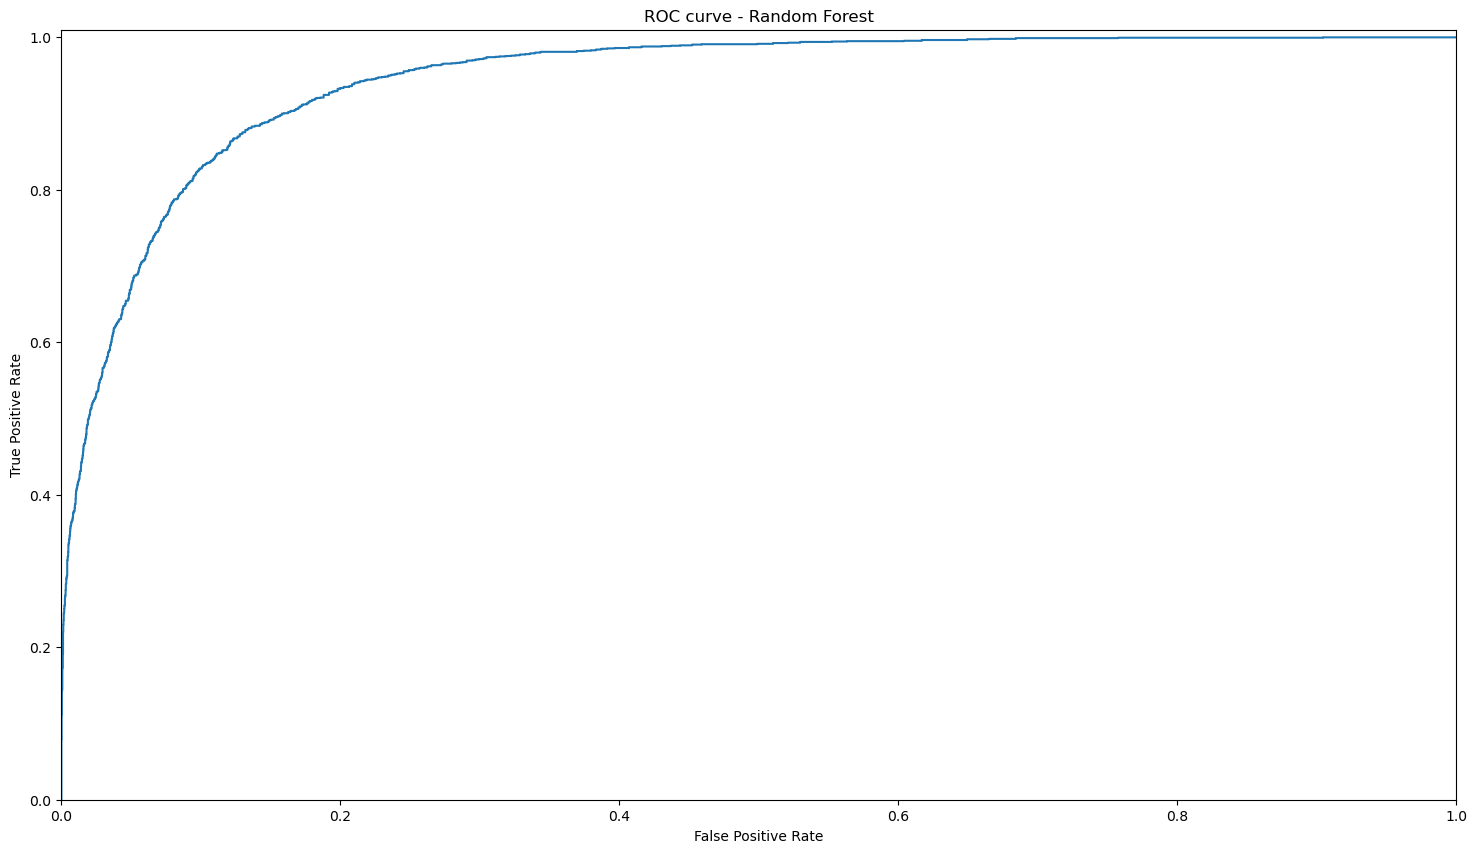

In [656]:
plt.figure(figsize=(18, 10))
plt.step(fpr["Random Forest"], tpr["Random Forest"], where="post")

plt.title("ROC curve - Random Forest")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.xlim([0, 1])
plt.ylim([0, 1.01])
plt.show()

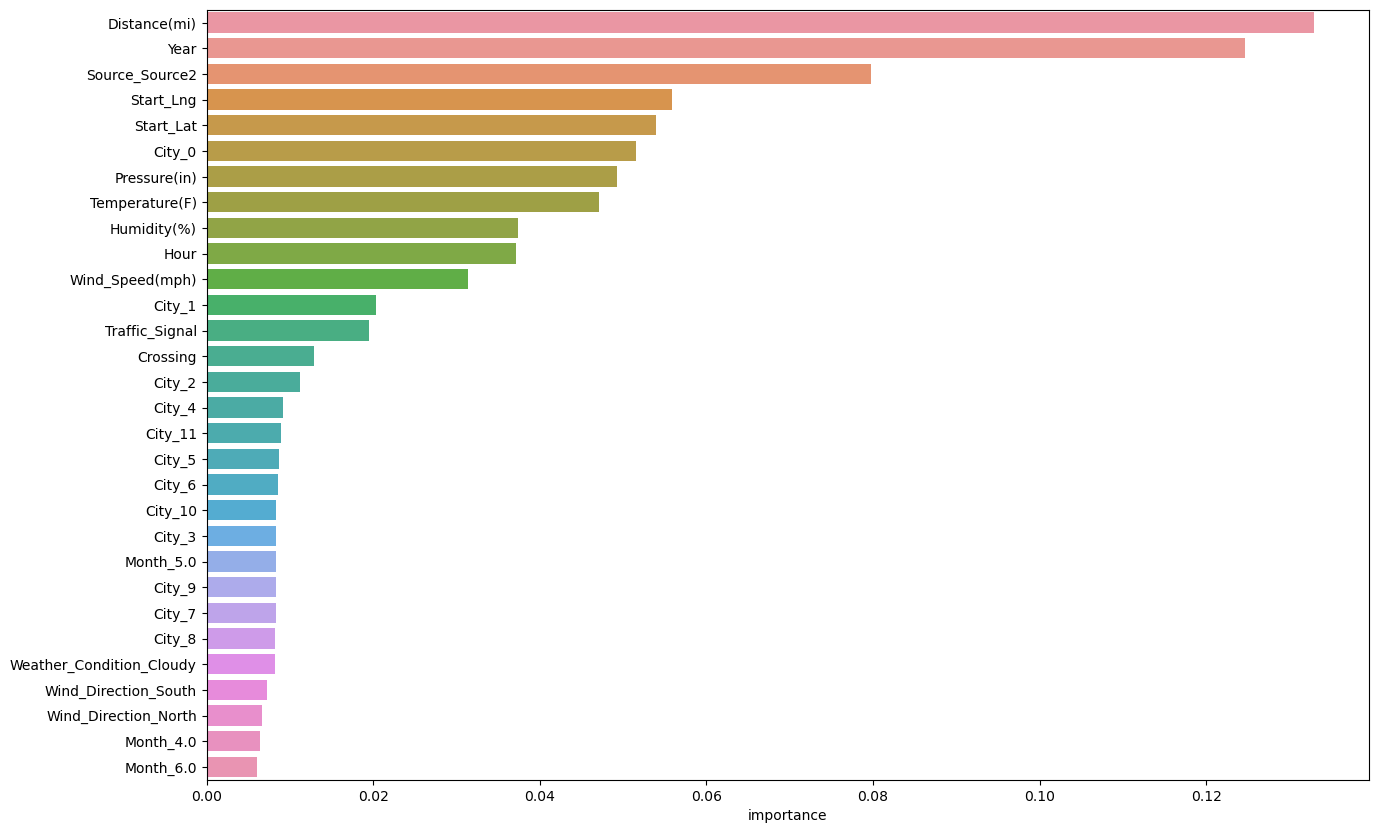

In [657]:
importances = pd.DataFrame(np.zeros((X_train_sample.shape[1], 1)), columns=["importance"], index=X_train_sample.columns)

importances.iloc[:,0] = rfc.feature_importances_

importances = importances.sort_values(by="importance", ascending=False)[:30]

plt.figure(figsize=(15, 10))
sns.barplot(x="importance", y=importances.index, data=importances)
plt.show()

# Naive Bayes

In [658]:
mnb = MultinomialNB()
mnb.fit(X_train_sample, y_train_sample)

# Storing the model trained with best params later used for visualizations
models["Multinomial Naive Bayes"] = mnb

print("Train score:", mnb.score(X_train_sample, y_train_sample))
print("Validation score:", mnb.score(X_val_sample, y_val_sample))

Train score: 0.63925
Validation score: 0.62


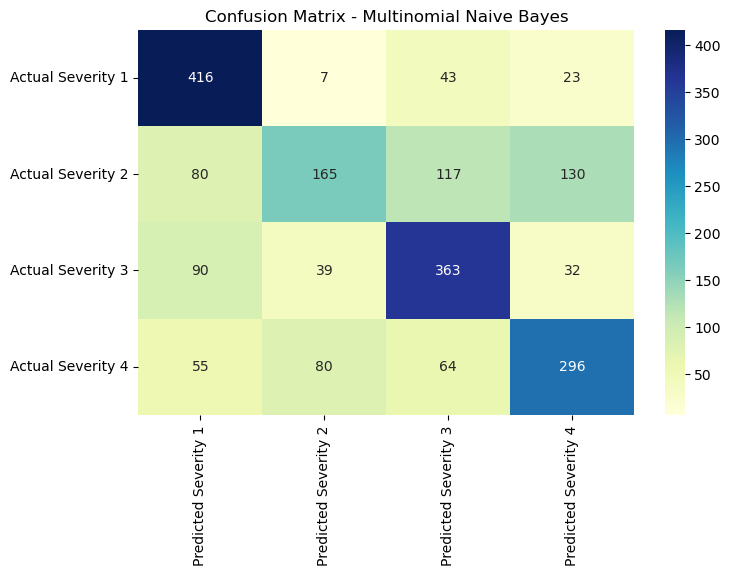

In [659]:
y_pred = mnb.predict(X_val_sample)
confmat = confusion_matrix(y_true=y_val_sample, y_pred=y_pred)

index = ["Actual Severity 1", "Actual Severity 2", "Actual Severity 3", "Actual Severity 4"]
columns = ["Predicted Severity 1", "Predicted Severity 2", "Predicted Severity 3", "Predicted Severity 4"]

conf_matrix = pd.DataFrame(data=confmat, columns=columns, index=index)

plt.figure(figsize=(8, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="YlGnBu")
plt.title("Confusion Matrix - Multinomial Naive Bayes")
plt.show()

In [660]:
y_pred = mnb.predict(X_val_sample)

accuracy["Multinomial Naive Bayes"] = accuracy_score(y_val_sample, y_pred)
f1["Multinomial Naive Bayes"] = f1_score(y_val_sample, y_pred, average="macro")

print(classification_report(y_train_sample, mnb.predict(X_train_sample)))
print(classification_report(y_val_sample, y_pred))

              precision    recall  f1-score   support

           1       0.63      0.84      0.72      1991
           2       0.60      0.37      0.46      1988
           3       0.65      0.70      0.67      1985
           4       0.66      0.65      0.66      2036

    accuracy                           0.64      8000
   macro avg       0.64      0.64      0.63      8000
weighted avg       0.64      0.64      0.63      8000

              precision    recall  f1-score   support

           1       0.65      0.85      0.74       489
           2       0.57      0.34      0.42       492
           3       0.62      0.69      0.65       524
           4       0.62      0.60      0.61       495

    accuracy                           0.62      2000
   macro avg       0.61      0.62      0.60      2000
weighted avg       0.61      0.62      0.61      2000



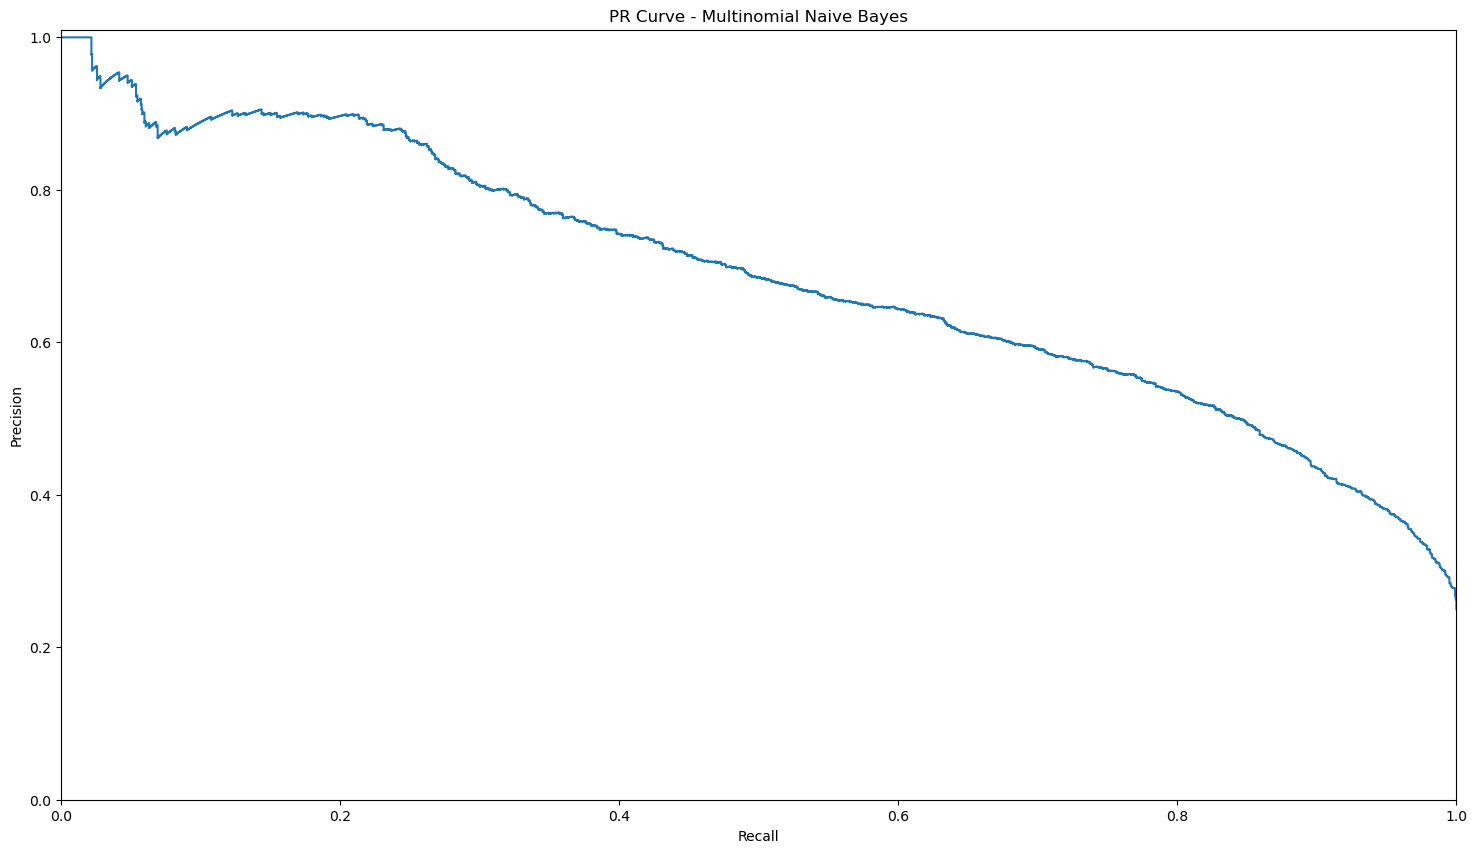

In [661]:
Y = label_binarize(y_val_sample, classes=[1, 2, 3, 4])

y_score = mnb.predict_proba(X_val_sample)

precision["Multinomial Naive Bayes"], recall["Multinomial Naive Bayes"], _ = precision_recall_curve(Y.ravel(), y_score.ravel())
fpr["Multinomial Naive Bayes"], tpr["Multinomial Naive Bayes"], _ = roc_curve(Y.ravel(), y_score.ravel())

plt.figure(figsize=(18, 10))
plt.step(recall["Multinomial Naive Bayes"], precision["Multinomial Naive Bayes"], where="post")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.xlim([0, 1])
plt.ylim([0, 1.01])
plt.title("PR Curve - Multinomial Naive Bayes")
plt.show()

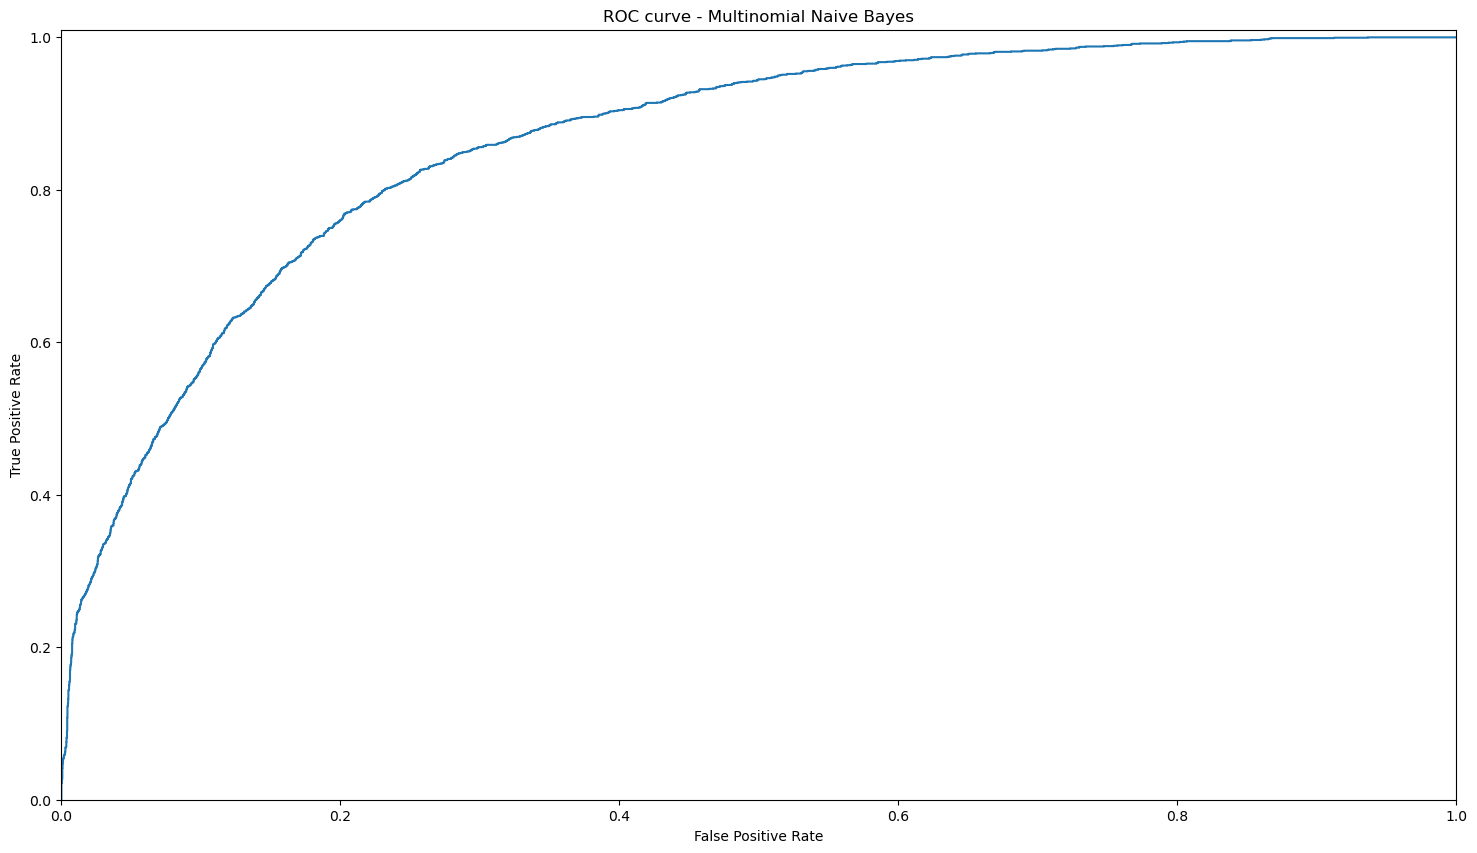

In [662]:
plt.figure(figsize=(18, 10))
plt.step(fpr["Multinomial Naive Bayes"], tpr["Multinomial Naive Bayes"], where="post")

plt.title("ROC curve - Multinomial Naive Bayes")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.xlim([0, 1])
plt.ylim([0, 1.01])
plt.show()

# CatBoost classifier

In [663]:
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV

# Define CatBoost parameters for GridSearch
catboost_params = {
    'iterations': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.5],
    'depth': [4, 6, 10]
}

# Initialize CatBoost Classifier
catboost = CatBoostClassifier(random_state=42, verbose=0)  # Set verbose to 0 for silent training

# GridSearchCV for CatBoost
grid_catboost = GridSearchCV(catboost, catboost_params, verbose=0, n_jobs=-1)
grid_catboost.fit(X_train_sample, y_train_encoded)

# Print the best parameters and training score for CatBoost
print("Best parameters for CatBoost:")
print(grid_catboost.best_params_)
print("Train score for CatBoost: ", grid_catboost.score(X_train_sample, y_train_encoded))


Best parameters for CatBoost:
{'depth': 6, 'iterations': 300, 'learning_rate': 0.1}
Train score for CatBoost:  0.878


In [664]:
from catboost import CatBoostClassifier

print("Best Param scores for CatBoost:")
cat_best = CatBoostClassifier(**grid_catboost.best_params_, random_state=42, verbose=0)

cat_best.fit(X_train_sample, y_train_encoded)
# Storing the model trained with best params for later use in visualizations
models["CatBoost Classifier"] = cat_best

print("Train Score: ", cat_best.score(X_train_sample, y_train_encoded))
print("Validation Score: ", cat_best.score(X_val_sample, y_val_encoded))


Best Param scores for CatBoost:
Train Score:  0.878
Validation Score:  0.777


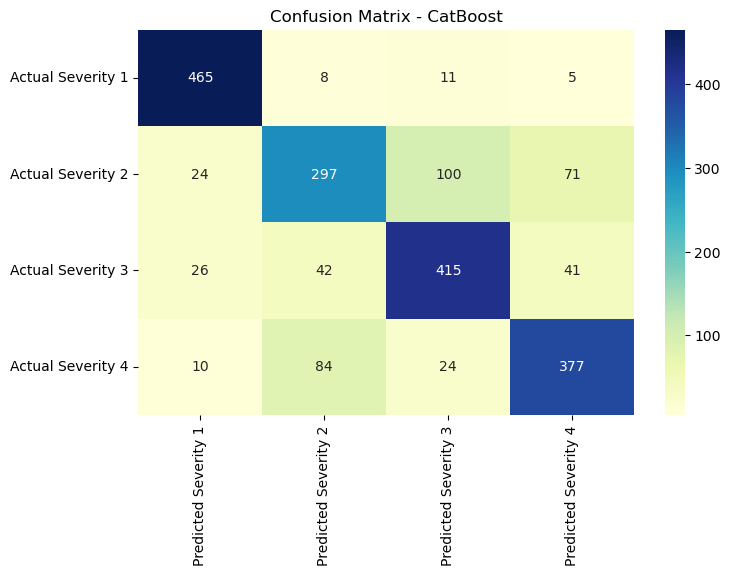

In [665]:
# Prediction using the CatBoost model
y_pred_cat = cat_best.predict(X_val_sample)

# Generate the confusion matrix
confmat_cat = confusion_matrix(y_true=y_val_encoded, y_pred=y_pred_cat)

# Define labels for the confusion matrix
index = ["Actual Severity 1", "Actual Severity 2", "Actual Severity 3", "Actual Severity 4"]
columns = ["Predicted Severity 1", "Predicted Severity 2", "Predicted Severity 3", "Predicted Severity 4"]

# Create DataFrame for confusion matrix
conf_matrix_cat = pd.DataFrame(data=confmat_cat, columns=columns, index=index)

# Plot the confusion matrix
plt.figure(figsize=(8, 5))
sns.heatmap(conf_matrix_cat, annot=True, fmt="d", cmap="YlGnBu")
plt.title("Confusion Matrix - CatBoost")
plt.show()

In [666]:
# Prediction using the CatBoost model
y_pred_cat = cat_best.predict(X_val_sample)

# Calculate accuracy and F1 score for CatBoost
accuracy["CatBoost"] = accuracy_score(y_val_encoded, y_pred_cat)
f1["CatBoost"] = f1_score(y_val_encoded, y_pred_cat, average="macro")

# Display classification reports
print("Classification Report for CatBoost on Training Data:")
print(classification_report(y_train_encoded, cat_best.predict(X_train_sample)))

print("Classification Report for CatBoost on Validation Data:")
print(classification_report(y_val_encoded, y_pred_cat))

Classification Report for CatBoost on Training Data:
              precision    recall  f1-score   support

           0       0.92      0.98      0.95      1991
           1       0.88      0.77      0.82      1988
           2       0.83      0.87      0.85      1985
           3       0.89      0.89      0.89      2036

    accuracy                           0.88      8000
   macro avg       0.88      0.88      0.88      8000
weighted avg       0.88      0.88      0.88      8000

Classification Report for CatBoost on Validation Data:
              precision    recall  f1-score   support

           0       0.89      0.95      0.92       489
           1       0.69      0.60      0.64       492
           2       0.75      0.79      0.77       524
           3       0.76      0.76      0.76       495

    accuracy                           0.78      2000
   macro avg       0.77      0.78      0.77      2000
weighted avg       0.77      0.78      0.77      2000



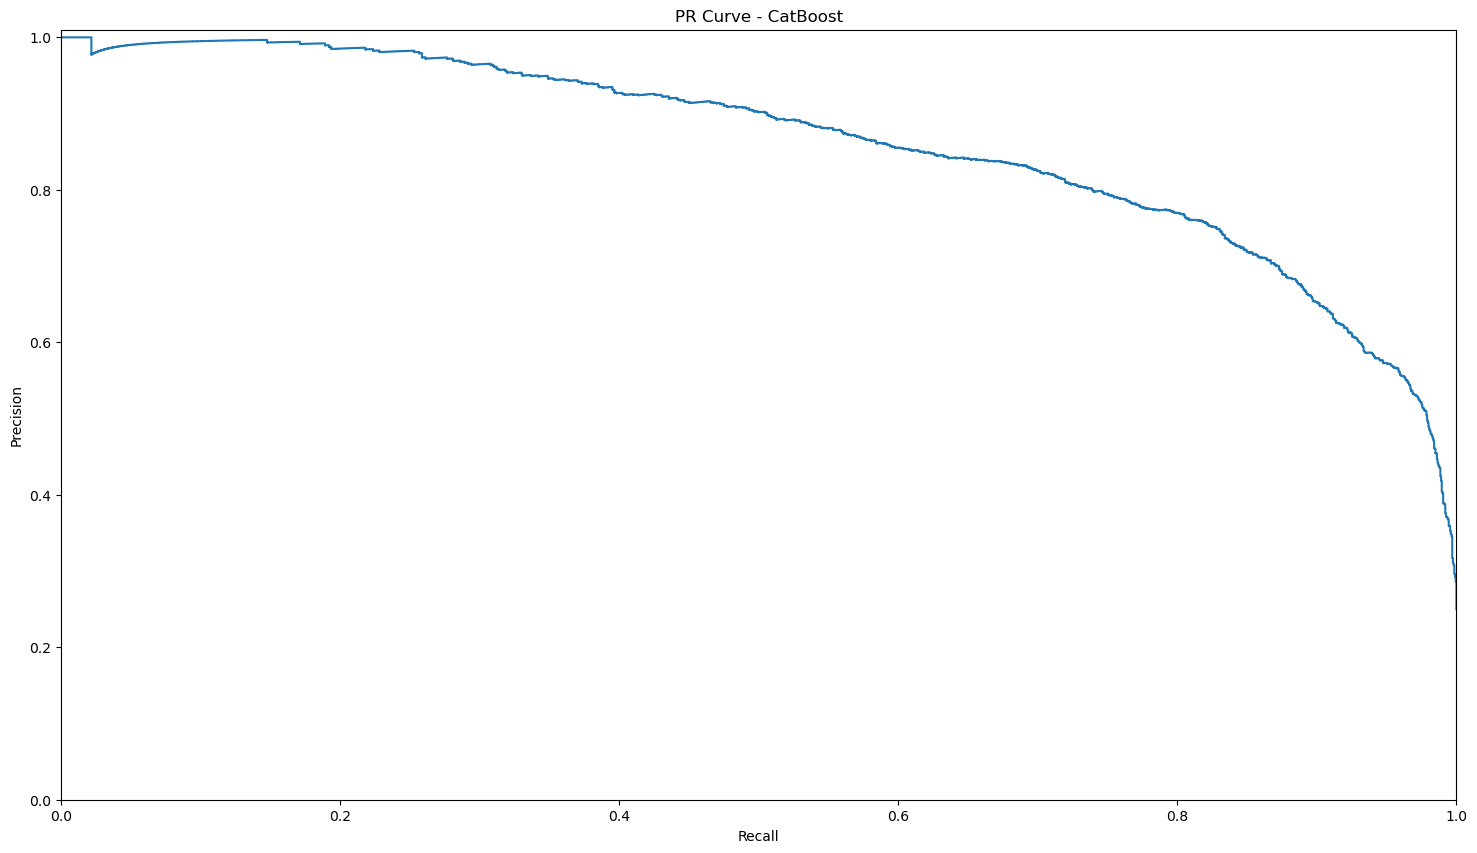

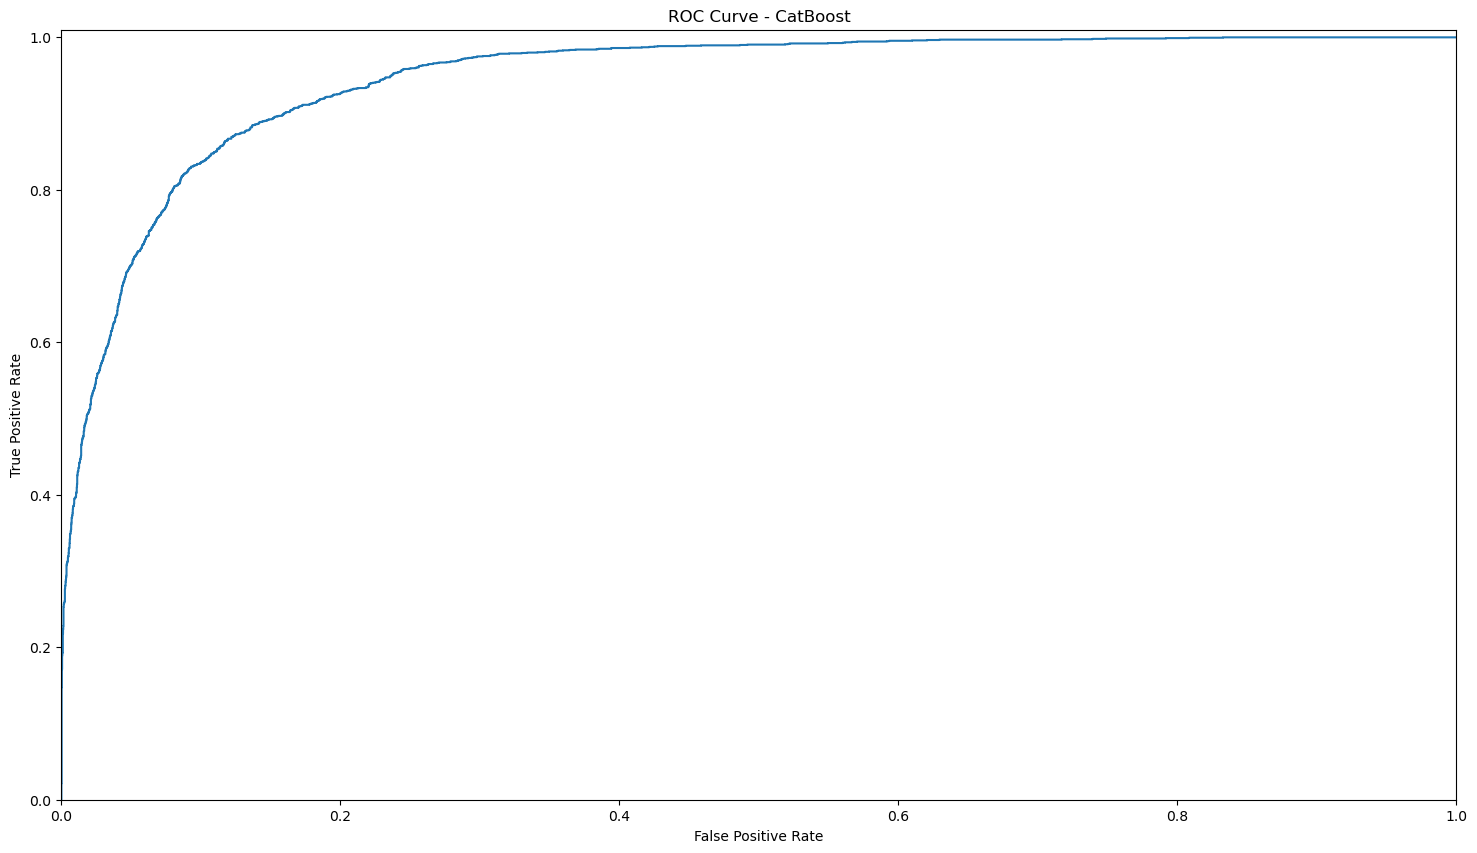

In [667]:
# Binarize the output for multiclass
Y = label_binarize(y_val_encoded, classes=[0, 1, 2, 3])

# Get the probability scores from CatBoost
y_score_cat = cat_best.predict_proba(X_val_sample)

# Compute Precision-Recall and ROC metrics for CatBoost
precision["CatBoost"], recall["CatBoost"], _ = precision_recall_curve(Y.ravel(), y_score_cat.ravel())
fpr["CatBoost"], tpr["CatBoost"], _ = roc_curve(Y.ravel(), y_score_cat.ravel())

# Plot the Precision-Recall Curve
plt.figure(figsize=(18, 10))
plt.step(recall["CatBoost"], precision["CatBoost"], where="post")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.xlim([0, 1])
plt.ylim([0, 1.01])
plt.title("PR Curve - CatBoost")
plt.show()

# Plot the ROC Curve
plt.figure(figsize=(18, 10))
plt.step(fpr["CatBoost"], tpr["CatBoost"], where="post")
plt.title("ROC Curve - CatBoost")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.xlim([0, 1])
plt.ylim([0, 1.01])
plt.show()

# AdaBoost classifier

In [668]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

# Define AdaBoost parameters
ada_params = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1.0],
    'estimator': [DecisionTreeClassifier(max_depth=1), DecisionTreeClassifier(max_depth=2)]  # Updated parameter name
}

# Initialize AdaBoost Classifier
ada = AdaBoostClassifier(random_state=42)

# GridSearchCV for AdaBoost
grid_ada = GridSearchCV(ada, ada_params, verbose=0, n_jobs=-1)
grid_ada.fit(X_train_sample, y_train_encoded)

# Print the best parameters and training score for AdaBoost
print("Best parameters for AdaBoost:")
print(grid_ada.best_params_)
print("Train score for AdaBoost: ", grid_ada.score(X_train_sample, y_train_encoded))


Best parameters for AdaBoost:
{'estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 50}
Train score for AdaBoost:  0.723125


In [669]:
print("Best Param scores for AdaBoost:")
ada_best = AdaBoostClassifier(**grid_ada.best_params_, random_state=42)

ada_best.fit(X_train_sample, y_train_encoded)
# Storing the model trained with best params for later use in visualizations
models["AdaBoost Classifier"] = ada_best

print("Train Score: ", ada_best.score(X_train_sample, y_train_encoded))
print("Validation Score: ", ada_best.score(X_val_sample, y_val_encoded))


Best Param scores for AdaBoost:
Train Score:  0.723125
Validation Score:  0.711


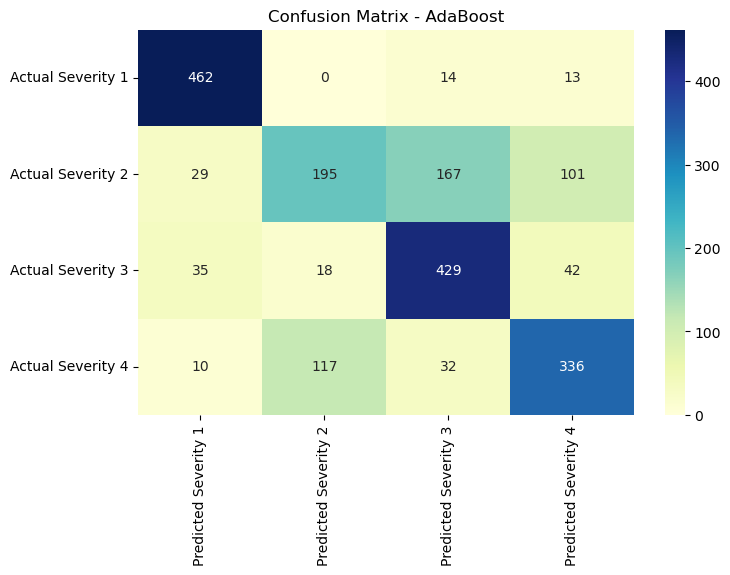

In [670]:
# Prediction using the AdaBoost model
y_pred_ada = ada_best.predict(X_val_sample)

# Generate the confusion matrix
confmat_ada = confusion_matrix(y_true=y_val_encoded, y_pred=y_pred_ada)

# Define labels for the confusion matrix
index = ["Actual Severity 1", "Actual Severity 2", "Actual Severity 3", "Actual Severity 4"]
columns = ["Predicted Severity 1", "Predicted Severity 2", "Predicted Severity 3", "Predicted Severity 4"]

# Create DataFrame for confusion matrix
conf_matrix_ada = pd.DataFrame(data=confmat_ada, columns=columns, index=index)

# Plot the confusion matrix
plt.figure(figsize=(8, 5))
sns.heatmap(conf_matrix_ada, annot=True, fmt="d", cmap="YlGnBu")
plt.title("Confusion Matrix - AdaBoost")
plt.show()


In [671]:
# y_pred = ada_best.predict(X_val_sample)

# accuracy["ADB"] = accuracy_score(y_val_encoded, y_pred)
# f1["ADB"] = f1_score(y_val_encoded, y_pred, average="macro")

# # Classification Report
# print(classification_report(y_train_encoded, ada_best.predict(X_train_sample)))
# print(classification_report(y_val_encoded, y_pred))

# Prediction using the AdaBoost model
y_pred_ada = ada_best.predict(X_val_sample)

# Calculate accuracy and F1 score for AdaBoost
accuracy["AdaBoost"] = accuracy_score(y_val_encoded, y_pred_ada)
f1["AdaBoost"] = f1_score(y_val_encoded, y_pred_ada, average="macro")

# Display classification reports
print("Classification Report for AdaBoost on Training Data:")
print(classification_report(y_train_encoded, ada_best.predict(X_train_sample)))

print("Classification Report for AdaBoost on Validation Data:")
print(classification_report(y_val_encoded, y_pred_ada))


Classification Report for AdaBoost on Training Data:
              precision    recall  f1-score   support

           0       0.88      0.94      0.91      1991
           1       0.61      0.42      0.50      1988
           2       0.66      0.81      0.73      1985
           3       0.71      0.72      0.72      2036

    accuracy                           0.72      8000
   macro avg       0.72      0.72      0.71      8000
weighted avg       0.72      0.72      0.71      8000

Classification Report for AdaBoost on Validation Data:
              precision    recall  f1-score   support

           0       0.86      0.94      0.90       489
           1       0.59      0.40      0.47       492
           2       0.67      0.82      0.74       524
           3       0.68      0.68      0.68       495

    accuracy                           0.71      2000
   macro avg       0.70      0.71      0.70      2000
weighted avg       0.70      0.71      0.70      2000



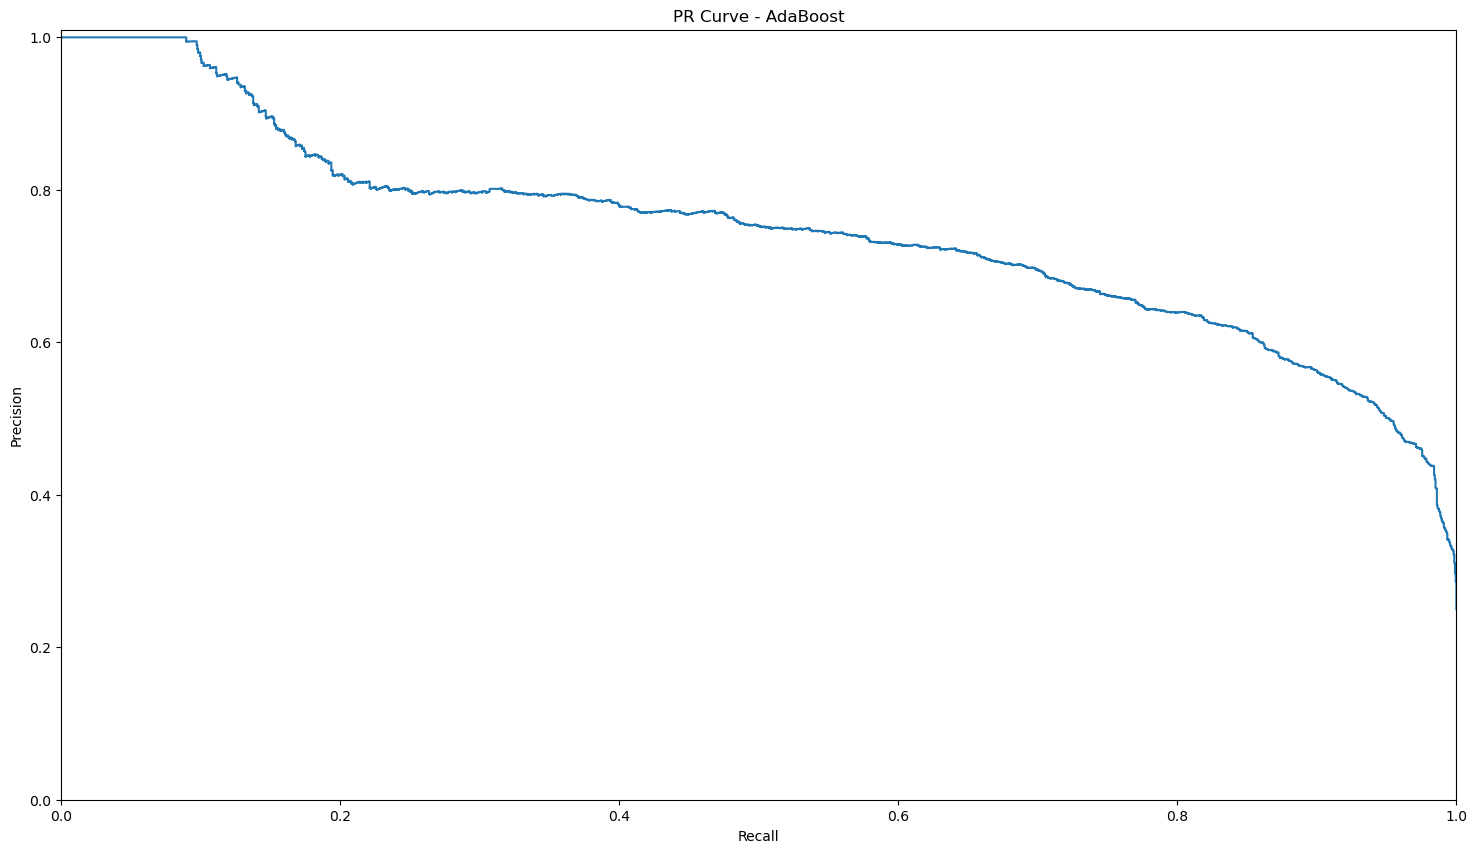

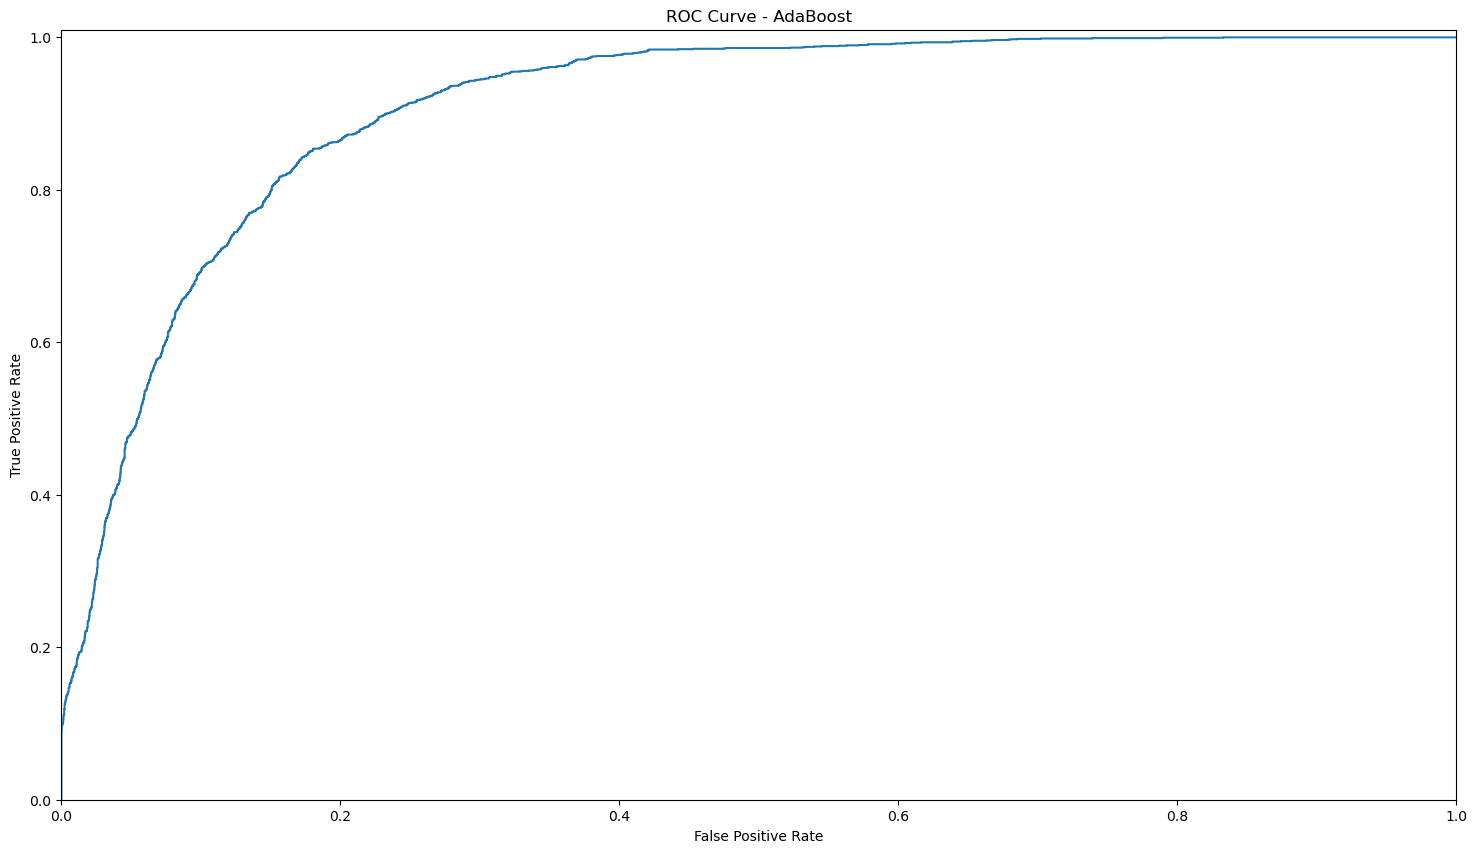

In [672]:
# Binarize the output
Y = label_binarize(y_val_encoded, classes=[0, 1, 2, 3])

# Get the probability scores from AdaBoost
y_score_ada = ada_best.predict_proba(X_val_sample)

# Compute Precision-Recall and ROC metrics for AdaBoost
precision["AdaBoost"], recall["AdaBoost"], _ = precision_recall_curve(Y.ravel(), y_score_ada.ravel())
fpr["AdaBoost"], tpr["AdaBoost"], _ = roc_curve(Y.ravel(), y_score_ada.ravel())

# Plot the Precision-Recall Curve
plt.figure(figsize=(18, 10))
plt.step(recall["AdaBoost"], precision["AdaBoost"], where="post")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.xlim([0, 1])
plt.ylim([0, 1.01])
plt.title("PR Curve - AdaBoost")
plt.show()

# Plot the ROC Curve
plt.figure(figsize=(18, 10))
plt.step(fpr["AdaBoost"], tpr["AdaBoost"], where="post")

plt.title("ROC Curve - AdaBoost")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.xlim([0, 1])
plt.ylim([0, 1.01])
plt.show()


# XGBoost Classifier

In [673]:
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

# Create an instance of LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the target variable
y_train_encoded = label_encoder.fit_transform(y_train_sample)
y_val_encoded = label_encoder.transform(y_val_sample)

parameters = [
    {'learning_rate': [0.1, 0.01, 0.05],
     'subsample': [0.6, 0.8, 0.9],
     'n_estimators': [16, 64, 128]}
]

# Update XGBClassifier to use a CPU-based method
xgb = XGBClassifier(tree_method='hist', random_state=42)  # Changed from 'gpu_hist' to 'hist'
grid = GridSearchCV(xgb, parameters, verbose=0, n_jobs=-1)
grid.fit(X_train_sample, y_train_encoded)

print("Best parameters scores:")
print(grid.best_params_)
best_params["xgb"] = grid.best_params_
print("Train score: ", grid.score(X_train_sample, y_train_encoded))


Best parameters scores:
{'learning_rate': 0.05, 'n_estimators': 128, 'subsample': 0.6}
Train score:  0.872375


In [674]:
pd.DataFrame(grid.cv_results_).sort_values(by="rank_test_score")

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_n_estimators,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
24,1.618633,0.057853,0.050689,0.007164,0.05,128,0.6,"{'learning_rate': 0.05, 'n_estimators': 128, '...",0.801250,0.795625,0.796875,0.774375,0.793750,0.792375,0.009332,1
8,1.461562,0.045509,0.045909,0.010119,0.1,128,0.9,"{'learning_rate': 0.1, 'n_estimators': 128, 's...",0.796875,0.798750,0.798750,0.769375,0.796875,0.792125,0.011406,2
7,1.466655,0.028012,0.046301,0.006378,0.1,128,0.8,"{'learning_rate': 0.1, 'n_estimators': 128, 's...",0.795625,0.797500,0.788750,0.775625,0.795625,0.790625,0.008072,3
6,1.456975,0.024217,0.042475,0.009017,0.1,128,0.6,"{'learning_rate': 0.1, 'n_estimators': 128, 's...",0.800000,0.795000,0.790625,0.771875,0.795000,0.790500,0.009774,4
5,0.764012,0.028603,0.023765,0.003919,0.1,64,0.9,"{'learning_rate': 0.1, 'n_estimators': 64, 'su...",0.796250,0.795625,0.790000,0.768750,0.796875,0.789500,0.010661,5
26,1.313918,0.025760,0.025864,0.002418,0.05,128,0.9,"{'learning_rate': 0.05, 'n_estimators': 128, '...",0.793125,0.798125,0.793125,0.765000,0.795000,0.788875,0.012077,6
25,1.601701,0.132697,0.041983,0.007397,0.05,128,0.8,"{'learning_rate': 0.05, 'n_estimators': 128, '...",0.798125,0.792500,0.791875,0.769375,0.792500,0.788875,0.010011,6
3,0.806990,0.023406,0.030143,0.002959,0.1,64,0.6,"{'learning_rate': 0.1, 'n_estimators': 64, 'su...",0.798125,0.795625,0.792500,0.771250,0.785625,0.788625,0.009645,8
4,0.792758,0.013774,0.024759,0.005697,0.1,64,0.8,"{'learning_rate': 0.1, 'n_estimators': 64, 'su...",0.792500,0.794375,0.791250,0.767500,0.796250,0.788375,0.010574,9
22,0.787574,0.023210,0.025731,0.003584,0.05,64,0.8,"{'learning_rate': 0.05, 'n_estimators': 64, 's...",0.791250,0.787500,0.787500,0.766250,0.791250,0.784750,0.009401,10


In [675]:
print("Best Param scores for XGB:")
xgb = XGBClassifier(**grid.best_params_,random_state=42)

xgb.fit(X_train_sample, y_train_encoded)
# Storing the model trained with best params later used for visualizations
models["XGB Classifier"] = xgb

print("Train Score: ", xgb.score(X_train_sample, y_train_encoded))
print("Validation Score: ", xgb.score(X_val_sample, y_val_encoded))


Best Param scores for XGB:
Train Score:  0.872375
Validation Score:  0.7775


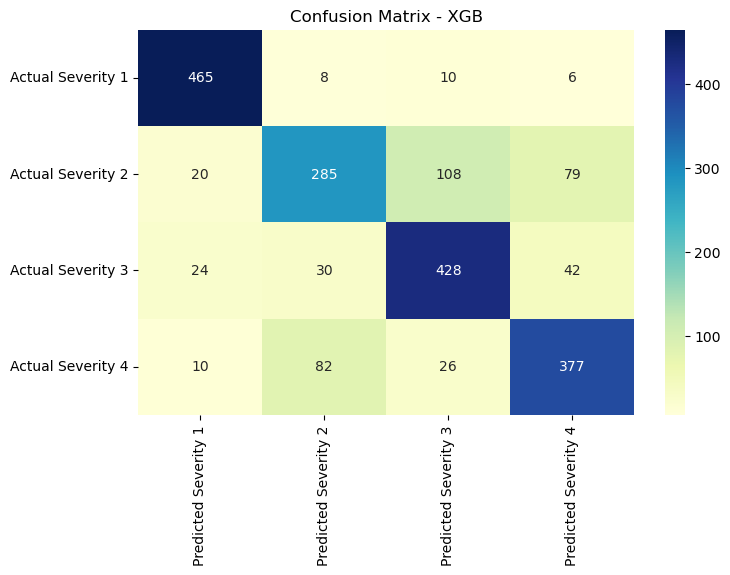

In [676]:
y_pred = xgb.predict(X_val_sample)
confmat = confusion_matrix(y_true=y_val_encoded, y_pred=y_pred)

index = ["Actual Severity 1", "Actual Severity 2", "Actual Severity 3", "Actual Severity 4"]
columns = ["Predicted Severity 1", "Predicted Severity 2", "Predicted Severity 3", "Predicted Severity 4"]
conf_matrix = pd.DataFrame(data=confmat, columns=columns, index=index)
plt.figure(figsize=(8, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="YlGnBu")
plt.title("Confusion Matrix - XGB")
plt.show()

In [677]:
y_pred = xgb.predict(X_val_sample)

accuracy["XGB"] = accuracy_score(y_val_encoded, y_pred)
f1["XGB"] = f1_score(y_val_encoded, y_pred, average="macro")

print(classification_report(y_train_encoded, xgb.predict(X_train_sample)))
print(classification_report(y_val_encoded, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.97      0.95      1991
           1       0.88      0.74      0.80      1988
           2       0.80      0.88      0.84      1985
           3       0.89      0.90      0.89      2036

    accuracy                           0.87      8000
   macro avg       0.87      0.87      0.87      8000
weighted avg       0.87      0.87      0.87      8000

              precision    recall  f1-score   support

           0       0.90      0.95      0.92       489
           1       0.70      0.58      0.64       492
           2       0.75      0.82      0.78       524
           3       0.75      0.76      0.75       495

    accuracy                           0.78      2000
   macro avg       0.77      0.78      0.77      2000
weighted avg       0.77      0.78      0.77      2000



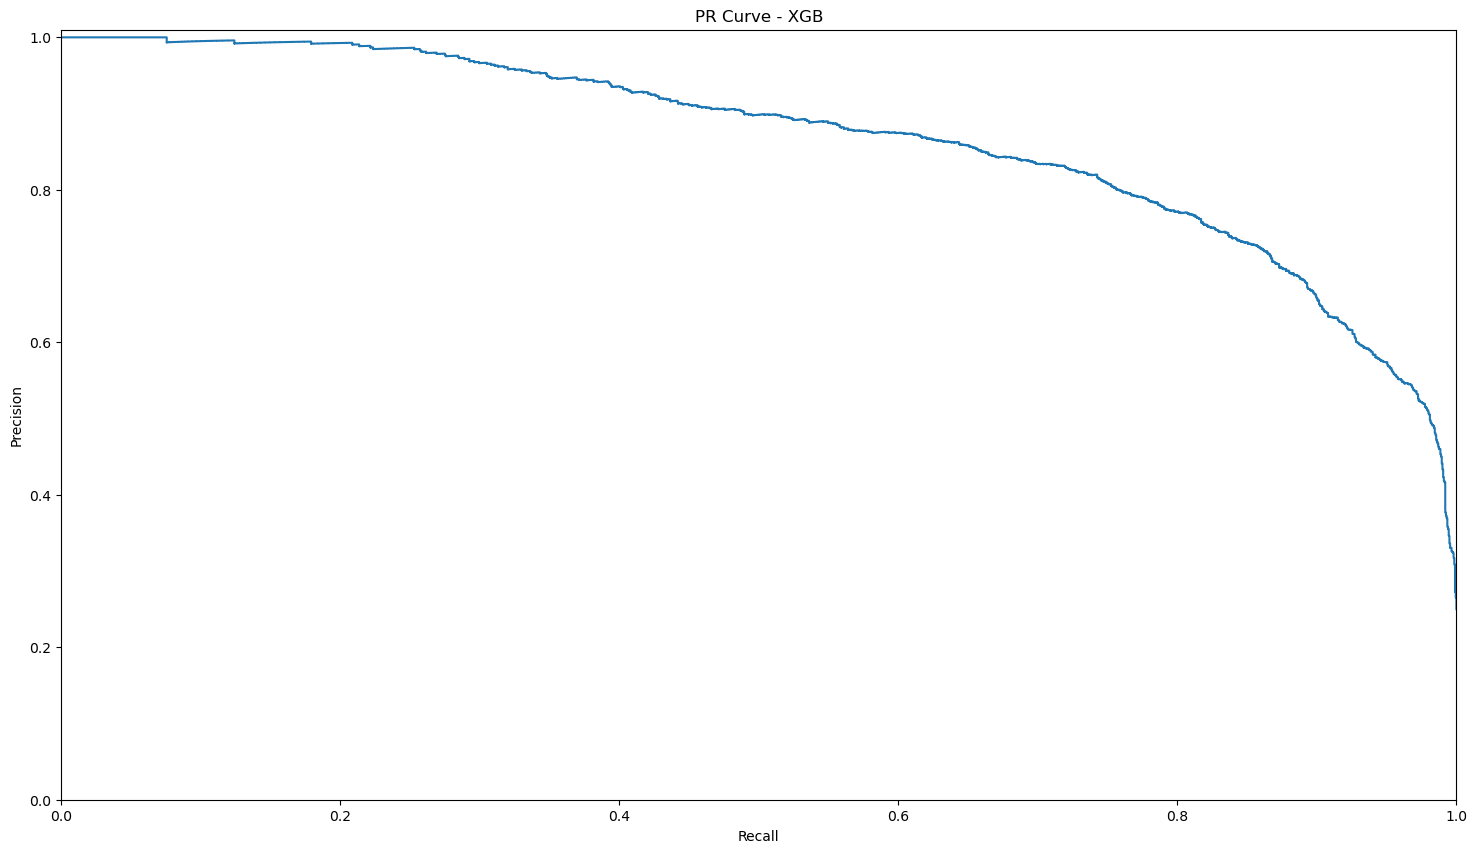

In [678]:
Y = label_binarize(y_val_encoded, classes=[0, 1, 2, 3])

y_score = xgb.predict_proba(X_val_sample)

precision["XGB"], recall["XGB"], _ = precision_recall_curve(Y.ravel(), y_score.ravel())
fpr["XGB"], tpr["XGB"], _ = roc_curve(Y.ravel(), y_score.ravel())

plt.figure(figsize=(18, 10))
plt.step(recall["XGB"], precision["XGB"], where="post")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.xlim([0, 1])
plt.ylim([0, 1.01])
plt.title("PR Curve - XGB")
plt.show()

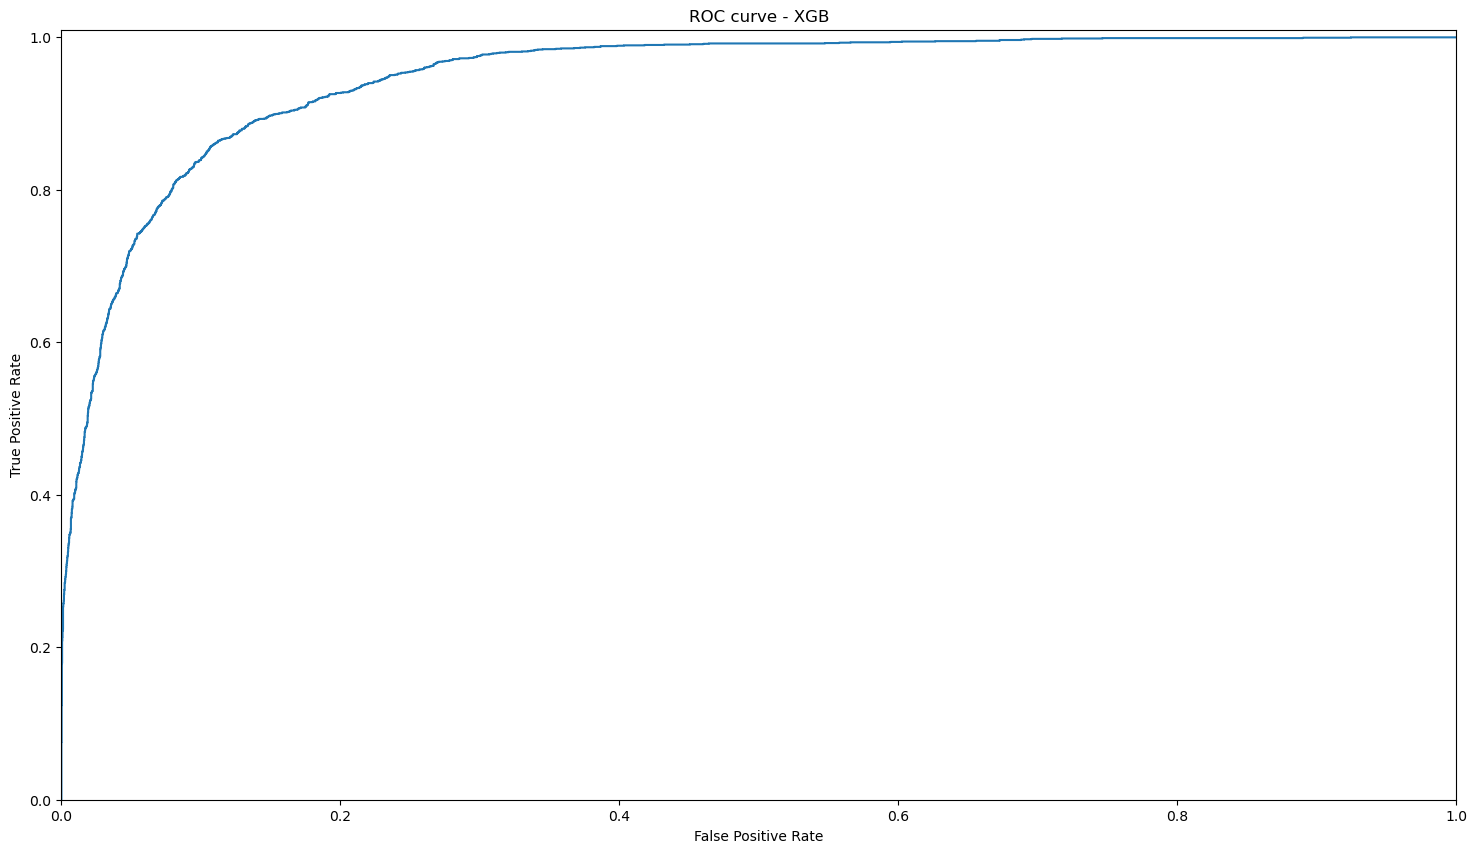

In [679]:
plt.figure(figsize=(18, 10))
plt.step(fpr["XGB"], tpr["XGB"], where="post")

plt.title("ROC curve - XGB")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.xlim([0, 1])
plt.ylim([0, 1.01])
plt.show()

# Support Vector Machine

In [680]:
parameters = [{"kernel": ["linear", "rbf", "sigmoid"], "C": [.2, .5, .8, 1.]}, {"kernel": ["poly"], "C": [.2, .5, .8, 1.], "degree": [2, 3, 4]}]
svc = svm.SVC(verbose = 0, random_state = 42, shrinking = False)
grid = GridSearchCV(svc, parameters, verbose = 0, n_jobs = -1)

grid.fit(X_sample_train,y_sample_train)
print("Best parameters scores:")
print(grid.best_params_)
best_params["svc"] = grid.best_params_
print("Train score: ", grid.score(X_sample_train, y_sample_train))

Best parameters scores:
{'C': 1.0, 'degree': 2, 'kernel': 'poly'}
Train score:  0.764


In [681]:
pd.DataFrame(grid.cv_results_).sort_values(by="rank_test_score")

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_kernel,param_degree,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
21,6.102942,0.084072,0.671793,0.024163,1.0,poly,2,"{'C': 1.0, 'degree': 2, 'kernel': 'poly'}",0.7395,0.7185,0.7260,0.7060,0.7230,0.7226,0.010860,1
10,5.656291,0.750942,2.356231,0.102957,1.0,rbf,NaN,"{'C': 1.0, 'kernel': 'rbf'}",0.7370,0.7210,0.7265,0.7045,0.7235,0.7225,0.010521,2
18,6.270721,0.136205,0.674149,0.043306,0.8,poly,2,"{'C': 0.8, 'degree': 2, 'kernel': 'poly'}",0.7390,0.7195,0.7225,0.7050,0.7215,0.7215,0.010803,3
19,6.378310,0.148757,0.772024,0.056877,0.8,poly,3,"{'C': 0.8, 'degree': 3, 'kernel': 'poly'}",0.7385,0.7240,0.7220,0.7000,0.7230,0.7215,0.012329,3
16,6.627131,0.063550,0.741805,0.025325,0.5,poly,3,"{'C': 0.5, 'degree': 3, 'kernel': 'poly'}",0.7320,0.7195,0.7265,0.7060,0.7235,0.7215,0.008758,3
7,5.921686,0.285094,2.412742,0.117028,0.8,rbf,NaN,"{'C': 0.8, 'kernel': 'rbf'}",0.7365,0.7145,0.7220,0.7075,0.7220,0.7205,0.009649,6
9,9.632921,1.192727,0.679632,0.083288,1.0,linear,NaN,"{'C': 1.0, 'kernel': 'linear'}",0.7370,0.7190,0.7245,0.7060,0.7155,0.7204,0.010254,7
22,6.298377,0.081851,0.690594,0.032019,1.0,poly,3,"{'C': 1.0, 'degree': 3, 'kernel': 'poly'}",0.7395,0.7205,0.7255,0.6945,0.7200,0.7200,0.014567,8
6,8.798265,1.061083,0.699947,0.036766,0.8,linear,NaN,"{'C': 0.8, 'kernel': 'linear'}",0.7370,0.7180,0.7235,0.7040,0.7145,0.7194,0.010860,9
15,6.344761,0.099202,0.720814,0.035262,0.5,poly,2,"{'C': 0.5, 'degree': 2, 'kernel': 'poly'}",0.7370,0.7135,0.7190,0.7025,0.7190,0.7182,0.011165,10


In [682]:
### We run the model on partial Dataset for fast training and observing the op/s.
print("Best Param scores for SVM:")
svc = svm.SVC(verbose = 0, random_state = 42, shrinking = False, C=1, kernel = 'rbf', degree = 4)

svc.fit(X_train_sample, y_train_sample)
# Storing the model trained with best params later used for visualizations
models["Support Vector Machine"] = svc

print("Train score:", svc.score(X_train_sample, y_train_sample))
print("Validation score:", svc.score(X_val_sample, y_val_sample))

Best Param scores for SVM:
Train score: 0.784625
Validation score: 0.718


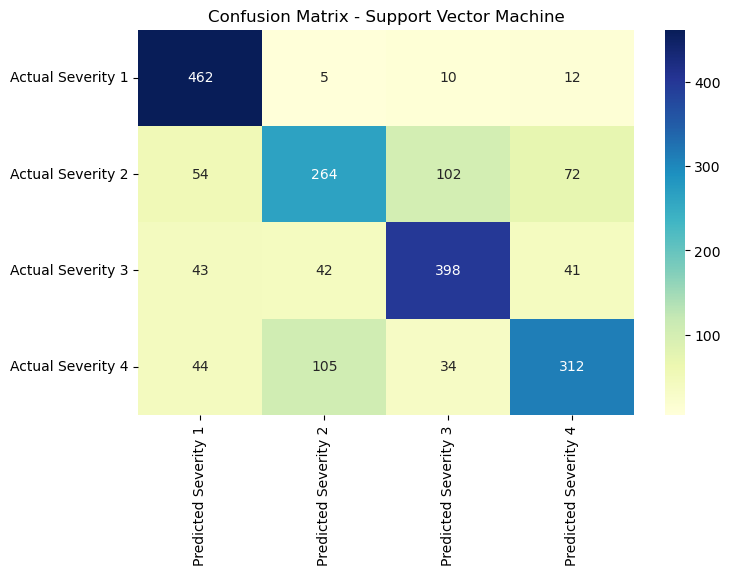

In [683]:
y_pred = svc.predict(X_val_sample)
confmat = confusion_matrix(y_true=y_val_sample, y_pred=y_pred)

index = ["Actual Severity 1", "Actual Severity 2", "Actual Severity 3", "Actual Severity 4"]
columns = ["Predicted Severity 1", "Predicted Severity 2", "Predicted Severity 3", "Predicted Severity 4"]
conf_matrix = pd.DataFrame(data=confmat, columns=columns, index=index)
plt.figure(figsize=(8, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="YlGnBu")
plt.title("Confusion Matrix - Support Vector Machine")
plt.show()

In [684]:
y_pred = svc.predict(X_val_sample)

accuracy["SVM"] = accuracy_score(y_val_sample, y_pred)
f1["SVM"] = f1_score(y_val_sample, y_pred, average="macro")

print(classification_report(y_train_sample, svc.predict(X_train_sample)))
print(classification_report(y_val_sample, y_pred))


              precision    recall  f1-score   support

           1       0.80      0.96      0.87      1991
           2       0.77      0.61      0.68      1988
           3       0.75      0.81      0.78      1985
           4       0.82      0.76      0.79      2036

    accuracy                           0.78      8000
   macro avg       0.78      0.78      0.78      8000
weighted avg       0.78      0.78      0.78      8000

              precision    recall  f1-score   support

           1       0.77      0.94      0.85       489
           2       0.63      0.54      0.58       492
           3       0.73      0.76      0.75       524
           4       0.71      0.63      0.67       495

    accuracy                           0.72      2000
   macro avg       0.71      0.72      0.71      2000
weighted avg       0.71      0.72      0.71      2000



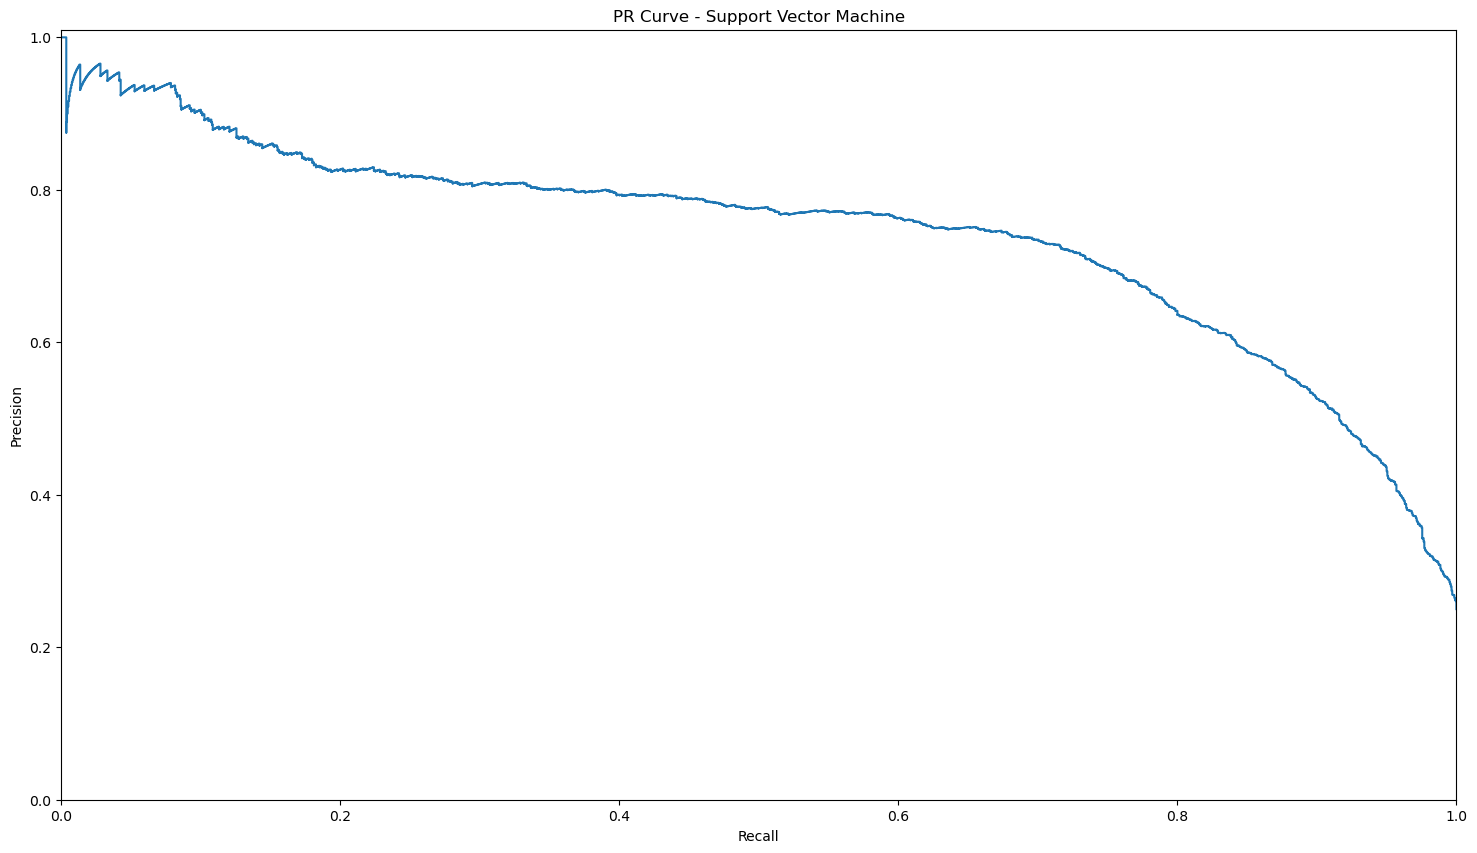

In [685]:
Y = label_binarize(y_val_sample, classes=[1, 2, 3, 4])

y_score = svc.decision_function(X_val_sample)

precision["SVM"], recall["SVM"], _ = precision_recall_curve(Y.ravel(), y_score.ravel())
fpr["SVM"], tpr["SVM"], _ = roc_curve(Y.ravel(), y_score.ravel())

plt.figure(figsize=(18, 10))
plt.step(recall["SVM"], precision["SVM"], where="post")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.xlim([0, 1])
plt.ylim([0, 1.01])
plt.title("PR Curve - Support Vector Machine")
plt.show()

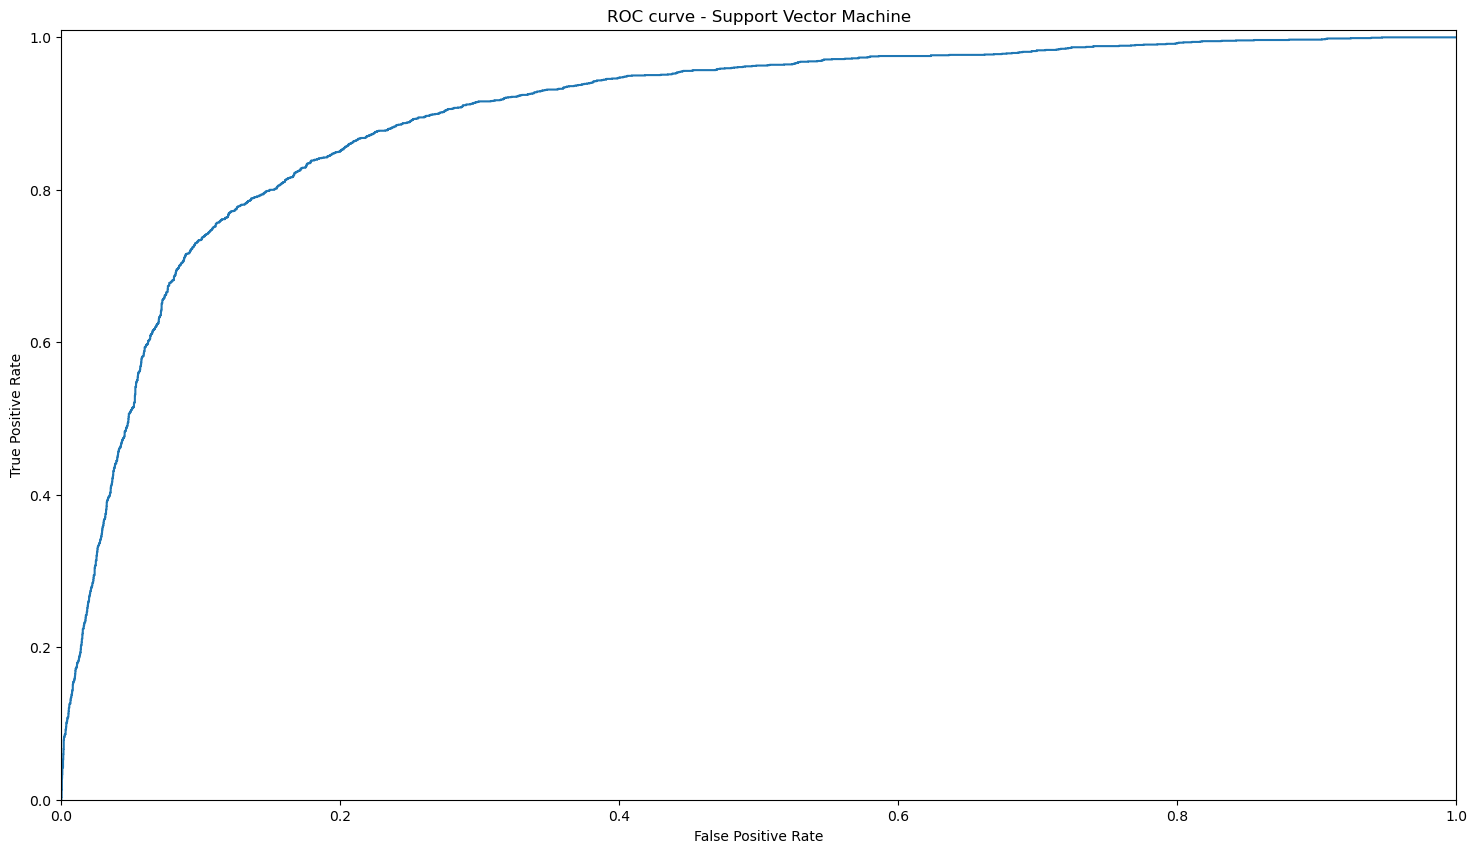

In [686]:
plt.figure(figsize=(18, 10))
plt.step(fpr["SVM"], tpr["SVM"], where="post")

plt.title("ROC curve - Support Vector Machine")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.xlim([0, 1])
plt.ylim([0, 1.01])
plt.show()

Accuracy Metric Comparision between Models

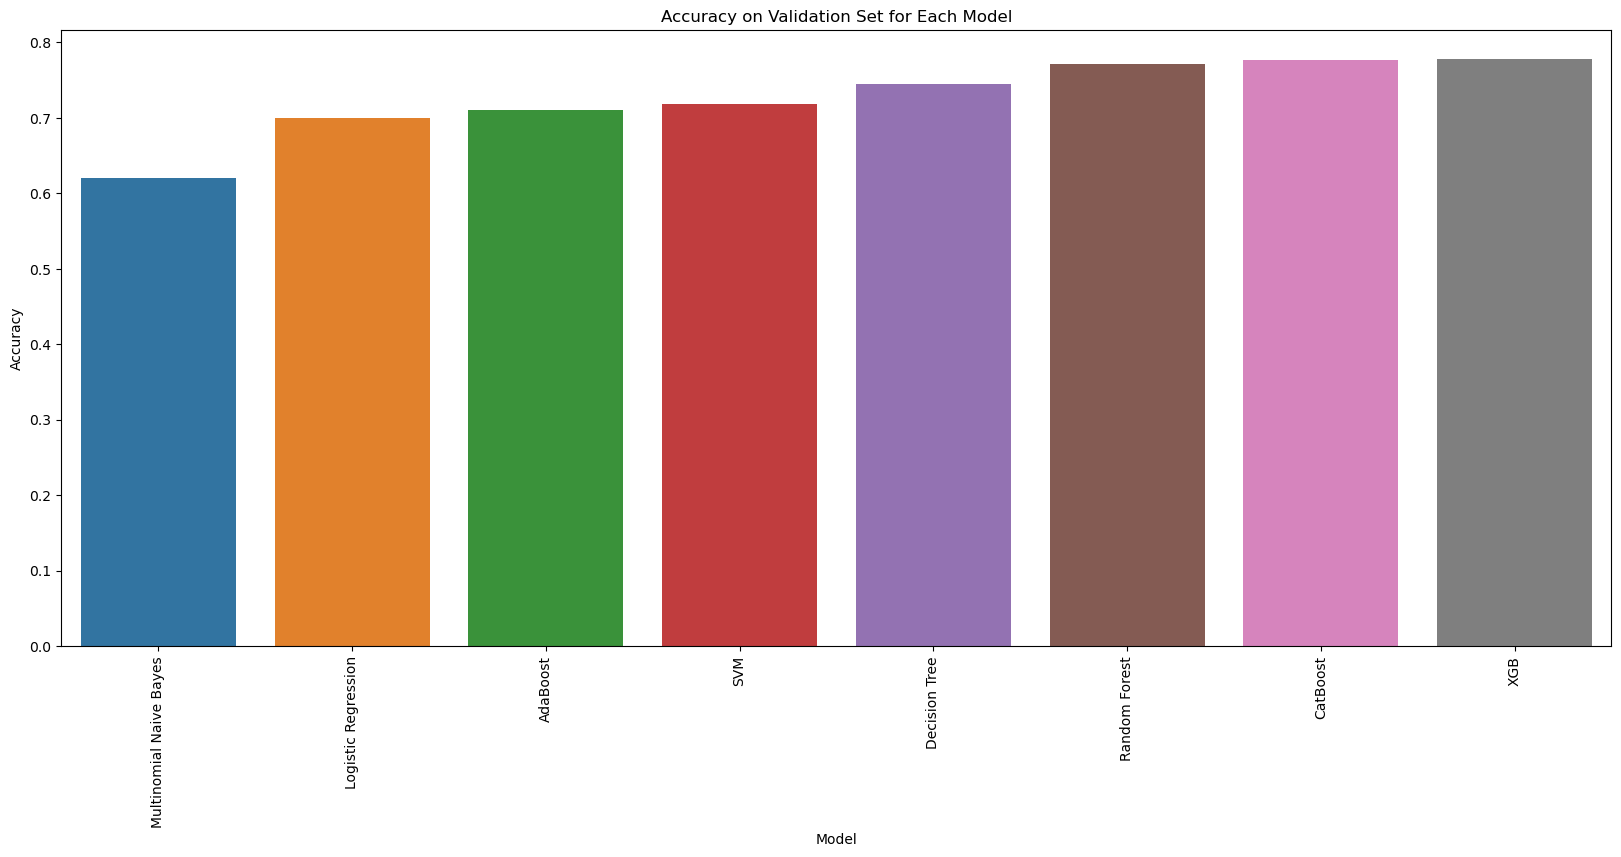

In [687]:
plt.figure(figsize=(20, 8))
plt.title("Accuracy on Validation Set for Each Model")
sorted_accuracy = sorted(accuracy.items(), key=lambda x: x[1])
sorted_labels = [item[0] for item in sorted_accuracy]
sorted_values = [item[1] for item in sorted_accuracy]
sns.barplot(x=sorted_labels, y=sorted_values)
plt.xticks(rotation=90)
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.savefig("All_Models_Accuracy_Score_Plot_on_Val_Set.png",bbox_inches = 'tight', dpi = 300)
plt.show()

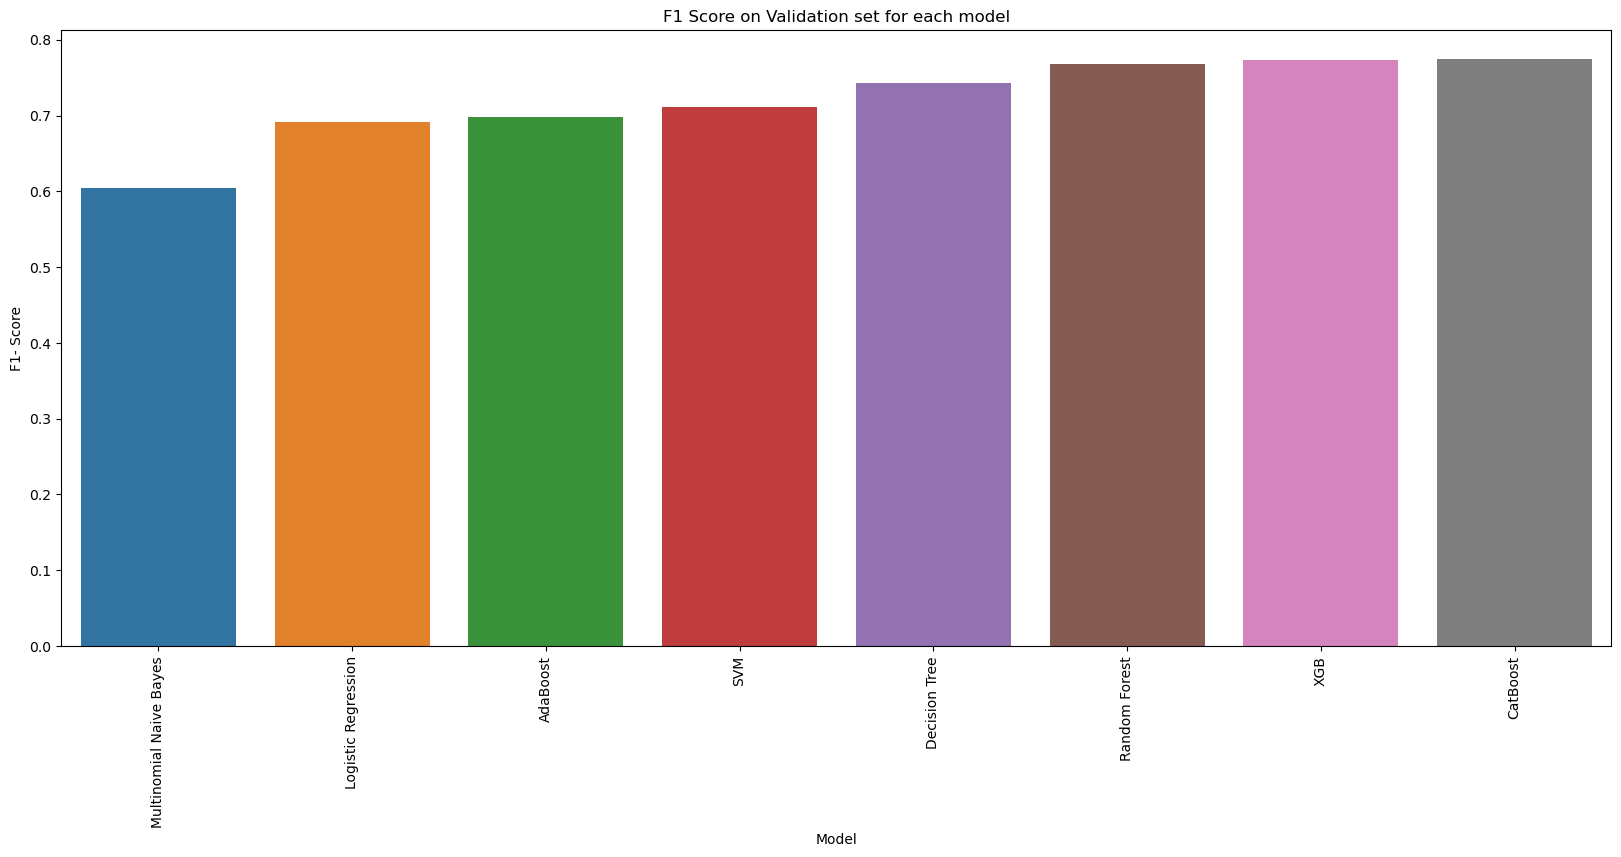

In [688]:
plt.figure(figsize=(20, 8))
plt.title("F1 Score on Validation set for each model")
sorted_f1 = sorted(f1.items(), key=lambda x: x[1])
sorted_labels = [item[0] for item in sorted_f1]
sorted_values = [item[1] for item in sorted_f1]
sns.barplot(x=sorted_labels, y=sorted_values)
plt.xticks(rotation=90)
plt.xlabel("Model")
plt.ylabel("F1- Score")
plt.savefig("All_Models_F1_Score_Plot_on_Val_Set.png",bbox_inches = 'tight', dpi = 300)
plt.show()

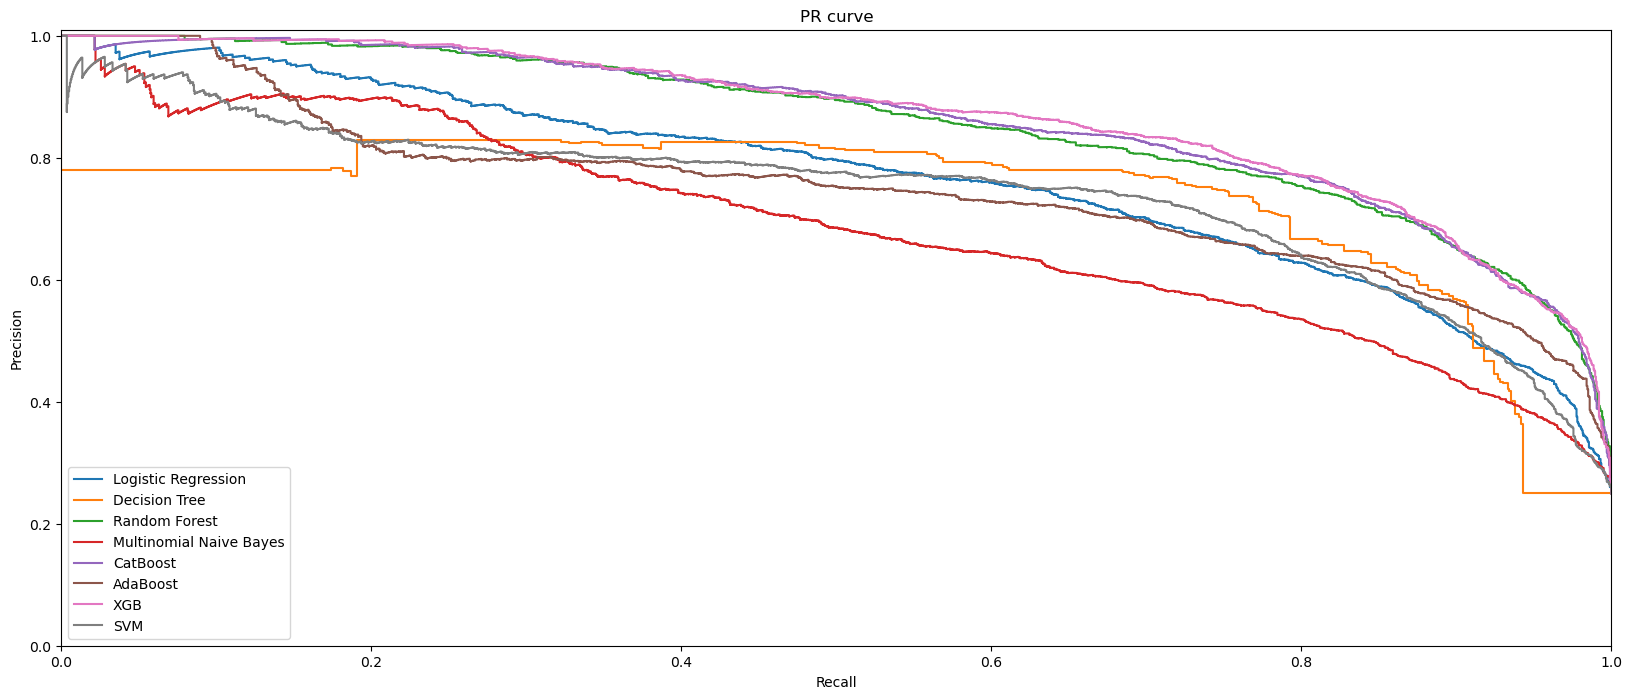

In [689]:
plt.figure(figsize=(20, 8))
for key in f1.keys():
    plt.step(recall[key], precision[key], where="post", label=key)

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.xlim([0, 1])
plt.ylim([0, 1.01])
plt.title("PR curve")
plt.legend()
plt.savefig("All_Models_PR_Curve_plot.png",bbox_inches = 'tight', dpi = 300)
plt.show()

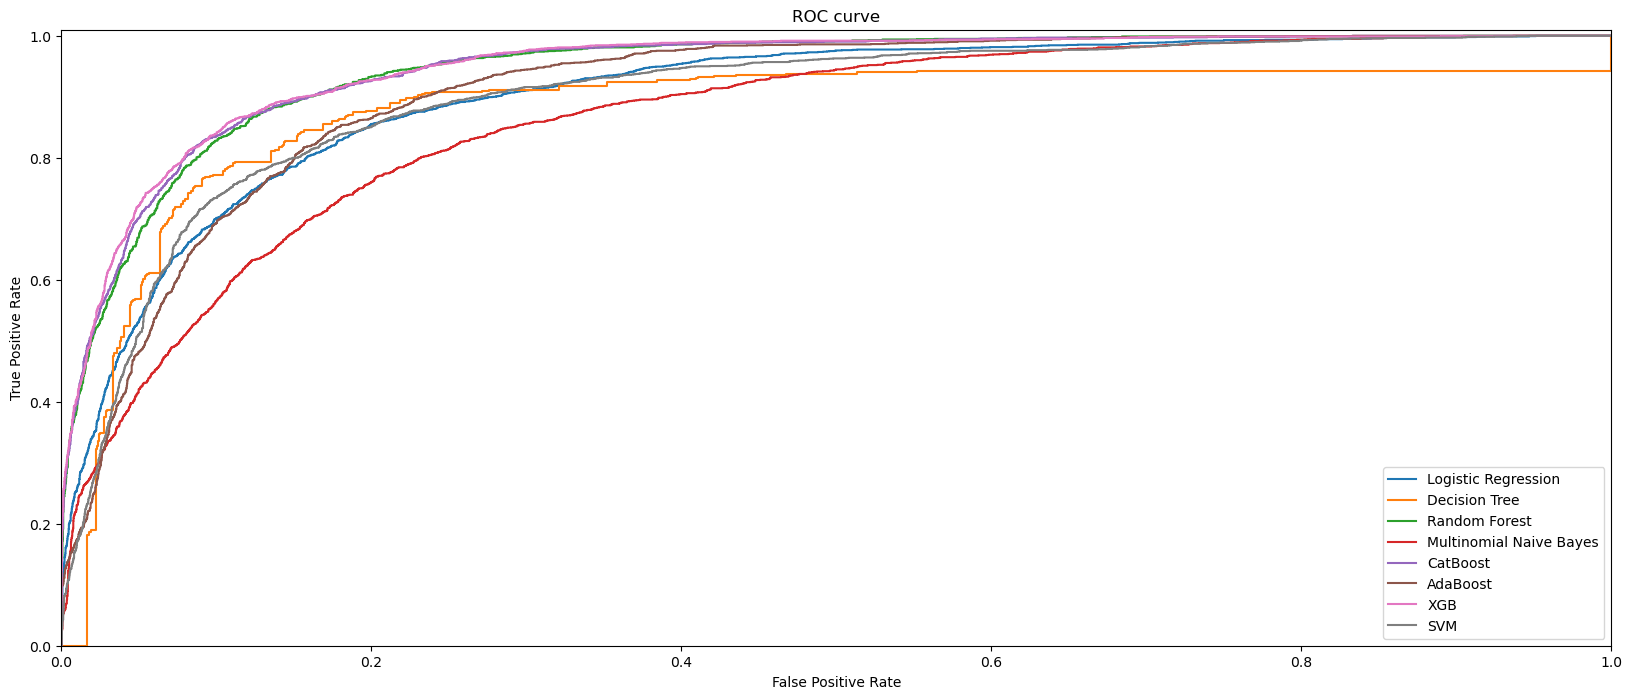

In [690]:
plt.figure(figsize=(20, 8))
for key in f1.keys():
    plt.step(fpr[key], tpr[key], where="post", label=key)

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.xlim([0, 1])
plt.ylim([0, 1.01])
plt.title("ROC curve")
plt.legend()
plt.savefig("All_Models_ROC_Curve_plot.png",bbox_inches = 'tight', dpi = 300)
plt.show()